<a href="https://colab.research.google.com/github/Bovi-analytics/Hut-et-al-2022/blob/main/DefinitiveModelEatingTime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook for Eating time

*   Load libraries
*   Create dataset eating grouped per 3/4/5
*   Descriptives dataset eating all cows
*   Run models eating grouped in 7 groups per 4
    * Create subsets eating
    * Descriptives lactating AMS/CMS and dry cows
    * Models linear mixed models (glmmTNB):
      1. THI mean
      2. THI max
      3. THI min
      4. THI mean 1 day before
      5. THI mean 2 days before
      6. Temperature mean
      7. Temperature max
      8. Temperature min
      9. Temperature mean 1 day before
      10. Temperature mean 2 days before
      
      a= lactating cows AMS farms
      b= lactating cows CMS farms
      c= dry cows
*   Eating time figures:
    * THI mean figures
    * Temperature mean figures

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [ ]:
%reload_ext rpy2.ipython

# Libraries

In [ ]:
%%R
lib_loc <- "/content/drive/Shareddrives/Bovi-Analytics/R-lib/"

In [ ]:
%%R
package_list <- c("glmmTMB",
                  "dplyr",
                  "ggplot2",
                  "emmeans",
                  "lsmeans",
                  "plyr")

for (pkg in package_list) {
  if (pkg %in% rownames(.packages()) == FALSE)
  {library(pkg, lib.loc = lib_loc, character.only = TRUE)}

}

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Keep up to date with changes at https://www.tidyverse.org/blog/

R[write to console]: The 'lsmeans' package is now basically a front end for 'emmeans'.
Users are encouraged to switch the rest of the way.
See help('transition') for more information, including how to
convert old 'lsmeans' objects and scripts to work with 'emmeans'.

R[write to console]: ------------------------------------------------------------------------------

R[write to console]: You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

R[write to console]: -------------------------------------------------------

# Create dataset eating grouped per 3/4/5

In [ ]:
%%R
url_eating <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/in/SensorData/ObservationType=EatingTimeMinutesPerDay/part-00134-tid-7288064156538290647-292796ee-9893-4de2-a04f-ea381f27134d-131-1.c000.csv'
dataset_behaviour <- read.csv(url_eating, header = TRUE, sep = ",") %>% 
 dplyr::mutate(
    Date = as.Date(EventDate,"%Y-%m-%d")
    ) %>%
 dplyr::select(
     -c(EventDate, Hour)
    ) %>%
 mutate(DimCat = case_when(DaysInMilk <= 0 ~ 0, #condition 1
                         DaysInMilk <= 21  ~ 1, #condition 2
                         DaysInMilk <= 60  ~ 3, #condition 3
                         DaysInMilk <= 120 ~ 4, #condition 4
                         DaysInMilk <= 200 ~ 5, #condition 5
                         DaysInMilk >= 200 ~ 6
    )) %>%
  mutate(AutomaticMilking = case_when(HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314 ~ 1, 
                         HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888~ 0
    )) %>%
  mutate(CowLac = paste(LactationNumber, AnimalEartag)) 

In [ ]:
%%R
url_KNMI3 <-'/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/df_KNMI_per3.csv'
url_KNMI4 <-'/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/df_KNMI_per4.csv'
url_KNMI5 <-'/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/df_KNMI_per5.csv'

In [ ]:
%%R
dataset_KNMI3 <- read.csv(url_KNMI3, header = TRUE, sep = ",") %>% 
  dplyr::mutate(
      Date = as.Date(Date,"%Y-%m-%d")
  )
  dataset_KNMI4 <- read.csv(url_KNMI4, header = TRUE, sep = ",") %>% 
  dplyr::mutate(
      Date = as.Date(Date,"%Y-%m-%d")
  )
  dataset_KNMI5 <- read.csv(url_KNMI5, header = TRUE, sep = ",") %>% 
  dplyr::mutate(
      Date = as.Date(Date,"%Y-%m-%d")
  )

In [ ]:
%%R
df_joined_per4 <- dataset_behaviour %>%
  dplyr::left_join(dataset_KNMI4, by = c("HerdIdentifier", "Date")) %>%                                                              
  dplyr::filter(Year > 2016) %>%
  dplyr::filter(SensorValue <=1440) %>%
  dplyr::mutate(Day= as.numeric(Date)-min(as.numeric(Date))) %>%
  dplyr::mutate(LactationNumber= case_when(LactationNumber == 1 ~ 1,
                                            LactationNumber == 2 ~ 2,
                                            LactationNumber == 3 ~ 3,
                                            LactationNumber == 4 ~ 4,
                                            LactationNumber == 5 ~ 5,
                                            LactationNumber == 6 ~ 6,
                                            LactationNumber == 7 ~ 7,
                                            LactationNumber >= 8 ~ 8)) %>%
   dplyr::mutate(Parity = case_when(LactationNumber==1~0, LactationNumber>=2~1
    ))                                           

In [ ]:
%%R
df_joined_per3 <- dataset_behaviour %>%
  dplyr::left_join(dataset_KNMI3, by = c("HerdIdentifier", "Date")) %>%                                                              
  dplyr::filter(Year > 2016) %>%
  dplyr::filter(SensorValue <=1440) %>%
  dplyr::mutate(Day= as.numeric(Date)-min(as.numeric(Date))) %>%
  dplyr::mutate(LactationNumber= case_when(LactationNumber == 1 ~ 1,
                                            LactationNumber == 2 ~ 2,
                                            LactationNumber == 3 ~ 3,
                                            LactationNumber == 4 ~ 4,
                                            LactationNumber == 5 ~ 5,
                                            LactationNumber == 6 ~ 6,
                                            LactationNumber == 7 ~ 7,
                                            LactationNumber >= 8 ~ 8))%>%
   dplyr::mutate(Parity = case_when(LactationNumber==1~0, LactationNumber>=2~1
    ))                                           

In [ ]:
%%R
df_joined_per5 <- dataset_behaviour %>%
  dplyr::left_join(dataset_KNMI5, by = c("HerdIdentifier", "Date")) %>%                                                              
  dplyr::filter(Year > 2016) %>%
  dplyr::filter(SensorValue <=1440) %>%
  dplyr::mutate(Day= as.numeric(Date)-min(as.numeric(Date))) %>%
  dplyr::mutate(LactationNumber= case_when(LactationNumber == 1 ~ 1,
                                            LactationNumber == 2 ~ 2,
                                            LactationNumber == 3 ~ 3,
                                            LactationNumber == 4 ~ 4,
                                            LactationNumber == 5 ~ 5,
                                            LactationNumber == 6 ~ 6,
                                            LactationNumber == 7 ~ 7,
                                            LactationNumber >= 8 ~ 8) )%>%
   dplyr::mutate(Parity = case_when(LactationNumber==1~0, LactationNumber>=2~1
    ))                                           

In [ ]:
%%R
write.csv(df_joined_per3, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/df_joined_per3_eating.csv', row.names = FALSE)
write.csv(df_joined_per4, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/df_joined_per4_eating.csv', row.names = FALSE)
write.csv(df_joined_per5, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/df_joined_per5_eating.csv', row.names = FALSE)

#Descriptives dataset eating all cows together

In [ ]:
## Count unique cowlactations in the dataset
%%R
length(unique(df_joined_per4$CowLac))

[1] 4771


In [ ]:
## Count number of measurements per lactationgroup in the dataset. 
%%R
table(df_joined_per4$LactationNumber)


     1      2      3      4      5      6      7      8 
257263 260676 209960 144653  85250  44454  16987  17153 


In [ ]:
## Days in each THI mean group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$ThiMeanCat)


     0      1      2      3      4      5      6 
 10622 599092 143290 144435  94897  31853  12207 


In [ ]:
## Days in each THI max group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$ThiMaxCat)


     0      1      2      3      4      5      6 
  1323 428286 112485 121118 147716 129329  96139 


In [ ]:
## Days in each THI min group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$ThiMinCat)


     0      1      2      3      4      5      6 
 61748 545971 139560 128659 102481  45424  12553 


In [ ]:
## Days in each THI mean 1daybefore group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$ThiMean1daybeforeCat)


     0      1      2      3      4      5      6 
 10540 598771 143341 144479  95038  31908  12190 


In [ ]:
## Days in each THI mean 2 daysbefore group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$ThiMean2daysbeforeCat)


     0      1      2      3      4      5      6 
 10538 598251 143531 144617  95096  31904  12201 


In [ ]:
## Days in each Temperature mean group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$TempMeanCat)


     0      1      2      3      4      5      6 
 34336 512655 205340 198592  65543  16980   2950 


In [ ]:
## Days in each Temperature max group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$TempMaxCat)


     0      1      2      3      4      5      6 
 11488 369356 166475 171682 175950  91864  49581 


In [ ]:
## Days in each Temperature min group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$TempMinCat)


     0      1      2      3      4      5      6 
125493 202515 241917 231961 186895  42202   5413 


In [ ]:
## Days in each Temperature mean 1daybefore group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$TempMean1daybeforeCat)


     0      1      2      3      4      5      6 
 34267 512248 205507 198557  65772  16983   2933 


In [ ]:
## Days in each Temperature mean 2 daysbefore group when THI grouped in 7 groups per 4
%%R
table(df_joined_per4$TempMean2daysbeforeCat)


     0      1      2      3      4      5      6 
 34196 511885 205534 198698  65897  16988   2940 


In [ ]:
## Days in each THI mean group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$ThiMeanCat)



     0      1      2      3      4      5      6      7 
 10622 632125 110257 109979  97770  42067  21369  12207 


In [ ]:
## Days in each THI max group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$ThiMaxCat)


     0      1      2      3      4      5      6      7 
  1323 457154  83617  89599 103352 115724  89488  96139 


In [ ]:
## Days in each THI min group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$ThiMinCat)


     0      1      2      3      4      5      6      7 
184617 314884 108218 105455  97173  97254  70818  57977 


In [ ]:
## Days in each THI mean 1daybefore group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$ThiMean1daybeforeCat)


     0      1      2      3      4      5      6      7 
 10540 631666 110446 110218  97624  42191  21392  12190 


In [ ]:
## Days in each THI mean 2daysbefore group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$ThiMean2daysbeforeCat)


     0      1      2      3      4      5      6      7 
 10538 631139 110643 110467  97548  42219  21383  12201 


In [ ]:
## Days in each Temperature mean group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$TempMeanCat)


     0      1      2      3      4      5      6      7 
 34336 554462 163533 160913  81861  28732   9609   2950 


In [ ]:
## Days in each Temperature max group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$TempMaxCat)


     0      1      2      3      4      5      6      7 
 11488 411637 124194 122970 142011 114409  60106  49581 


In [ ]:
## Days in each Temperature min group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$TempMinCat)


     0      1      2      3      4      5      6      7 
125493 202515 181082 178733 168762 132196  42202   5413 


In [ ]:
## Days in each Temperature mean 1daybefore group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$TempMean1daybeforeCat)


     0      1      2      3      4      5      6      7 
 34267 512248 205507 160936  81990  28767   9619   2933 


In [ ]:
## Days in each Temperature mean 2daysbefore group when THI grouped in 8 groups per 3
%%R
table(df_joined_per3$TempMean2daysbeforeCat)


     0      1      2      3      4      5      6      7 
 34196 511885 205534 161190  82003  28759   9631   2940 


In [ ]:
## Days in each THI mean group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$ThiMeanCat)


     0      1      2      3      4      5 
 10622 568367 174015 179812  79320  24260 


In [ ]:
## Days in each THI max group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$ThiMaxCat)


     0      1      2      3      4      5 
  1323 400482 140289 156979 189149 148174 


In [ ]:
## Days in each THI min group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$ThiMinCat)


     0      1      2      3      4      5 
 61748 437753 178235 163608 137075  57977 


In [ ]:
## Days in each THI mean 1daybefore group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$ThiMean1daybeforeCat)


     0      1      2      3      4      5 
 10540 567992 174120 179904  79447  24264 


In [ ]:
## Days in each THI mean 2daysbefore group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$ThiMean2daysbeforeCat)


     0      1      2      3      4      5 
 10538 567590 174192 179963  79585  24270 


In [ ]:
## Days in each Temperature mean group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$TempMeanCat)


     0      1      2      3      4      5 
 34336 419948 234573 262066  72914  12559 


In [ ]:
## Days in each Temperature max group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$TempMaxCat)


     0      1      2      3      4      5 
 11488 276135 212646 218732 207708 109687 


In [ ]:
## Days in each Temperature min group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$TempMinCat)


     0      1      2      3      4      5 
125493 263878 298452 267449  75711   5413 


In [ ]:
## Days in each Temperature mean 1daybefore group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$TempMean1daybeforeCat)


     0      1      2      3      4      5 
 34267 419309 234981 262022  73136  12552 


In [ ]:
## Days in each Temperature mean 2daysbefore group when THI grouped in 6 groups per 5
%%R
table(df_joined_per5$TempMean2daysbeforeCat)


     0      1      2      3      4      5 
 34196 419012 234945 262160  73254  12571 


In [ ]:
%%R
rm(dataset_behaviour)
rm(dataset_KNMI3)
rm(dataset_KNMI4)
rm(dataset_KNMI5)
gc()

            used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2001466 106.9    6370528  340.3   5139081  274.5
Vcells 108037956 824.3  217549203 1659.8 217549202 1659.8


# Run models Eating grouped in 7 groups per 4

## Create sub datasets eating

In [ ]:
## load dataset
%%R 
url4 <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/df_joined_per4_eating.csv'

dataset_per4 <- read.csv(url4, header = TRUE, sep = ",")[ ,c('SensorValue','DimCat','LactationNumber','ThiMeanCat','TempMeanCat','ThiMaxCat','TempMinCat','ThiMinCat',
                                                       'ThiMean1daybeforeCat', 'TempMean1daybeforeCat', 'ThiMean2daysbeforeCat', 'TempMean2daysbeforeCat','CowLac', 'Parity', 
                                                        'TempMaxCat','Year', 'Month', 'HerdIdentifier','Day','AnimalEartag','CowLac', 'Temp6Hrs16','Thi6Hrs60')]
## Change categorized data to factor and relevel 
dataset<-dataset_per4
dataset$fDimCat <- factor(dataset$DimCat)
dataset$Parity <-factor(dataset$Parity)
dataset$fHerdIdentifier <- factor(dataset$HerdIdentifier)
dataset$fYear <- factor(dataset$Year)
dataset$fMonth <- factor(dataset$Month)
dataset$fThiMeanCat <- factor(dataset$ThiMeanCat)
dataset$fThiMaxCat <- factor(dataset$ThiMaxCat)
dataset$fThiMinCat <- factor(dataset$ThiMinCat)
dataset$fTempMeanCat <- factor(dataset$TempMeanCat)
dataset$fTempMaxCat <- factor(dataset$TempMaxCat)
dataset$fTempMinCat <- factor(dataset$TempMinCat)
dataset$fThiMean1daybeforeCat <- factor(dataset$ThiMean1daybeforeCat)
dataset$fThiMean2daysbeforeCat <- factor(dataset$ThiMean2daysbeforeCat)
dataset$fTempMean2daysbeforeCat <- factor(dataset$TempMean2daysbeforeCat)
dataset$fTempMean1daybeforeCat <- factor(dataset$TempMean1daybeforeCat)
dataset$fTemp6Hrs16 <- factor(dataset$Temp6Hrs16)
dataset$fThi6Hrs60 <- factor(dataset$Thi6Hrs60)
dataset$fLactationNumberCat <- factor(dataset$LactationNumber)
dataset <- within(dataset, fThiMeanCat <- relevel(fThiMeanCat, ref = "1"))
dataset <- within(dataset, fThiMinCat <- relevel(fThiMinCat, ref = "1"))
dataset <- within(dataset, fThiMaxCat <- relevel(fThiMaxCat, ref = "1"))
dataset <- within(dataset, fTempMeanCat <- relevel(fTempMeanCat, ref = "1"))
dataset <- within(dataset, fTempMinCat <- relevel(fTempMinCat, ref = "1"))
dataset <- within(dataset, fTempMaxCat <- relevel(fTempMaxCat, ref = "1"))
dataset <- within(dataset, fThiMean1daybeforeCat <- relevel(fThiMean1daybeforeCat, ref = "1"))
dataset <- within(dataset, fTempMean1day1beforeCat <- relevel(fTempMean1daybeforeCat, ref = "1"))
dataset <- within(dataset, fThiMean2daysbeforeCat <- relevel(fThiMean2daysbeforeCat, ref = "1"))
dataset <- within(dataset, fTempMean2daysbeforeCat <- relevel(fTempMean2daysbeforeCat, ref = "1"))

In [ ]:
%%R
dataset_milk <- filter(dataset, fDimCat==1|fDimCat==2|fDimCat==3|fDimCat==4|fDimCat==5|fDimCat==6)
dataset_dry <- filter(dataset, fDimCat==0)
dataset_AMS <- filter(dataset_milk, HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314)
dataset_CMS <- filter(dataset_milk, HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888)
dataset_dry_AMS <- filter(dataset_dry, HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314)
dataset_dry_CMS <- filter(dataset_dry, HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888)

In [ ]:
%%R
write.csv(dataset_AMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/dataset_per4_eating_AMS.csv', row.names = FALSE)
write.csv(dataset_CMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/dataset_per4_eating_CMS.csv', row.names = FALSE)
write.csv(dataset_dry, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/dataset_per4_eating_DRY.csv', row.names = FALSE)
write.csv(dataset_milk, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/dataset_per4_eating_milk.csv', row.names = FALSE)
write.csv(dataset_dry_AMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/dataset_per4_eating_DRY_AMS.csv', row.names = FALSE)
write.csv(dataset_dry_CMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/dataset_per4_eating_DRY_CMS.csv', row.names = FALSE)


## Descriptives lactating AMS/CMS, dry cow

In [ ]:
%%R
data_count_AMS_cowlac <- dataset_AMS %>%                              # Appeating group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_AMS_cowlac

  count
1  1496


In [ ]:
%%R
data_count_AMS_cow <- dataset_AMS %>%                              # Appeating group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_AMS_cow

  count
1   689


In [ ]:
%%R
data_count_CMS_cowlac <- dataset_CMS %>%                              # Appeating group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_CMS_cowlac

  count
1  2847


In [ ]:
%%R
data_count_dry_CMS <- dataset_CMS %>%                              # Appeating group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_dry_CMS

  count
1  1276


In [ ]:
%%R
data_count_dry_cowlac <- dataset_dry %>%                              # Appeating group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_dry_cowlac

  count
1  3676


In [ ]:
%%R
data_count_dry_cow <- dataset_dry %>%                              # Appeating group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_dry_cow

  count
1  1883


In [ ]:
%%R
table(dataset_AMS$ThiMeanCat)


     0      1      2      3      4      5      6 
  1213 185188  44565  49068  30282   9357   3670 


In [ ]:
%%R
table(dataset_AMS$ThiMaxCat)


     0      1      2      3      4      5      6 
    97 134273  34688  39650  49002  38576  27057 


In [ ]:
%%R
table(dataset_AMS$ThiMinCat)


     0      1      2      3      4      5      6 
 11977 163710  42670  42265  38491  19387   4843 


In [ ]:
%%R
table(dataset_AMS$ThiMean1daybeforeCat)


     0      1      2      3      4      5      6 
  1207 185065  44602  49033  30379   9382   3675 


In [ ]:
%%R
table(dataset_AMS$ThiMean2daysbeforeCat)


     0      1      2      3      4      5      6 
  1209 184884  44626  49181  30387   9366   3690 


In [ ]:
%%R
table(dataset_AMS$TempMeanCat)


     0      1      2      3      4      5      6 
  7108 159520  65089  67357  18931   4705    633 


In [ ]:
%%R
table(dataset_AMS$TempMaxCat)


     0      1      2      3      4      5      6 
  2259 115108  53659  59354  54312  25724  12927 


In [ ]:
%%R
table(dataset_AMS$TempMinCat)


    0     1     2     3     4     5     6 
26042 59870 77584 72195 67318 18504  1830 


In [ ]:
%%R
table(dataset_AMS$TempMean1daybeforeCat)


     0      1      2      3      4      5      6 
  7100 159353  65229  67249  19076   4704    632 


In [ ]:
%%R
table(dataset_AMS$TempMean2daysbeforeCat)


     0      1      2      3      4      5      6 
  7085 159124  65318  67402  19065   4717    632 


In [ ]:
%%R
table(dataset_CMS$ThiMeanCat)


     0      1      2      3      4      5      6 
  8628 375275  88255  83901  57104  20160   7629 


In [ ]:
%%R
table(dataset_CMS$ThiMaxCat)


     0      1      2      3      4      5      6 
  1137 266764  70275  72713  87581  80634  61848 


In [ ]:
%%R
table(dataset_CMS$ThiMinCat)


     0      1      2      3      4      5      6 
 45592 346956  86933  76399  55826  22481   6765 


In [ ]:
%%R
table(dataset_CMS$ThiMean1daybeforeCat)


     0      1      2      3      4      5      6 
  8544 375055  88318  83988  57135  20169   7624 


In [ ]:
%%R
table(dataset_CMS$ThiMean2daysbeforeCat)


     0      1      2      3      4      5      6 
  8537 374719  88520  83958  57182  20164   7635 


In [ ]:
%%R
table(dataset_CMS$TempMeanCat)


     0      1      2      3      4      5      6 
 24918 320310 125506 115507  41606  11033   2072 


In [ ]:
%%R
table(dataset_CMS$TempMaxCat)


     0      1      2      3      4      5      6 
  8429 230920 101652  99658 108161  59163  32969 


In [ ]:
%%R
table(dataset_CMS$TempMinCat)


     0      1      2      3      4      5      6 
 91304 129776 148599 142967 104747  20404   3155 


In [ ]:
%%R
table(dataset_CMS$TempMean1daybeforeCat)


     0      1      2      3      4      5      6 
 24860 320079 125535 115585  41672  11033   2069 


In [ ]:
%%R
table(dataset_CMS$TempMean2daysbeforeCat)


     0      1      2      3      4      5      6 
 24799 319924 125546 115583  41748  11032   2083 


In [ ]:
%%R
table(dataset_dry$ThiMeanCat)


    0     1     2     3     4     5     6 
  781 38629 10470 11466  7511  2336   908 


In [ ]:
%%R
table(dataset_dry$ThiMaxCat)


    0     1     2     3     4     5     6 
   89 27249  7522  8755 11133 10119  7234 


In [ ]:
%%R
table(dataset_dry$ThiMinCat)


    0     1     2     3     4     5     6 
 4179 35305  9957  9995  8164  3556   945 


In [ ]:
%%R
table(dataset_dry$ThiMean1daybeforeCat)


    0     1     2     3     4     5     6 
  789 38651 10421 11458  7524  2357   891 


In [ ]:
%%R
table(dataset_dry$ThiMean2daysbeforeCat)


    0     1     2     3     4     5     6 
  792 38648 10385 11478  7527  2374   876 


In [ ]:
%%R
table(dataset_dry$TempMeanCat)


    0     1     2     3     4     5     6 
 2310 32825 14745 15728  5006  1242   245 


In [ ]:
%%R
table(dataset_dry$TempMaxCat)


    0     1     2     3     4     5     6 
  800 23328 11164 12670 13477  6977  3685 


In [ ]:
%%R
table(dataset_dry$TempMinCat)


    0     1     2     3     4     5     6 
 8147 12869 15734 16799 14830  3294   428 


In [ ]:
%%R
table(dataset_dry$TempMean1daybeforeCat)


    0     1     2     3     4     5     6 
 2307 32816 14743 15723  5024  1246   232 


In [ ]:
%%R
table(dataset_dry$TempMean2daysbeforeCat)


    0     1     2     3     4     5     6 
 2312 32837 14670 15713  5084  1239   225 


## Model THI mean

### AMS Parity (0-1)

In [ ]:
%%R
##AMS with Parity included in the model (1 vs > 1)
fit.1aa <- glmmTMB(SensorValue ~ fDimCat + Parity + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model1aa <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMeanAMS_par.R'
save(fit.1aa, file= url_model1aa)
summary(fit.1aa)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + Parity + fThiMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3515028  3515370 -1757482  3514964   323311 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.681e+04 191.867        
              Day         4.081e-02   0.202  -0.77 
 Residual                 3.004e+03  54.810        
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3e+03 

Conditional model:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         360.8368     9.6411   37.43  < 2e-16 ***
fDimCat3             17.7777     0.4577   38.84  < 2e-16 ***
fDimCat4             30.3760     0.4362   69.63  < 2e-16 ***
fDimCat5             38.7071     0.4338   89.22  < 2e-16 ***
fDimCat6             37.8489     0.4382   86.3

In [ ]:
%%R
drop1(fit.1aa)

Single term deletions

Model:
SensorValue ~ fDimCat + Parity + fThiMeanCat + fYear + fMonth + 
    fHerdIdentifier + (1 + Day | AnimalEartag)
                Df     AIC
<none>             3515028
fDimCat          4 3525126
Parity           1 3515415
fThiMeanCat      6 3522178
fYear            3 3515487
fMonth          11 3518508
fHerdIdentifier  2 3515047


### AMS Parity (0-1) and interaction

In [ ]:
%%R
##AMS with Parity (1 vs > 1) and interaction ThiMean and Parity (1 vs >1)
fit.1aai <- glmmTMB(SensorValue ~ fDimCat + Parity + fThiMeanCat:Parity + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model1aai <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMeanAMS_parint.R'
save(fit.1aai, file= url_model1aai)
summary(fit.1aai)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + Parity + fThiMeanCat:Parity + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3514922  3515328 -1757423  3514846   323305 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 3.609e+04 189.9748       
              Day         4.036e-02   0.2009 -0.76 
 Residual                 3.003e+03  54.8014       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          359.9561     9.5736   37.60  < 2e-16 ***
fDimCat3              17.7504     0.4577   38.78  < 2e-16 ***
fDimCat4              30.3283     0.4364   69.49  < 2e-16 ***
fDimCat5              38.6748     0.4338   89.14  < 2e-16 ***
fDimCat6              37.8369     

In [ ]:
%%R
drop1(fit.1aai)

Single term deletions

Model:
SensorValue ~ fDimCat + Parity + fThiMeanCat:Parity + fYear + 
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
                   Df     AIC
<none>                3514922
fDimCat             4 3525015
fYear               3 3515389
fMonth             11 3518395
fHerdIdentifier     2 3514942
Parity:fThiMeanCat 12 3522178


### AMS Parity (1-8)

In [ ]:
%%R
##AMS with Parity (1-8) included in the model= "fLactationNumberCat"
fit.1a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model1a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMeanAMS.R'
save(fit.1a, file= url_model1a)
summary(fit.1a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3514659  3515065 -1757292  3514583   323305 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.147e+04 203.6438       
              Day         4.354e-02   0.2087 -0.75 
 Residual                 2.999e+03  54.7647       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          348.3372    10.5149   33.13  < 2e-16 ***
fDimCat3              18.5044     0.4658   39.73  < 2e-16 ***
fDimCat4              32.2913     0.4947   65.28  < 2e-16 ***
fDimCat5              42.2998     0.6134   68.95  < 2e-16 ***
fDimCat6              43.642

In [ ]:
%%R
drop1(fit.1a)

Single term deletions

Model:
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + 
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
                    Df     AIC
<none>                 3514659
fDimCat              4 3520586
fLactationNumberCat  7 3515415
fThiMeanCat          6 3521833
fYear                3 3515134
fMonth              11 3518136
fHerdIdentifier      2 3514671


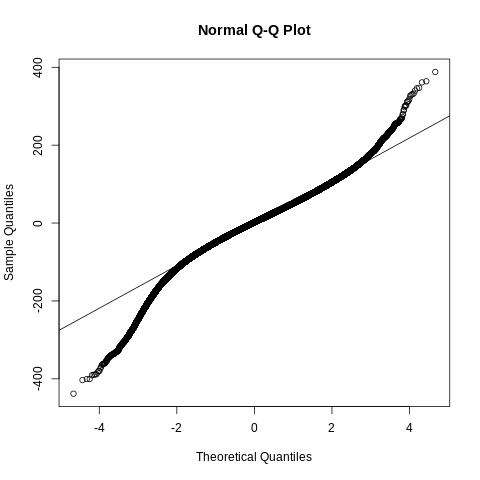

In [ ]:
%%R
qqnorm(residuals(fit.1a))
abline(0,sd(residuals(fit.1a)))

In [ ]:
%%R
confint(fit.1a)

                           2.5 %      97.5 %    Estimate
(Intercept)          327.7283968 368.9460776 348.3372372
fDimCat3              17.5915053  19.4173550  18.5044302
fDimCat4              31.3218017  33.2608042  32.2913029
fDimCat5              41.0974872  43.5021393  42.2998133
fDimCat6              42.0284327  45.2554952  43.6419639
fLactationNumberCat2  20.3694077  25.4352707  22.9023392
fLactationNumberCat3  27.9241701  37.4702459  32.6972080
fLactationNumberCat4  39.4285874  53.5053141  46.4669507
fLactationNumberCat5  41.4698939  60.1311361  50.8005150
fLactationNumberCat6  55.9011497  79.2810462  67.5910980
fLactationNumberCat7  52.3168457  80.3233320  66.3200889
fLactationNumberCat8  34.7929335  67.9865812  51.3897574
fThiMeanCat0          -3.4800779   2.8215712  -0.3292533
fThiMeanCat2          -4.8363595  -3.3850319  -4.1106957
fThiMeanCat3         -10.9024856  -9.2469960 -10.0747408
fThiMeanCat4         -18.2377405 -16.2900300 -17.2638853
fThiMeanCat5         -41.854028

In [ ]:
%%R
rm(fit.1a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2430194  129.8    5603605  299.3   4508150  240.8
Vcells 131677704 1004.7  239150143 1824.6 239150143 1824.6


### CMS parity (0-1)

In [ ]:
%%R
##CMS with Parity included in the model (1 vs > 1)

fit.1bb <- glmmTMB(SensorValue ~ fDimCat + Parity + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model1bb <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMeanCMS_par.R'
save(fit.1bb, file= url_model1bb)
summary(fit.1bb)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + Parity + fThiMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7106186  7106573 -3553059  7106118   640918 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.646e+04 162.6767       
              Day         3.576e-02   0.1891 -0.78 
 Residual                 3.738e+03  61.1397       
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.74e+03 

Conditional model:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         311.4634     7.7017   40.44  < 2e-16 ***
fDimCat3             10.5659     0.3574   29.56  < 2e-16 ***
fDimCat4             19.0172     0.3404   55.86  < 2e-16 ***
fDimCat5             29.0681     0.3394   85.65  < 2e-16 ***
fDimCat6             31.3697     0.3463   

In [ ]:
%%R
drop1(fit.1bb)

Single term deletions

Model:
SensorValue ~ fDimCat + Parity + fThiMeanCat + fYear + fMonth + 
    fHerdIdentifier + (1 + Day | AnimalEartag)
                Df     AIC
<none>             7106186
fDimCat          4 7117982
Parity           1 7106676
fThiMeanCat      6 7125923
fYear            3 7107396
fMonth          11 7142518
fHerdIdentifier  4 7106226


### CMS Parity (0-1) and interaction

In [ ]:
%%R
##CMS with Parity (1 vs > 1) and interaction ThiMean and Parity (1 vs >1)
fit.1bbi <- glmmTMB(SensorValue ~ fDimCat + Parity + fThiMeanCat:Parity + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model1bbi <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMeanCMS_int.R'
save(fit.1bbi, file= url_model1bbi)
summary(fit.1bbi)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + Parity + fThiMeanCat:Parity + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7106031  7106486 -3552976  7105951   640912 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.655e+04 162.9271       
              Day         3.585e-02   0.1894 -0.78 
 Residual                 3.737e+03  61.1315       
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.74e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          310.7026     7.7051   40.32  < 2e-16 ***
fDimCat3              10.5366     0.3574   29.48  < 2e-16 ***
fDimCat4              18.9509     0.3405   55.66  < 2e-16 ***
fDimCat5              29.0038     0.3394   85.45  < 2e-16 ***
fDimCat6              31.3437 

In [ ]:
%%R
drop1(fit.1bbi)

Single term deletions

Model:
SensorValue ~ fDimCat + Parity + fThiMeanCat:Parity + fYear + 
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
                   Df     AIC
<none>                7106031
fDimCat             4 7117804
fYear               3 7107243
fMonth             11 7142416
fHerdIdentifier     4 7106071
Parity:fThiMeanCat 12 7125923


### CMS Parity (1-8)

In [ ]:
%%R
##CMS with Parity (1-8) included in the model= "fLactationNumberCat"
fit.1b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model1b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMeanCMS.R'
save(fit.1b, file= url_model1b)
summary(fit.1b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7104692  7105146 -3552306  7104612   640912 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.859e+04 169.0858       
              Day         3.653e-02   0.1911 -0.81 
 Residual                 3.729e+03  61.0676       
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.73e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          323.1791     7.7545   41.68  < 2e-16 ***
fDimCat3               9.8339     0.3606   27.27  < 2e-16 ***
fDimCat4              16.9832     0.3657   46.44  < 2e-16 ***
fDimCat5              25.2234     0.4240   59.49  < 2e-16 ***
fDimCat6              25

In [ ]:
%%R
drop1(fit.1b)

Single term deletions

Model:
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + 
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
                    Df     AIC
<none>                 7104692
fDimCat              4 7108553
fLactationNumberCat  7 7106676
fThiMeanCat          6 7124476
fYear                3 7106289
fMonth              11 7140844
fHerdIdentifier      4 7104735


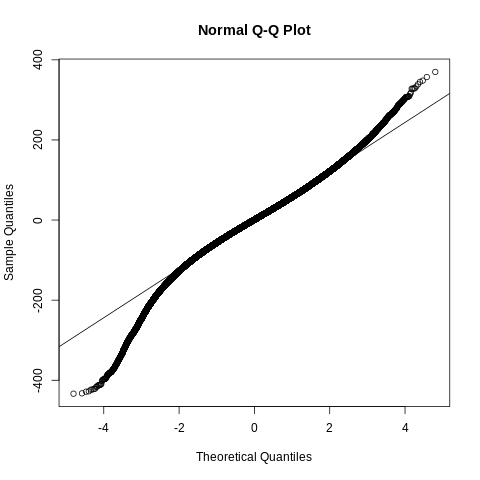

In [ ]:
%%R
qqnorm(residuals(fit.1b))
abline(0,sd(residuals(fit.1b)))

In [ ]:
%%R
confint(fit.1b)

                           2.5 %      97.5 %    Estimate
(Intercept)          307.9806125 338.3775661 323.1790893
fDimCat3               9.1271312  10.5406098   9.8338705
fDimCat4              16.2663846  17.7000105  16.9831975
fDimCat5              24.3924238  26.0544411  25.2234325
fDimCat6              24.1185760  26.2225623  25.1705691
fLactationNumberCat2 -24.5780632 -21.5055094 -23.0417863
fLactationNumberCat3 -43.0228219 -37.3126763 -40.1677491
fLactationNumberCat4 -56.5033238 -48.1337088 -52.3185163
fLactationNumberCat5 -49.6039076 -38.4586318 -44.0312697
fLactationNumberCat6 -51.0419871 -36.7775542 -43.9097707
fLactationNumberCat7 -56.8669396 -39.1419330 -48.0044363
fLactationNumberCat8 -50.2605448 -28.5285556 -39.3945502
fThiMeanCat0          -0.2592155   2.4488630   1.0948237
fThiMeanCat2          -1.9648112  -0.8280201  -1.3964156
fThiMeanCat3          -5.6438719  -4.3076405  -4.9757562
fThiMeanCat4         -22.5681496 -21.0738809 -21.8210153
fThiMeanCat5         -52.113403

In [ ]:
%%R
rm(fit.1b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2750081  146.9    6919662  369.6   6120244  326.9
Vcells 225418541 1719.9  435817749 3325.1 435817749 3325.1


In [ ]:
%%R
##DRY 
fit.1c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model1c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMeanDRY.R'
save(fit.1c, file= url_model1c)
summary(fit.1c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811366.7  811725.0 -405644.4  811288.7     72062 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.162e+04 107.7783       
              Day         1.723e-02   0.1313 -0.81 
 Residual                 3.919e+03  62.6004       
Number of obs: 72101, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.92e+03 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           374.1701     5.6191   66.59  < 2e-16 ***
fLactationNumberCat2   16.7731     1.8328    9.15  < 2e-16 ***
fLactationNumberCat3   -8.1850     2.6163   -3.13  0.00176 ** 
fLactationNumberCat4  -31.2119     3.2174   -9.70  < 2e-16 ***
fLactationNumberCat5

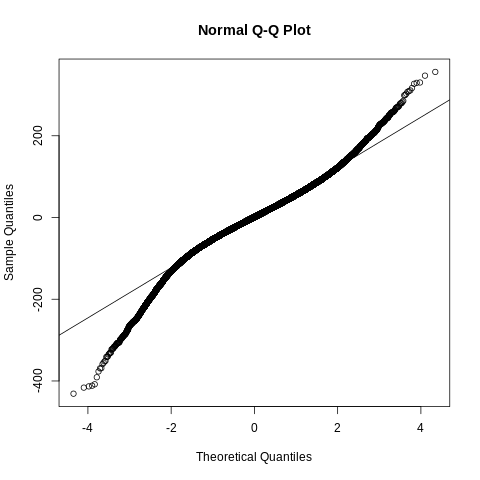

In [ ]:
%%R
qqnorm(residuals(fit.1c))
abline(0,sd(residuals(fit.1c)))

In [ ]:
%%R
confint(fit.1c)

                            2.5 %      97.5 %     Estimate
(Intercept)           363.1567767 385.1833472  374.1700620
fLactationNumberCat2   13.1808558  20.3654002   16.7731280
fLactationNumberCat3  -13.3127439  -3.0571953   -8.1849696
fLactationNumberCat4  -37.5178430 -24.9059194  -31.2118812
fLactationNumberCat5  -66.5212965 -51.5458554  -59.0335759
fLactationNumberCat6  -67.2091732 -49.1843271  -58.1967501
fLactationNumberCat7  -92.2929004 -69.0538744  -80.6733874
fLactationNumberCat8 -129.9918472 -98.6396920 -114.3157696
fThiMeanCat0           -1.4891246   8.2819495    3.3964125
fThiMeanCat2           -1.2292455   2.4613384    0.6160464
fThiMeanCat3           -3.9279018   0.2985706   -1.8146656
fThiMeanCat4           -8.8097445  -4.0597608   -6.4347526
fThiMeanCat5          -25.0388789 -18.4440766  -21.7414777
fThiMeanCat6          -46.0828915 -36.4287858  -41.2558387
fYear2018             -32.7263237 -26.0415728  -29.3839483
fYear2019             -46.5690839 -35.1794628  -40.87427

In [ ]:
%%R
rm(fit.1c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2777745  148.4    6543606  349.5   6274665  335.2
Vcells 279135141 2129.7  679671350 5185.5 634771984 4843.0


## Model THI max

In [ ]:
%%R
##AMS
fit.2a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model2a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMaxAMS.R'
save(fit.2a, file= url_model2a)
summary(fit.2a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3517833  3518239 -1758878  3517757   323305 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.081e+04 202.0105       
              Day         4.362e-02   0.2088 -0.75 
 Residual                 3.029e+03  55.0369       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.03e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          343.9304    10.4528   32.90  < 2e-16 ***
fDimCat3              18.4731     0.4680   39.47  < 2e-16 ***
fDimCat4              32.1709     0.4965   64.79  < 2e-16 ***
fDimCat5              42.0665     0.6152   68.38  < 2e-16 ***
fDimCat6              43.2

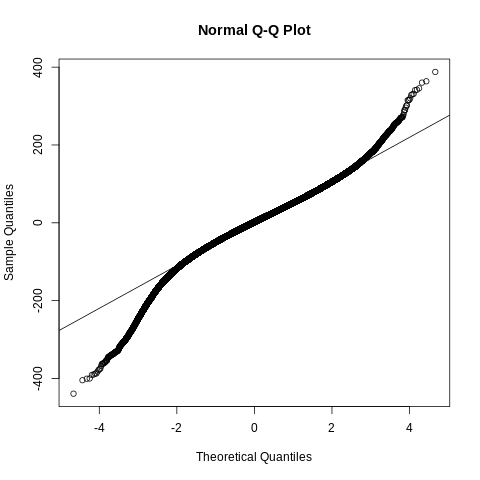

In [ ]:
%%R
qqnorm(residuals(fit.2a))
abline(0,sd(residuals(fit.2a)))

In [ ]:
%%R
confint(fit.2a)

                           2.5 %      97.5 %    Estimate
(Intercept)          323.4433406 364.4174493 343.9303950
fDimCat3              17.5558530  19.3903254  18.4730892
fDimCat4              31.1977316  33.1441038  32.1709177
fDimCat5              40.8607217  43.2722031  42.0664624
fDimCat6              41.6510964  44.8847286  43.2679125
fLactationNumberCat2  19.3402961  24.4168628  21.8785794
fLactationNumberCat3  25.7672349  35.3304311  30.5488330
fLactationNumberCat4  36.3518484  50.4515465  43.4016974
fLactationNumberCat5  37.3997992  56.0898871  46.7448431
fLactationNumberCat6  51.0175130  74.4336961  62.7256046
fLactationNumberCat7  46.6763979  74.7286595  60.7025287
fLactationNumberCat8  28.4550060  61.7095873  45.0822966
fThiMaxCat0          -10.8678769  11.1598135   0.1459683
fThiMaxCat2           -3.6955581  -2.1250637  -2.9103109
fThiMaxCat3           -2.8383633  -1.0883602  -1.9633617
fThiMaxCat4           -4.4037344  -2.5469546  -3.4753445
fThiMaxCat5           -9.331056

In [ ]:
%%R
rm(fit.2a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2421576  129.4    6361872  339.8   5584685  298.3
Vcells 199757705 1524.1  414213759 3160.3 344560477 2628.8


In [ ]:
%%R
##CMS 
fit.2b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model2b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMaxCMS.R'
save(fit.2b, file= url_model2b)
summary(fit.2b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7107295  7107750 -3553608  7107215   640912 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 28514.470 168.8623       
              Day             0.036   0.1897 -0.81 
 Residual                  3744.650  61.1935       
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.74e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          320.2823     7.7400   41.38  < 2e-16 ***
fDimCat3               9.8277     0.3613   27.20  < 2e-16 ***
fDimCat4              16.9509     0.3664   46.26  < 2e-16 ***
fDimCat5              25.1630     0.4246   59.26  < 2e-16 ***
fDimCat6              25.

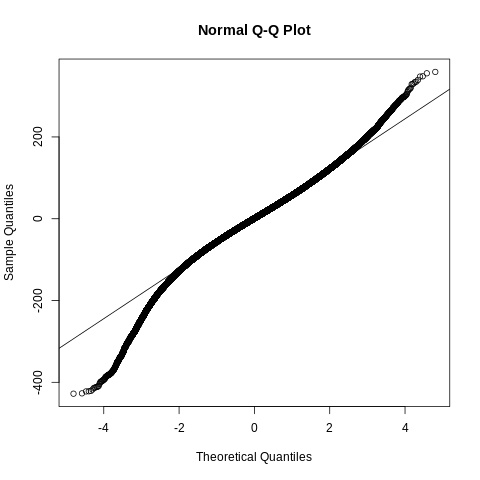

In [ ]:
%%R
qqnorm(residuals(fit.2b))
abline(0,sd(residuals(fit.2b)))

In [ ]:
%%R
confint(fit.2b)

                           2.5 %       97.5 %    Estimate
(Intercept)          305.1122410 335.45242975 320.2823354
fDimCat3               9.1195173  10.53588839   9.8277028
fDimCat4              16.2327357  17.66907418  16.9509049
fDimCat5              24.3307520  25.99527556  25.1630138
fDimCat6              24.0045004  26.11083220  25.0576663
fLactationNumberCat2 -24.7283294 -21.65267762 -23.1905035
fLactationNumberCat3 -43.4629213 -37.74834470 -40.6056330
fLactationNumberCat4 -57.2937402 -48.91877896 -53.1062596
fLactationNumberCat5 -50.9417322 -39.79057732 -45.3661547
fLactationNumberCat6 -52.8423965 -38.57121396 -45.7068053
fLactationNumberCat7 -59.0558163 -41.32202243 -50.1889194
fLactationNumberCat8 -52.8701572 -31.12461380 -41.9973855
fThiMaxCat0           -1.5830470   5.60241559   2.0096843
fThiMaxCat2           -3.1370038  -1.91344244  -2.5252231
fThiMaxCat3           -2.3625435  -0.98222930  -1.6723864
fThiMaxCat4            1.1517588   2.60360937   1.8776841
fThiMaxCat5   

In [ ]:
%%R
rm(fit.2b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2739354  146.3    6361872  339.8   5584685  298.3
Vcells 215680456 1645.6  414213759 3160.3 402538069 3071.2


In [ ]:
%%R
##DRY 
fit.2c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model2c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMaxDRY.R'
save(fit.2c, file= url_model2c)
summary(fit.2c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMaxCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811475.4  811833.7 -405698.7  811397.4     72062 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.161e+04 107.7388       
              Day         1.722e-02   0.1312 -0.81 
 Residual                 3.925e+03  62.6511       
Number of obs: 72101, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.93e+03 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           374.3777     5.6125   66.70  < 2e-16 ***
fLactationNumberCat2   16.7004     1.8326    9.11  < 2e-16 ***
fLactationNumberCat3   -8.2171     2.6154   -3.14 0.001679 ** 
fLactationNumberCat4  -31.2775     3.2158   -9.73  < 2e-16 ***
fLactationNumberCat5 

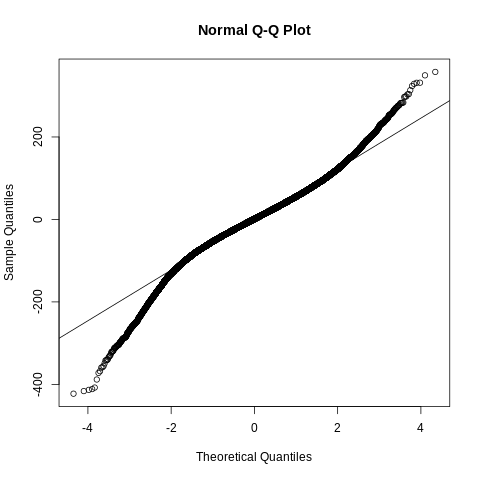

In [ ]:
%%R
qqnorm(residuals(fit.2c))
abline(0,sd(residuals(fit.2c)))

In [ ]:
%%R
confint(fit.2c)

                            2.5 %      97.5 %     Estimate
(Intercept)           363.3774379 385.3779889  374.3777134
fLactationNumberCat2   13.1084847  20.2923299   16.7004073
fLactationNumberCat3  -13.3431868  -3.0910611   -8.2171239
fLactationNumberCat4  -37.5803355 -24.9746249  -31.2774802
fLactationNumberCat5  -66.5802553 -51.6136083  -59.0969318
fLactationNumberCat6  -67.0985219 -49.0840029  -58.0912624
fLactationNumberCat7  -92.4116165 -69.1860529  -80.7988347
fLactationNumberCat8 -130.8131747 -99.4771638 -115.1451692
fThiMaxCat0            12.3724273  39.1053498   25.7388885
fThiMaxCat2            -2.5529230   1.5059355   -0.5234937
fThiMaxCat3            -3.6699859   0.9049986   -1.3824937
fThiMaxCat4             0.3882218   5.2572541    2.8227379
fThiMaxCat5            -2.1474233   2.9459859    0.3992813
fThiMaxCat6           -17.9019301 -12.3213067  -15.1116184
fYear2018             -32.5061745 -25.8218309  -29.1640027
fYear2019             -46.5632064 -35.1796623  -40.87143

In [ ]:
%%R
rm(fit.2c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2170653  116.0    6361872  339.8   5584685  298.3
Vcells 188336702 1436.9  414213759 3160.3 402538069 3071.2


## Model THI min

In [ ]:
%%R
##AMS
fit.3a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model3a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIminAMS.R'
save(fit.3a, file= url_model3a)
summary(fit.3a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3516145  3516551 -1758035  3516069   323305 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.209e+04 205.1469       
              Day         4.422e-02   0.2103 -0.75 
 Residual                 3.013e+03  54.8905       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.01e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          342.9521    10.5873   32.39  < 2e-16 ***
fDimCat3              18.4891     0.4669   39.60  < 2e-16 ***
fDimCat4              32.3668     0.4958   65.28  < 2e-16 ***
fDimCat5              42.2504     0.6149   68.71  < 2e-16 ***
fDimCat6              43.4

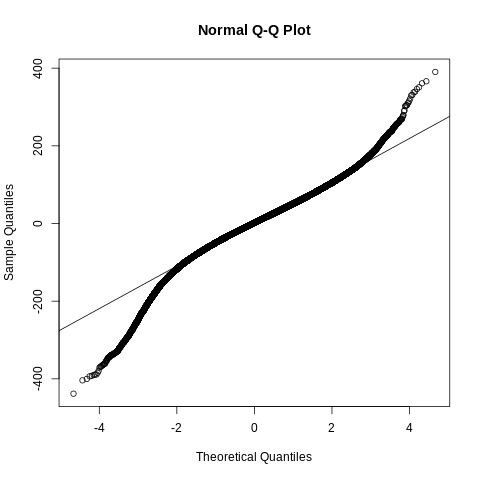

In [ ]:
%%R
qqnorm(residuals(fit.3a))
abline(0,sd(residuals(fit.3a)))

In [ ]:
%%R
confint(fit.3a)

                           2.5 %      97.5 %    Estimate
(Intercept)          322.2012724 363.7029059 342.9520891
fDimCat3              17.5741013  19.4041332  18.4891173
fDimCat4              31.3950988  33.3385277  32.3668132
fDimCat5              41.0453272  43.4555611  42.2504442
fDimCat6              41.8081415  45.0426744  43.4254080
fLactationNumberCat2  20.5838017  25.6631746  23.1234882
fLactationNumberCat3  28.6547401  38.2265524  33.4406463
fLactationNumberCat4  40.2555372  54.3694916  47.3125144
fLactationNumberCat5  42.1562759  60.8659459  51.5111109
fLactationNumberCat6  56.2339474  79.6732857  67.9536166
fLactationNumberCat7  51.9710022  80.0468655  66.0089338
fLactationNumberCat8  33.6749361  66.9488136  50.3118749
fThiMinCat0           -1.7037549   0.4027130  -0.6505209
fThiMinCat2           -5.0780678  -3.7349382  -4.4065030
fThiMinCat3          -12.1867894 -10.6352337 -11.4110115
fThiMinCat4          -14.9060549 -13.1904116 -14.0482333
fThiMinCat5          -26.424997

In [ ]:
%%R
rm(fit.3a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2421614  129.4    6361872  339.8   5584685  298.3
Vcells 199757773 1524.1  414213759 3160.3 402538069 3071.2


In [ ]:
%%R
##CMS 
fit.3b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model3b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMinCMS.R'
save(fit.3b, file= url_model3b)
summary(fit.3b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7113657  7114112 -3556788  7113577   640912 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.798e+04 167.2624       
              Day         3.575e-02   0.1891 -0.80 
 Residual                 3.782e+03  61.5001       
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.78e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          320.3060     7.6920   41.64  < 2e-16 ***
fDimCat3               9.9541     0.3631   27.41  < 2e-16 ***
fDimCat4              17.0086     0.3680   46.21  < 2e-16 ***
fDimCat5              25.2856     0.4262   59.33  < 2e-16 ***
fDimCat6              25.

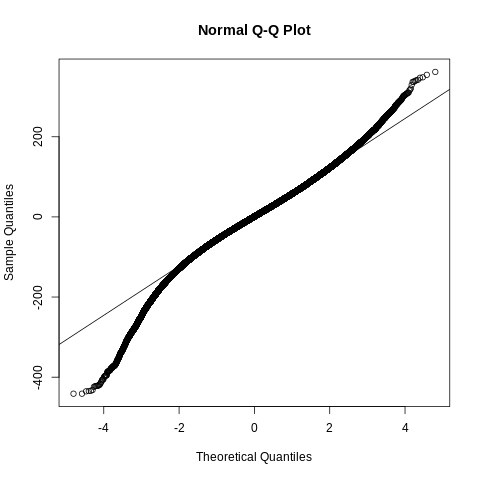

In [ ]:
%%R
qqnorm(residuals(fit.3b))
abline(0,sd(residuals(fit.3b)))

In [ ]:
%%R
confint(fit.3b)

                           2.5 %      97.5 %    Estimate
(Intercept)          305.2300364 335.3819499 320.3059931
fDimCat3               9.2424386  10.6657491   9.9540938
fDimCat4              16.2873066  17.7299911  17.0086488
fDimCat5              24.4503054  26.1208460  25.2855757
fDimCat6              24.1468792  26.2594273  25.2031532
fLactationNumberCat2 -24.4109961 -21.3268103 -22.8689032
fLactationNumberCat3 -42.9017756 -37.1730340 -40.0374048
fLactationNumberCat4 -56.5623378 -48.1679548 -52.3651463
fLactationNumberCat5 -49.9912927 -38.8148479 -44.4030703
fLactationNumberCat6 -51.8472440 -37.5429126 -44.6950783
fLactationNumberCat7 -58.2813281 -40.5033483 -49.3923382
fLactationNumberCat8 -52.4835565 -30.6773000 -41.5804283
fThiMinCat0            0.1404840   1.3939960   0.7672400
fThiMinCat2           -4.4976690  -3.4531211  -3.9753951
fThiMinCat3          -12.0325686 -10.8442450 -11.4384068
fThiMinCat4          -16.3937532 -15.0676968 -15.7307250
fThiMinCat5          -30.228829

In [ ]:
%%R
rm(fit.3b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2739387  146.3    6361872  339.8   5584685  298.3
Vcells 215680519 1645.6  414213759 3160.3 402538069 3071.2


In [ ]:
%%R
##DRY 
fit.3c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model3c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMinDRY.R'
save(fit.3c, file= url_model3c)
summary(fit.3c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMinCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811489.6  811847.8 -405705.8  811411.6     72062 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.163e+04 107.8322       
              Day         1.729e-02   0.1315 -0.81 
 Residual                 3.926e+03  62.6541       
Number of obs: 72101, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.93e+03 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           374.0041     5.6230   66.51  < 2e-16 ***
fLactationNumberCat2   16.8055     1.8344    9.16  < 2e-16 ***
fLactationNumberCat3   -8.4728     2.6178   -3.24  0.00121 ** 
fLactationNumberCat4  -31.1561     3.2194   -9.68  < 2e-16 ***
fLactationNumberCat5 

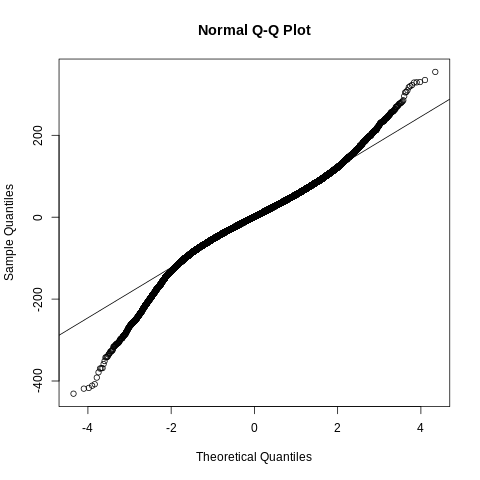

In [ ]:
%%R
qqnorm(residuals(fit.3c))
abline(0,sd(residuals(fit.3c)))

In [ ]:
%%R
confint(fit.3c)

                            2.5 %      97.5 %     Estimate
(Intercept)           362.9832157 385.0249754  374.0040955
fLactationNumberCat2   13.2101107  20.4007932   16.8054520
fLactationNumberCat3  -13.6036460  -3.3419330   -8.4727895
fLactationNumberCat4  -37.4659157 -24.8462679  -31.1560918
fLactationNumberCat5  -66.2191118 -51.2350770  -58.7270944
fLactationNumberCat6  -66.8748608 -48.8398004  -57.8573306
fLactationNumberCat7  -92.6160975 -69.3677927  -80.9919451
fLactationNumberCat8 -130.7386382 -99.3726064 -115.0556223
fThiMinCat0            -0.5774103   4.0209215    1.7217556
fThiMinCat2            -0.9018097   2.4196010    0.7588956
fThiMinCat3            -7.2940096  -3.5938847   -5.4439472
fThiMinCat4           -11.3192201  -7.2389739   -9.2790970
fThiMinCat5           -17.9018330 -12.4780632  -15.1899481
fThiMinCat6           -38.7484079 -29.5863300  -34.1673690
fYear2018             -33.4892649 -26.8024480  -30.1458565
fYear2019             -47.0105855 -35.6080662  -41.30932

In [ ]:
%%R
rm(fit.3c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2170691  116.0    6361872  339.8   5584685  298.3
Vcells 188336776 1436.9  414213759 3160.3 402538069 3071.2


## Model THI mean 1 day before

In [ ]:
%%R
##AMS
fit.4a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model4a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMean1daybeforeAMS.R'
save(fit.4a, file= url_model4a)
summary(fit.4a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3514609  3515015 -1757267  3514533   323305 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.135e+04 203.3479       
              Day         4.347e-02   0.2085 -0.75 
 Residual                 2.999e+03  54.7605       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3e+03 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            349.1305    10.4964   33.26  < 2e-16 ***
fDimCat3                18.5348     0.4657   39.80  < 2e-16 ***
fDimCat4                32.3157     0.4946   65.34  < 2e-16 ***
fDimCat5                42.3191     0.6133   69.00  < 2e-16 ***
fDimCat6

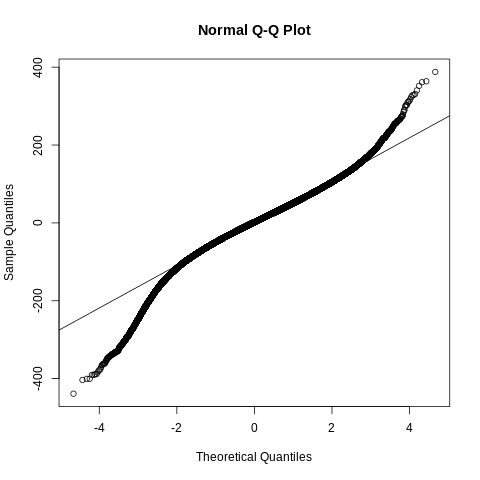

In [ ]:
%%R
qqnorm(residuals(fit.4a))
abline(0,sd(residuals(fit.4a)))

In [ ]:
%%R
confint(fit.4a)

                             2.5 %      97.5 %    Estimate
(Intercept)            328.5579346 369.7030214 349.1304780
fDimCat3                17.6220035  19.4476883  18.5348459
fDimCat4                31.3463421  33.2850089  32.3156755
fDimCat5                41.1170502  43.5211427  42.3190964
fDimCat6                42.0487661  45.2748938  43.6618299
fLactationNumberCat2    20.3394764  25.4039800  22.8717282
fLactationNumberCat3    27.9243667  37.4676730  32.6960199
fLactationNumberCat4    39.4667384  53.5391078  46.5029231
fLactationNumberCat5    41.5297926  60.1851034  50.8574480
fLactationNumberCat6    55.9747508  79.3470844  67.6609176
fLactationNumberCat7    52.3976829  80.3952269  66.3964549
fLactationNumberCat8    34.8606960  68.0440597  51.4523779
fThiMean1daybeforeCat0  -2.4254540   3.8650961   0.7198210
fThiMean1daybeforeCat2  -6.4971904  -5.0510051  -5.7740977
fThiMean1daybeforeCat3 -12.7935346 -11.1274125 -11.9604736
fThiMean1daybeforeCat4 -19.3880212 -17.4325194 -18.41027

In [ ]:
%%R
rm(fit.4a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2421784  129.4    6361872  339.8   5584685  298.3
Vcells 199759313 1524.1  414213759 3160.3 402538069 3071.2


In [ ]:
%%R
##CMS 
fit.4b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model4b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelThiMean1daybeforeCMS.R'
save(fit.4b, file= url_model4b)
summary(fit.4b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7105326  7105780 -3552623  7105246   640793 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.837e+04 168.4340       
              Day         3.615e-02   0.1901 -0.80 
 Residual                 3.741e+03  61.1620       
Number of obs: 640833, groups:  AnimalEartag, 1275

Dispersion estimate for gaussian family (sigma^2): 3.74e+03 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            320.4376     7.7480   41.36  < 2e-16 ***
fDimCat3                 9.8256     0.3612   27.21  < 2e-16 ***
fDimCat4                16.9544     0.3663   46.29  < 2e-16 ***
fDimCat5                25.1743     0.4245   59.30  < 2e-16 ***
fDim

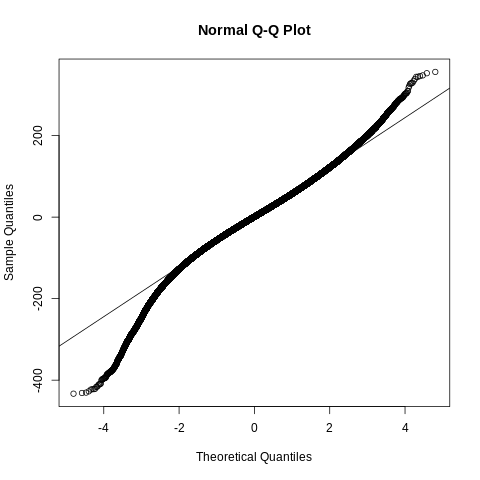

In [ ]:
%%R
qqnorm(residuals(fit.4b))
abline(0,sd(residuals(fit.4b)))

In [ ]:
%%R
confint(fit.4b)

                             2.5 %       97.5 %    Estimate
(Intercept)            305.2519315 335.62335358 320.4376426
fDimCat3                 9.1177678  10.53350699   9.8256374
fDimCat4                16.2365730  17.67232351  16.9544483
fDimCat5                24.3422288  26.00631411  25.1742715
fDimCat6                24.0385310  26.14460704  25.0915690
fLactationNumberCat2   -24.6214830 -21.54605834 -23.0837707
fLactationNumberCat3   -43.2079118 -37.49326904 -40.3505904
fLactationNumberCat4   -56.8924227 -48.51677186 -52.7045973
fLactationNumberCat5   -50.3006838 -39.14779510 -44.7242395
fLactationNumberCat6   -52.0237742 -37.74954850 -44.8866613
fLactationNumberCat7   -58.0915669 -40.35403998 -49.2228035
fLactationNumberCat8   -51.8050554 -30.05611623 -40.9305858
fThiMean1daybeforeCat0   3.5897852   6.31121276   4.9504990
fThiMean1daybeforeCat2  -2.6114559  -1.47332861  -2.0423922
fThiMean1daybeforeCat3  -6.6897705  -5.34155746  -6.0156640
fThiMean1daybeforeCat4 -24.6127433 -23.1

In [ ]:
%%R
rm(fit.4b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2739436  146.4    6361872  339.8   5608914  299.6
Vcells 215996944 1648.0  414213759 3160.3 404762983 3088.1


In [ ]:
%%R
##DRY 
fit.4c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model4c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMean1daybeforeDRY.R'
save(fit.4c, file= url_model4c)
summary(fit.4c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMean1daybeforeCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811164.7  811522.9 -405543.3  811086.7     72052 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.161e+04 107.7468       
              Day         1.722e-02   0.1312 -0.81 
 Residual                 3.914e+03  62.5602       
Number of obs: 72091, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.91e+03 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             374.5691     5.6186   66.67  < 2e-16 ***
fLactationNumberCat2     16.7171     1.8323    9.12  < 2e-16 ***
fLactationNumberCat3     -8.2015     2.6159   -3.14  0.00172 ** 
fLactationNumberCat4    -31.1847     3.2172   -9.69  < 2e-16 ***


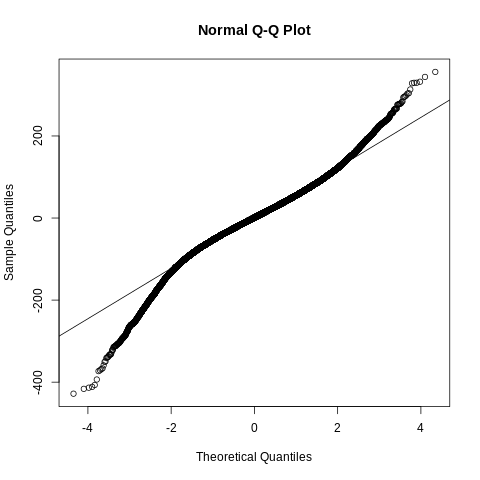

In [ ]:
%%R
qqnorm(residuals(fit.4c))
abline(0,sd(residuals(fit.4c)))

In [ ]:
%%R
confint(fit.4c)

                              2.5 %      97.5 %     Estimate
(Intercept)             363.5568337 385.5813511  374.5690924
fLactationNumberCat2     13.1259878  20.3082919   16.7171398
fLactationNumberCat3    -13.3285661  -3.0744717   -8.2015189
fLactationNumberCat4    -37.4903511 -24.8791165  -31.1847338
fLactationNumberCat5    -66.4088449 -51.4334666  -58.9211557
fLactationNumberCat6    -66.9615658 -48.9358448  -57.9487053
fLactationNumberCat7    -92.1576710 -68.9185635  -80.5381173
fLactationNumberCat8   -129.6837003 -98.3330280 -114.0083642
fThiMean1daybeforeCat0   -0.7641829   8.9471868    4.0915019
fThiMean1daybeforeCat2   -4.0637158  -0.3676778   -2.2156968
fThiMean1daybeforeCat3   -7.7045837  -3.4500552   -5.5773195
fThiMean1daybeforeCat4  -14.8093499 -10.0424842  -12.4259171
fThiMean1daybeforeCat5  -25.7431668 -19.1511111  -22.4471389
fThiMean1daybeforeCat6  -53.9635588 -44.2245915  -49.0940751
fYear2018               -32.5510398 -25.8676770  -29.2093584
fYear2019               

In [ ]:
%%R
rm(fit.4c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2170854  116.0    6361872  339.8   5608914  299.6
Vcells 188373904 1437.2  414213759 3160.3 404762983 3088.1


##Model THI mean 2 days before

In [ ]:
%%R
##AMS
fit.5a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model5a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMean2daysbeforeAMS.R'
save(fit.5a, file= url_model5a)
summary(fit.5a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3516368  3516774 -1758146  3516292   323305 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.121e+04 203.0076       
              Day         4.374e-02   0.2092 -0.75 
 Residual                 3.015e+03  54.9106       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.02e+03 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             345.2293    10.4967   32.89  < 2e-16 ***
fDimCat3                 18.5341     0.4670   39.69  < 2e-16 ***
fDimCat4                 32.2722     0.4957   65.10  < 2e-16 ***
fDimCat5                 42.2051     0.6145   68.68  < 2e-16 ***

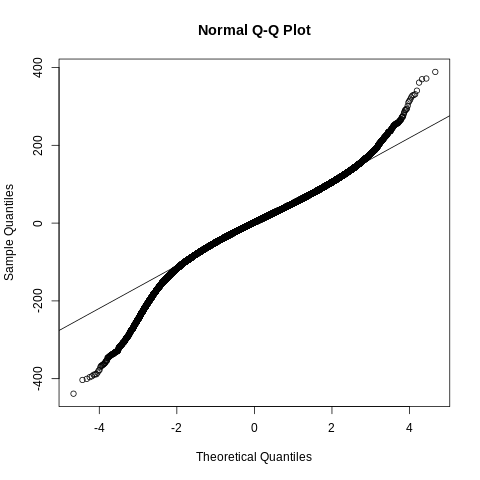

In [ ]:
%%R
qqnorm(residuals(fit.5a))
abline(0,sd(residuals(fit.5a)))

In [ ]:
%%R
confint(fit.5a)

                              2.5 %      97.5 %    Estimate
(Intercept)             324.6561680 365.8025140 345.2293410
fDimCat3                 17.6187949  19.4493465  18.5340707
fDimCat4                 31.3005719  33.2437921  32.2721820
fDimCat5                 41.0006034  43.4095741  42.2050887
fDimCat6                 41.8455394  45.0772648  43.4614021
fLactationNumberCat2     20.0174123  25.0911576  22.5542849
fLactationNumberCat3     27.2733264  36.8329051  32.0531157
fLactationNumberCat4     38.4610422  52.5565087  45.5087755
fLactationNumberCat5     40.1196441  58.8048799  49.4622620
fLactationNumberCat6     54.1804440  77.5900459  65.8852450
fLactationNumberCat7     50.1558979  78.1985793  64.1772386
fLactationNumberCat8     32.1825085  65.4212767  48.8018926
fThiMean2daysbeforeCat0   5.3116708  11.6156941   8.4636824
fThiMean2daysbeforeCat2  -6.4762549  -5.0325297  -5.7543923
fThiMean2daysbeforeCat3 -12.2039086 -10.5311530 -11.3675308
fThiMean2daysbeforeCat4 -17.6230729 -15.

In [ ]:
%%R
rm(fit.5a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2422277  129.4    6361872  339.8   5608914  299.6
Vcells 199764634 1524.1  414213759 3160.3 404762983 3088.1


In [ ]:
%%R
##CMS 
fit.5b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model5b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelThiMean2daysbeforeCMS.R'
save(fit.5b, file= url_model5b)
summary(fit.5b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7108047  7108502 -3553984  7107967   640675 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.834e+04 168.3498       
              Day         3.591e-02   0.1895 -0.81 
 Residual                 3.765e+03  61.3559       
Number of obs: 640715, groups:  AnimalEartag, 1275

Dispersion estimate for gaussian family (sigma^2): 3.76e+03 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             315.6219     7.7519   40.72  < 2e-16 ***
fDimCat3                  9.8480     0.3623   27.18  < 2e-16 ***
fDimCat4                 16.9414     0.3674   46.11  < 2e-16 ***
fDimCat5                 25.1156     0.4257   59.00  < 2e-16 **

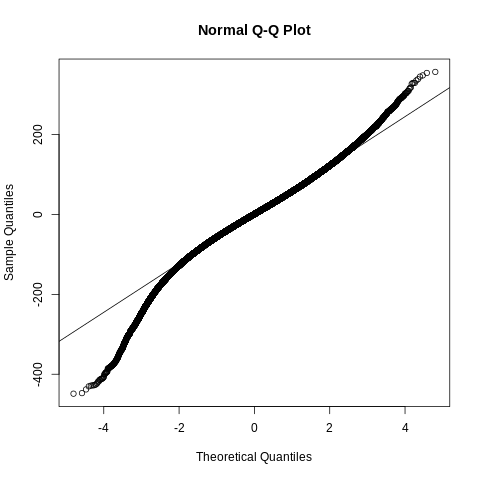

In [ ]:
%%R
qqnorm(residuals(fit.5b))
abline(0,sd(residuals(fit.5b)))

In [ ]:
%%R
confint(fit.5b)

                              2.5 %      97.5 %    Estimate
(Intercept)             300.4285641 330.8152804 315.6219222
fDimCat3                  9.1378400  10.5581431   9.8479915
fDimCat4                 16.2212824  17.6614579  16.9413702
fDimCat5                 24.2811606  25.9499521  25.1155564
fDimCat6                 23.9024235  26.0138783  24.9581509
fLactationNumberCat2    -24.8235186 -21.7403774 -23.2819480
fLactationNumberCat3    -43.6481949 -37.9201420 -40.7841684
fLactationNumberCat4    -57.5611614 -49.1666041 -53.3638828
fLactationNumberCat5    -51.1521446 -39.9746736 -45.5634091
fLactationNumberCat6    -53.0675521 -38.7622208 -45.9148864
fLactationNumberCat7    -59.3622915 -41.5859198 -50.4741057
fLactationNumberCat8    -53.3672671 -31.5690323 -42.4681497
fThiMean2daysbeforeCat0   6.0658254   8.7958253   7.4308253
fThiMean2daysbeforeCat2  -3.3688516  -2.2327362  -2.8007939
fThiMean2daysbeforeCat3  -4.1008781  -2.7443814  -3.4226297
fThiMean2daysbeforeCat4 -15.2924359 -13.

In [ ]:
%%R
rm(fit.5b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2739346  146.3    6361872  339.8   5608914  299.6
Vcells 215991115 1647.9  414213759 3160.3 404762983 3088.1


In [ ]:
%%R
##DRY 
fit.5c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model5c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMean2daysbeforeDRY.R'
save(fit.5c, file= url_model5c)
summary(fit.5c)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811136.2  811494.5 -405529.1  811058.2     72041 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.162e+04 107.7747       
              Day         1.724e-02   0.1313 -0.81 
 Residual                 3.919e+03  62.6034       
Number of obs: 72080, groups:  AnimalEartag, 1882

Dispersion estimate for gaussian family (sigma^2): 3.92e+03 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              374.6761     5.6245   66.61  < 2e-16 ***
fLactationNumberCat2      16.7027     1.8329    9.11  < 2e-16 ***
fLactationNumberCat3      -8.3050     2.6166   -3.17   0.0015 ** 
fLactationNumberCat4     -31.3790     3.2176   -9.75  < 2e-16

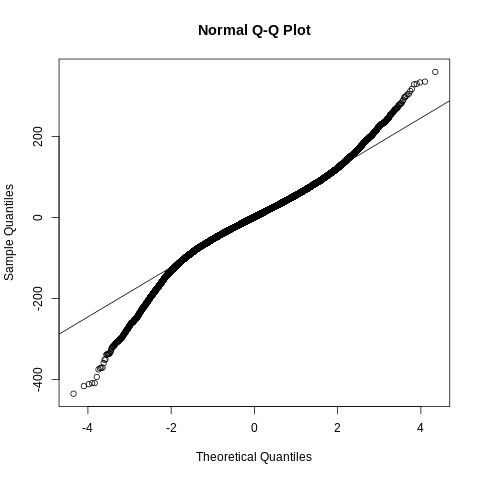

In [ ]:
%%R
qqnorm(residuals(fit.5c))
abline(0,sd(residuals(fit.5c)))

In [ ]:
%%R
confint(fit.5c)

                               2.5 %      97.5 %     Estimate
(Intercept)              363.6522575 385.6999807  374.6761191
fLactationNumberCat2      13.1103760  20.2950285   16.7027023
fLactationNumberCat3     -13.4333937  -3.1766782   -8.3050359
fLactationNumberCat4     -37.6852634 -25.0726495  -31.3789565
fLactationNumberCat5     -66.4914961 -51.5153066  -59.0034013
fLactationNumberCat6     -66.9813721 -48.9535291  -57.9674506
fLactationNumberCat7     -92.2222517 -68.9791003  -80.6006760
fLactationNumberCat8    -129.8830674 -98.5252331 -114.2041502
fThiMean2daysbeforeCat0    0.7432865  10.4755806    5.6094335
fThiMean2daysbeforeCat2   -5.5946815  -1.8946533   -3.7446674
fThiMean2daysbeforeCat3   -7.7272925  -3.4615335   -5.5944130
fThiMean2daysbeforeCat4  -12.2873022  -7.5030558   -9.8951790
fThiMean2daysbeforeCat5  -25.5068227 -18.9060047  -22.2064137
fThiMean2daysbeforeCat6  -49.4917977 -39.6603533  -44.5760755
fYear2018                -32.7950528 -26.1071727  -29.4511127
fYear201

In [ ]:
%%R
rm(fit.5c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2170863  116.0    6361872  339.8   5608914  299.6
Vcells 188373224 1437.2  414213759 3160.3 404762983 3088.1


## Model Temp mean

In [ ]:
%%R
##AMS
fit.6a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model6a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMeanAMS.R'
save(fit.6a, file= url_model6a)
summary(fit.6a)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3515463  3515869 -1757694  3515387   323305 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.103e+04 202.5629       
              Day         4.348e-02   0.2085 -0.75 
 Residual                 3.007e+03  54.8338       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.01e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          346.0281    10.4842   33.00  < 2e-16 ***
fDimCat3              18.4345     0.4663   39.53  < 2e-16 ***
fDimCat4              32.2427     0.4951   65.13  < 2e-16 ***
fDimCat5              42.1829     0.6138   68.72  < 2e-16 ***
fDimCat6              43.

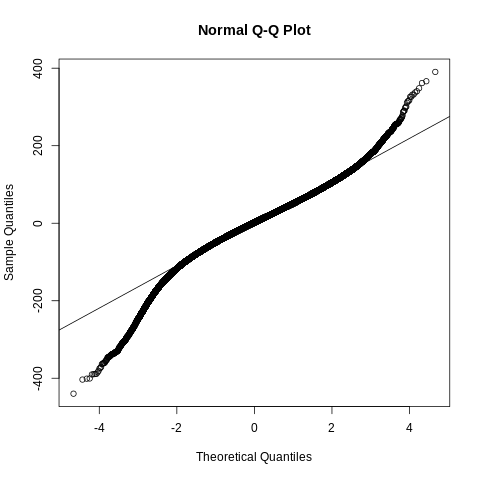

In [ ]:
%%R
qqnorm(residuals(fit.6a))
abline(0,sd(residuals(fit.6a)))

In [ ]:
%%R
confint(fit.6a)

                           2.5 %      97.5 %    Estimate
(Intercept)          325.4794019 366.5767981 346.0281000
fDimCat3              17.5204565  19.3484472  18.4344519
fDimCat4              31.2723623  33.2130259  32.2426941
fDimCat5              40.9798099  43.3859083  42.1828591
fDimCat6              41.8754449  45.1036910  43.4895680
fLactationNumberCat2  20.0499877  25.1183338  22.5841608
fLactationNumberCat3  27.1818001  36.7312648  31.9565325
fLactationNumberCat4  38.2959408  52.3764572  45.3361990
fLactationNumberCat5  39.8278310  58.4933854  49.1606082
fLactationNumberCat6  53.7534710  77.1387634  65.4461172
fLactationNumberCat7  49.9027321  77.9165721  63.9096521
fLactationNumberCat8  32.0387606  65.2438063  48.6412835
fTempMeanCat0          0.2200834   2.9335194   1.5768014
fTempMeanCat2         -5.3410796  -3.9161751  -4.6286274
fTempMeanCat3        -12.4608832 -10.7538382 -11.6073607
fTempMeanCat4        -30.7082710 -28.4630101 -29.5856405
fTempMeanCat5        -57.788508

In [ ]:
%%R
rm(fit.6a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2422300  129.4    6361872  339.8   5608914  299.6
Vcells 199764514 1524.1  414213759 3160.3 404762983 3088.1


In [ ]:
%%R
##CMS 
fit.6b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model6b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMeanCMS.R'
save(fit.6b, file= url_model6b)
summary(fit.6b)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7102959  7103414 -3551440  7102879   640912 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.862e+04 169.173        
              Day         3.648e-02   0.191  -0.81 
 Residual                 3.719e+03  60.985        
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.72e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          322.4002     7.7548   41.57  < 2e-16 ***
fDimCat3               9.7860     0.3601   27.18  < 2e-16 ***
fDimCat4              17.0012     0.3653   46.55  < 2e-16 ***
fDimCat5              25.2612     0.4235   59.65  < 2e-16 ***
fDimCat6              25

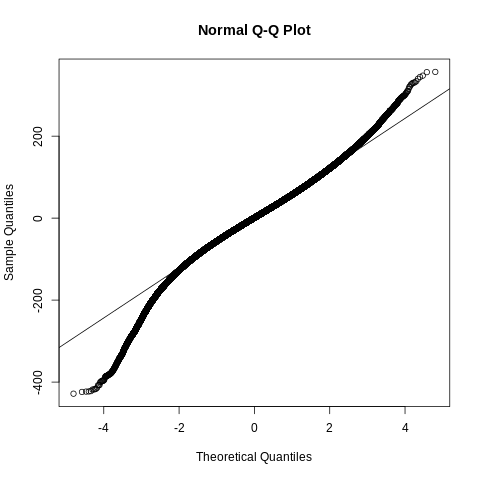

In [ ]:
%%R
qqnorm(residuals(fit.6b))
abline(0,sd(residuals(fit.6b)))

In [ ]:
%%R
confint(fit.6b)

                           2.5 %      97.5 %    Estimate
(Intercept)          307.2010852 337.5993710 322.4002281
fDimCat3               9.0802006  10.4918008   9.7860007
fDimCat4              16.2853090  17.7170995  17.0012043
fDimCat5              24.4311991  26.0911715  25.2611853
fDimCat6              24.1546274  26.2560548  25.2053411
fLactationNumberCat2 -24.3635783 -21.2943806 -22.8289794
fLactationNumberCat3 -42.7383364 -37.0347012 -39.8865188
fLactationNumberCat4 -56.2607128 -47.9012944 -52.0810036
fLactationNumberCat5 -49.6104773 -38.4795254 -44.0450014
fLactationNumberCat6 -51.2525924 -37.0069149 -44.1297537
fLactationNumberCat7 -57.1392937 -39.4377561 -48.2885249
fLactationNumberCat8 -50.5971324 -28.8938215 -39.7454770
fTempMeanCat0          3.4201648   5.0904493   4.2553071
fTempMeanCat2         -3.4227434  -2.3335925  -2.8781680
fTempMeanCat3         -8.9211897  -7.6004278  -8.2608087
fTempMeanCat4        -40.7242929 -39.0585308 -39.8914118
fTempMeanCat5        -68.492590

In [ ]:
%%R
rm(fit.6b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2739756  146.4    6361872  339.8   5608914  299.6
Vcells 215683634 1645.6  414213759 3160.3 404762983 3088.1


In [ ]:
%%R
##DRY 
fit.6c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model6c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMeanDRY.R'
save(fit.6c, file= url_model6c)
summary(fit.6c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811204.9  811563.2 -405563.5  811126.9     72062 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.160e+04 107.6978       
              Day         1.719e-02   0.1311 -0.81 
 Residual                 3.910e+03  62.5303       
Number of obs: 72101, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.91e+03 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           373.55681    5.62012   66.47  < 2e-16 ***
fLactationNumberCat2   16.90336    1.83189    9.23  < 2e-16 ***
fLactationNumberCat3   -7.90572    2.61481   -3.02  0.00250 ** 
fLactationNumberCat4  -31.08681    3.21513   -9.67  < 2e-16 ***
fLactationNumb

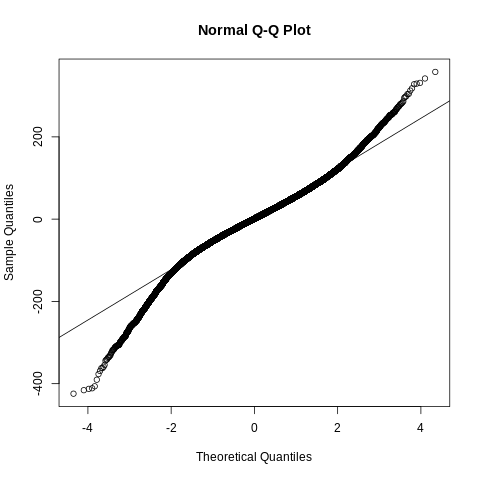

In [ ]:
%%R
qqnorm(residuals(fit.6c))
abline(0,sd(residuals(fit.6c)))

In [ ]:
%%R
confint(fit.6c)

                            2.5 %      97.5 %      Estimate
(Intercept)           362.5415892 384.5720400  373.55681460
fLactationNumberCat2   13.3129264  20.4937856   16.90335596
fLactationNumberCat3  -13.0306577  -2.7807737   -7.90571568
fLactationNumberCat4  -37.3883501 -24.7852690  -31.08680956
fLactationNumberCat5  -66.5964428 -51.6332317  -59.11483725
fLactationNumberCat6  -66.9319239 -48.9248522  -57.92838802
fLactationNumberCat7  -91.8757848 -68.6641144  -80.26994960
fLactationNumberCat8 -130.5459365 -99.2358513 -114.89089390
fTempMeanCat0          -1.4234055   4.7705329    1.67356373
fTempMeanCat2          -2.1807933   1.4609399   -0.35992673
fTempMeanCat3          -3.9107140   0.4175381   -1.74658794
fTempMeanCat4         -16.4150479 -10.9717887  -13.69341829
fTempMeanCat5         -37.8604224 -29.2391622  -33.54979230
fTempMeanCat6         -83.6556674 -66.7907412  -75.22320431
fYear2018             -32.3601498 -25.6835493  -29.02184958
fYear2019             -46.1211656 -34.74

In [ ]:
%%R
rm(fit.6c)
gc()

            used (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2171057  116    6361872  339.8   5608914  299.6
Vcells 188339888 1437  414213759 3160.3 404762983 3088.1


## Model Temp max

In [ ]:
%%R
##AMS
fit.7a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model7a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMaxAMS.R'
save(fit.7a, file= url_model7a)
summary(fit.7a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3517224  3517630 -1758574  3517148   323305 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.069e+04 201.7078       
              Day         4.339e-02   0.2083 -0.75 
 Residual                 3.023e+03  54.9849       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.02e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          344.6345    10.4432   33.00  < 2e-16 ***
fDimCat3              18.3830     0.4676   39.32  < 2e-16 ***
fDimCat4              32.1282     0.4961   64.76  < 2e-16 ***
fDimCat5              42.0656     0.6147   68.43  < 2e-16 ***
fDimCat6              43.

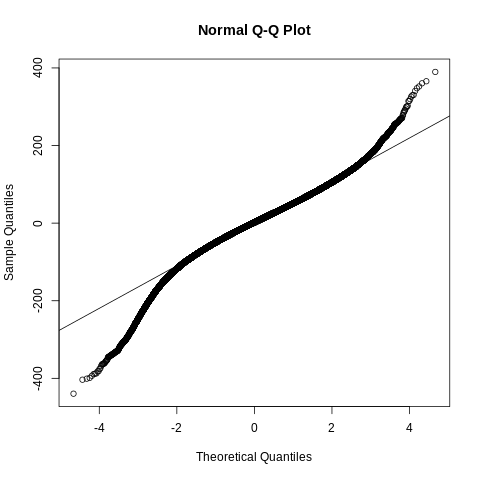

In [ ]:
%%R
qqnorm(residuals(fit.7a))
abline(0,sd(residuals(fit.7a)))

In [ ]:
%%R
confint(fit.7a)

                           2.5 %      97.5 %    Estimate
(Intercept)          324.1662240 365.1027440 344.6344840
fDimCat3              17.4665515  19.2993557  18.3829536
fDimCat4              31.1557980  33.1005643  32.1281811
fDimCat5              40.8607651  43.2705226  42.0656438
fDimCat6              41.7086800  44.9404190  43.3245495
fLactationNumberCat2  19.5115936  24.5854318  22.0485127
fLactationNumberCat3  26.0330090  35.5911297  30.8120694
fLactationNumberCat4  36.7965370  50.8887385  43.8426377
fLactationNumberCat5  37.9972669  56.6776349  47.3374509
fLactationNumberCat6  51.8081391  75.2122052  63.5101721
fLactationNumberCat7  47.8363881  75.8740671  61.8552276
fLactationNumberCat8  29.9514991  63.1881829  46.5698410
fTempMaxCat0          -0.9720287   3.6486669   1.3383191
fTempMaxCat2          -3.4251211  -1.9992941  -2.7122076
fTempMaxCat3          -2.7167366  -0.9485256  -1.8326311
fTempMaxCat4          -5.8504247  -3.9238552  -4.8871400
fTempMaxCat5         -15.075003

In [ ]:
%%R
rm(fit.7a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2422472  129.4    6361872  339.8   5608914  299.6
Vcells 199766197 1524.1  414213759 3160.3 404762983 3088.1


In [ ]:
%%R
##CMS 
fit.7b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model7b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMaxCMS.R'
save(fit.7b, file= url_model7b)
summary(fit.7b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7104930  7105385 -3552425  7104850   640912 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.901e+04 170.3329       
              Day         3.675e-02   0.1917 -0.81 
 Residual                 3.731e+03  61.0782       
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.73e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          321.4400     7.7946   41.24  < 2e-16 ***
fDimCat3               9.8090     0.3607   27.20  < 2e-16 ***
fDimCat4              17.0288     0.3659   46.54  < 2e-16 ***
fDimCat5              25.2266     0.4243   59.45  < 2e-16 ***
fDimCat6              25

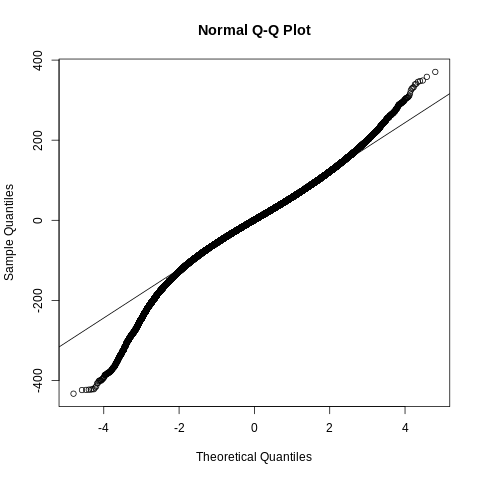

In [ ]:
%%R
qqnorm(residuals(fit.7b))
abline(0,sd(residuals(fit.7b)))

In [ ]:
%%R
confint(fit.7b)

                             2.5 %      97.5 %    Estimate
(Intercept)          306.162790552 336.7172126 321.4400016
fDimCat3               9.102071851  10.5158853   9.8089786
fDimCat4              16.311699122  17.7459636  17.0288314
fDimCat5              24.394917343  26.0582474  25.2265824
fDimCat6              24.109559889  26.2158050  25.1626824
fLactationNumberCat2 -24.586369066 -21.5101309 -23.0482500
fLactationNumberCat3 -43.104848011 -37.3873306 -40.2460893
fLactationNumberCat4 -56.624559650 -48.2441144 -52.4343370
fLactationNumberCat5 -49.807388192 -38.6480085 -44.2276983
fLactationNumberCat6 -51.234162459 -36.9524297 -44.0932961
fLactationNumberCat7 -56.874282652 -39.1292426 -48.0017626
fLactationNumberCat8 -50.080199392 -28.3263095 -39.2032544
fTempMaxCat0           5.251423382   7.9504022   6.6009128
fTempMaxCat2          -1.864197981  -0.7533987  -1.3087983
fTempMaxCat3          -0.228301564   1.1402215   0.4559599
fTempMaxCat4           0.009026718   1.4624691   0.73574

In [ ]:
%%R
rm(fit.7b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2739953  146.4    6361872  339.8   5608914  299.6
Vcells 215685333 1645.6  414213759 3160.3 404762983 3088.1


In [ ]:
%%R
##DRY 
fit.7c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model7c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMaxDRY.R'
save(fit.7c, file= url_model7c)
summary(fit.7c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMaxCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811382.2  811740.4 -405652.1  811304.2     72062 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.161e+04 107.7627       
              Day         1.722e-02   0.1312 -0.81 
 Residual                 3.920e+03  62.6091       
Number of obs: 72101, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.92e+03 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           374.1254     5.6145   66.64  < 2e-16 ***
fLactationNumberCat2   16.8281     1.8328    9.18  < 2e-16 ***
fLactationNumberCat3   -8.0393     2.6157   -3.07  0.00212 ** 
fLactationNumberCat4  -31.1738     3.2161   -9.69  < 2e-16 ***
fLactationNumberCat5

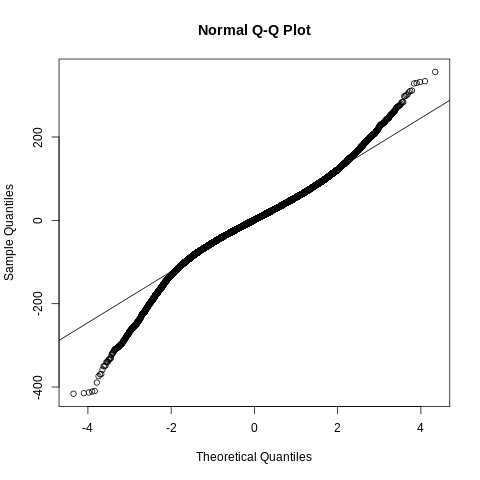

In [ ]:
%%R
qqnorm(residuals(fit.7c))
abline(0,sd(residuals(fit.7c)))

In [ ]:
%%R
confint(fit.7c)

                            2.5 %      97.5 %     Estimate
(Intercept)           363.1212946 385.1295685  374.1254315
fLactationNumberCat2   13.2358121  20.4204111   16.8281116
fLactationNumberCat3  -13.1659938  -2.9126409   -8.0393174
fLactationNumberCat4  -37.4772882 -24.8703911  -31.1738396
fLactationNumberCat5  -66.5554383 -51.5882434  -59.0718408
fLactationNumberCat6  -67.0118128 -48.9974783  -58.0046455
fLactationNumberCat7  -91.9283102 -68.7022531  -80.3152816
fLactationNumberCat8 -130.4020538 -99.0690527 -114.7355532
fTempMaxCat0            1.4050241  10.7700821    6.0875531
fTempMaxCat2           -2.4141223   1.3288410   -0.5426406
fTempMaxCat3           -2.0723050   2.5630932    0.2453941
fTempMaxCat4            0.1862797   5.1329511    2.6596154
fTempMaxCat5           -6.2758911  -0.7542563   -3.5150737
fTempMaxCat6          -26.7617885 -20.2685969  -23.5151927
fYear2018             -32.4625568 -25.7775738  -29.1200653
fYear2019             -46.2096531 -34.8276326  -40.51864

In [ ]:
%%R
rm(fit.7c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2170394  116.0    6361872  339.8   5608914  299.6
Vcells 188332133 1436.9  414213759 3160.3 404762983 3088.1


## Model Temp min

In [ ]:
%%R
##AMS
fit.8a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model8a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMinAMS.R'
save(fit.8a, file= url_model8a)
summary(fit.8a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3516124  3516530 -1758024  3516048   323305 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.180e+04 204.4490       
              Day         4.443e-02   0.2108 -0.76 
 Residual                 3.013e+03  54.8893       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.01e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          339.8058    10.5784   32.12  < 2e-16 ***
fDimCat3              18.4936     0.4668   39.62  < 2e-16 ***
fDimCat4              32.2989     0.4956   65.17  < 2e-16 ***
fDimCat5              42.1083     0.6144   68.53  < 2e-16 ***
fDimCat6              43.

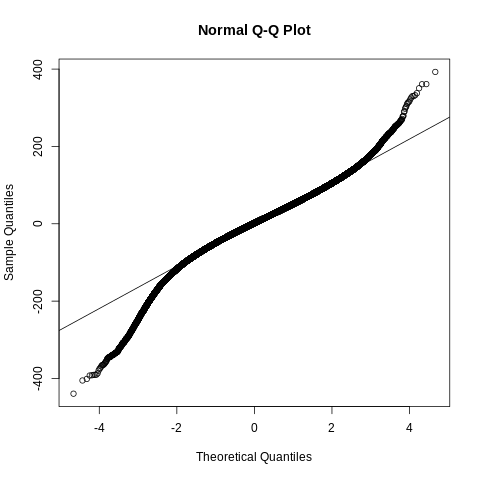

In [ ]:
%%R
qqnorm(residuals(fit.8a))
abline(0,sd(residuals(fit.8a)))

In [ ]:
%%R
confint(fit.8a)

                           2.5 %       97.5 %    Estimate
(Intercept)          319.0724985 360.53907790 339.8057882
fDimCat3              17.5786554  19.40850297  18.4935792
fDimCat4              31.3276013  33.27026197  32.2989316
fDimCat5              40.9041078  43.31258328  42.1083455
fDimCat6              41.6119400  44.84337889  43.2276595
fLactationNumberCat2  20.3046376  25.37952513  22.8420814
fLactationNumberCat3  28.0565460  37.61887449  32.8377102
fLactationNumberCat4  39.2595071  53.35909643  46.3093018
fLactationNumberCat5  40.8894124  59.57990645  50.2346594
fLactationNumberCat6  54.6028624  78.01836230  66.3106124
fLactationNumberCat7  50.1003267  78.14842295  64.1243748
fLactationNumberCat8  31.5990060  64.84236402  48.2206850
fTempMinCat0          -1.6618655  -0.02325473  -0.8425601
fTempMinCat2          -2.8148014  -1.60798328  -2.2113924
fTempMinCat3          -8.8981992  -7.42704188  -8.1626205
fTempMinCat4         -16.4998708 -14.72566757 -15.6127692
fTempMinCat5  

In [ ]:
%%R
rm(fit.8a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2421812  129.4    6361872  339.8   5608914  299.6
Vcells 199758453 1524.1  414213759 3160.3 404762983 3088.1


In [ ]:
%%R
##CMS 
fit.8b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model8b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMinCMS.R'
save(fit.8b, file= url_model8b)
summary(fit.8b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7114493  7114948 -3557206  7114413   640912 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.792e+04 167.0824       
              Day         3.548e-02   0.1884 -0.80 
 Residual                 3.787e+03  61.5410       
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.79e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          317.0850     7.6969   41.20  < 2e-16 ***
fDimCat3               9.9419     0.3633   27.36  < 2e-16 ***
fDimCat4              16.9513     0.3683   46.03  < 2e-16 ***
fDimCat5              25.2109     0.4264   59.13  < 2e-16 ***
fDimCat6              25

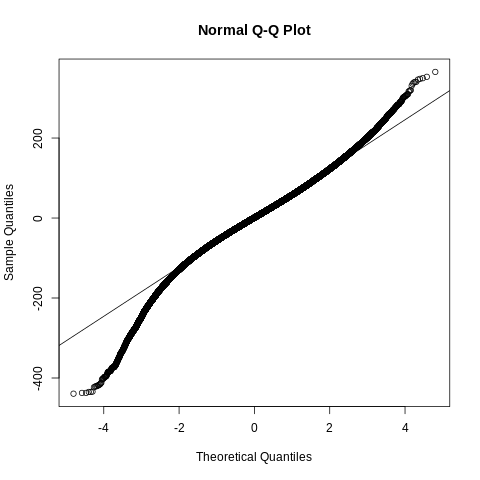

In [ ]:
%%R
qqnorm(residuals(fit.8b))
abline(0,sd(residuals(fit.8b)))

In [ ]:
%%R
confint(fit.8b)

                           2.5 %       97.5 %    Estimate
(Intercept)          301.9993417 332.17064722 317.0849945
fDimCat3               9.2297363  10.65397746   9.9418569
fDimCat4              16.2295294  17.67310149  16.9513155
fDimCat5              24.3752593  26.04663544  25.2109474
fDimCat6              24.0118876  26.12517053  25.0685291
fLactationNumberCat2 -24.5928426 -21.50765663 -23.0502496
fLactationNumberCat3 -43.3516249 -37.62160806 -40.4866165
fLactationNumberCat4 -57.3115602 -48.91563651 -53.1135984
fLactationNumberCat5 -51.1038018 -39.92582217 -45.5148120
fLactationNumberCat6 -53.3670124 -39.06115770 -46.2140850
fLactationNumberCat7 -60.0705335 -42.29077175 -51.1806526
fLactationNumberCat8 -54.6873837 -32.87815173 -43.7827677
fTempMinCat0          -0.8221408   0.24803882  -0.2870510
fTempMinCat2          -2.6795942  -1.72319109  -2.2013926
fTempMinCat3          -6.6878416  -5.54194308  -6.1148923
fTempMinCat4         -16.7107325 -15.36552159 -16.0381270
fTempMinCat5  

In [ ]:
%%R
rm(fit.8b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2739577  146.4    6361872  339.8   5608914  299.6
Vcells 215681167 1645.6  414213759 3160.3 404762983 3088.1


In [ ]:
%%R
##DRY 
fit.8c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model8c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMinDRY.R'
save(fit.8c, file= url_model8c)
summary(fit.8c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMinCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811495.7  811854.0 -405708.9  811417.7     72062 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.163e+04 107.8341       
              Day         1.729e-02   0.1315 -0.81 
 Residual                 3.926e+03  62.6570       
Number of obs: 72101, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.93e+03 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           374.48111    5.63853   66.41  < 2e-16 ***
fLactationNumberCat2   16.62331    1.83391    9.06  < 2e-16 ***
fLactationNumberCat3   -8.65386    2.61711   -3.31 0.000944 ***
fLactationNumberCat4  -31.42627    3.21836   -9.76  < 2e-16 ***
fLactationNumbe

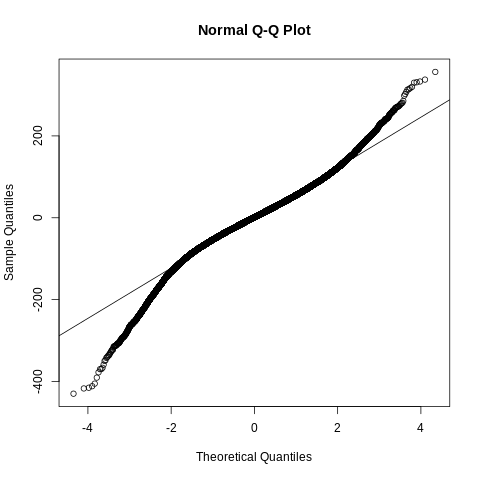

In [ ]:
%%R
qqnorm(residuals(fit.8c))
abline(0,sd(residuals(fit.8c)))

In [ ]:
%%R
confint(fit.8c)

                            2.5 %      97.5 %      Estimate
(Intercept)           363.4297922 385.5324201  374.48110616
fLactationNumberCat2   13.0289132  20.2177089   16.62331105
fLactationNumberCat3  -13.7833151  -3.5244141   -8.65386459
fLactationNumberCat4  -37.7341364 -25.1184126  -31.42627450
fLactationNumberCat5  -66.4490996 -51.4695756  -58.95933764
fLactationNumberCat6  -67.0765749 -49.0454592  -58.06101707
fLactationNumberCat7  -92.9152831 -69.6698611  -81.29257211
fLactationNumberCat8 -130.9683407 -99.6050683 -115.28670448
fTempMinCat0           -1.7156166   2.0692896    0.17683651
fTempMinCat2           -1.6373366   1.4983104   -0.06951308
fTempMinCat3           -3.0846540   0.7023394   -1.19115729
fTempMinCat4          -10.5239280  -6.1474314   -8.33567970
fTempMinCat5          -20.4274421 -14.2495933  -17.33851770
fTempMinCat6          -52.2984825 -39.2162146  -45.75734857
fYear2018             -33.3780264 -26.6887664  -30.03339642
fYear2019             -46.9196347 -35.51

In [ ]:
%%R
rm(fit.8c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2170561  116.0    6361872  339.8   5608914  299.6
Vcells 188333728 1436.9  414213759 3160.3 404762983 3088.1


## Model Temp mean 1 day before

In [ ]:
%%R
##AMS
fit.9a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model9a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMean1daybeforeAMS.R'
save(fit.9a, file= url_model9a)
summary(fit.9a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3515380  3515786 -1757652  3515304   323305 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.102e+04 202.5454       
              Day         4.365e-02   0.2089 -0.75 
 Residual                 3.006e+03  54.8267       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.01e+03 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             345.1740    10.5093   32.84  < 2e-16 ***
fDimCat3                 18.4345     0.4663   39.54  < 2e-16 ***
fDimCat4                 32.2098     0.4950   65.07  < 2e-16 ***
fDimCat5                 42.1308     0.6136   68.66  < 2e-16 ***

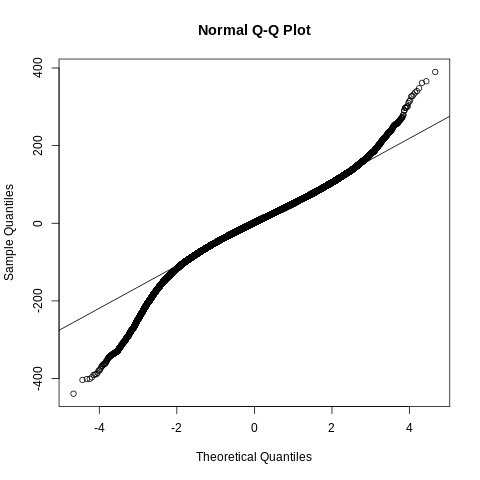

In [ ]:
%%R
qqnorm(residuals(fit.9a))
abline(0,sd(residuals(fit.9a)))

In [ ]:
%%R
confint(fit.9a)

                              2.5 %      97.5 %    Estimate
(Intercept)             324.5761277 365.7717948 345.1739612
fDimCat3                 17.5206664  19.3483999  18.4345332
fDimCat4                 31.2396413  33.1798731  32.2097572
fDimCat5                 40.9281513  43.3334658  42.1308085
fDimCat6                 41.7861189  45.0130388  43.3995788
fLactationNumberCat2     19.8524955  24.9189443  22.3857199
fLactationNumberCat3     26.8305455  36.3761070  31.6033262
fLactationNumberCat4     37.8216625  51.8960639  44.8588632
fLactationNumberCat5     39.2466045  57.9037368  48.5751707
fLactationNumberCat6     53.0571723  76.4317333  64.7444528
fLactationNumberCat7     49.1540374  77.1550597  63.1545485
fLactationNumberCat8     31.2070739  64.3973049  47.8021894
fTempMean1daybeforeCat1  -1.8072691   0.9025835  -0.4523428
fTempMean1daybeforeCat2  -7.2348897  -4.1760466  -5.7054681
fTempMean1daybeforeCat3 -14.9948709 -11.7961899 -13.3955304
fTempMean1daybeforeCat4 -33.0660241 -29.

In [ ]:
%%R
rm(fit.9a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2421979  129.4    6361872  339.8   5608914  299.6
Vcells 199760062 1524.1  414213759 3160.3 404762983 3088.1


In [ ]:
%%R
##CMS 
fit.9b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model9b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMean1daybeforeCMS.R'
save(fit.9b, file= url_model9b)
summary(fit.9b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7102922  7103376 -3551421  7102842   640793 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.848e+04 168.7537       
              Day         3.632e-02   0.1906 -0.81 
 Residual                 3.727e+03  61.0466       
Number of obs: 640833, groups:  AnimalEartag, 1275

Dispersion estimate for gaussian family (sigma^2): 3.73e+03 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             325.5487     7.7628   41.94  < 2e-16 ***
fDimCat3                  9.7939     0.3605   27.17  < 2e-16 ***
fDimCat4                 16.9805     0.3656   46.44  < 2e-16 ***
fDimCat5                 25.2277     0.4239   59.52  < 2e-16 **

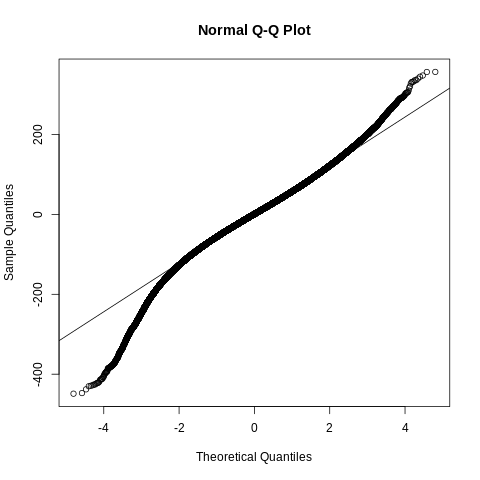

In [ ]:
%%R
qqnorm(residuals(fit.9b))
abline(0,sd(residuals(fit.9b)))

In [ ]:
%%R
confint(fit.9b)

                               2.5 %      97.5 %    Estimate
(Intercept)              310.3339878 340.7634751 325.5487314
fDimCat3                   9.0873344  10.5004598   9.7938971
fDimCat4                  16.2638233  17.6971019  16.9804626
fDimCat5                  24.3969234  26.0584862  25.2277048
fDimCat6                  24.1118702  26.2151570  25.1635136
fLactationNumberCat2     -24.4059213 -21.3340828 -22.8700020
fLactationNumberCat3     -42.8328576 -37.1246279 -39.9787427
fLactationNumberCat4     -56.4335824 -48.0675653 -52.2505738
fLactationNumberCat5     -49.9044140 -38.7647161 -44.3345650
fLactationNumberCat6     -51.6345149 -37.3774167 -44.5059658
fLactationNumberCat7     -57.5372042 -39.8214269 -48.6793155
fLactationNumberCat8     -51.0256932 -29.3046457 -40.1651695
fTempMean1daybeforeCat1   -5.3462674  -3.6783149  -4.5122911
fTempMean1daybeforeCat2   -7.8475126  -5.8580101  -6.8527614
fTempMean1daybeforeCat3  -15.1256854 -13.0011500 -14.0634177
fTempMean1daybeforeCat4 

In [ ]:
%%R
rm(fit.9b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2739622  146.4    6361872  339.8   5608914  299.6
Vcells 215997663 1648.0  414213759 3160.3 404762983 3088.1


In [ ]:
%%R
##DRY 
fit.9c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model9c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMean1daybeforeDRY.R'
save(fit.9c, file= url_model9c)
summary(fit.9c)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811041.7  811400.0 -405481.9  810963.7     72052 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.159e+04 107.6694       
              Day         1.718e-02   0.1311 -0.81 
 Residual                 3.907e+03  62.5076       
Number of obs: 72091, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.91e+03 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              375.8045     5.7435   65.43  < 2e-16 ***
fLactationNumberCat2      16.8100     1.8313    9.18  < 2e-16 ***
fLactationNumberCat3      -8.0103     2.6144   -3.06  0.00218 ** 
fLactationNumberCat4     -31.1410     3.2150   -9.69  < 2e-16

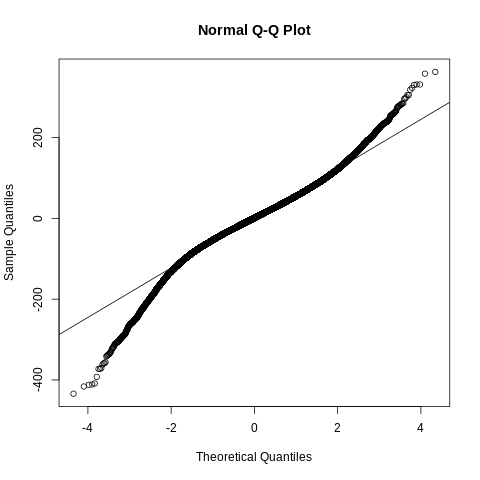

In [ ]:
%%R
qqnorm(residuals(fit.9c))
abline(0,sd(residuals(fit.9c)))

In [ ]:
%%R
confint(fit.9c)

                               2.5 %      97.5 %     Estimate
(Intercept)              364.5473932 387.0615959  375.8044945
fLactationNumberCat2      13.2208237  20.3992549   16.8100393
fLactationNumberCat3     -13.1343851  -2.8862581   -8.0103216
fLactationNumberCat4     -37.4421870 -24.8397484  -31.1409677
fLactationNumberCat5     -66.5459796 -51.5817925  -59.0638860
fLactationNumberCat6     -66.6467857 -48.6362285  -57.6415071
fLactationNumberCat7     -91.6438668 -68.4277315  -80.0357991
fLactationNumberCat8    -130.3578174 -99.0441272 -114.7009723
fTempMean1daybeforeCat1   -4.9404415   1.2415771   -1.8494322
fTempMean1daybeforeCat2   -6.4016806   0.7722070   -2.8147368
fTempMean1daybeforeCat3  -11.4164204  -3.8656643   -7.6410424
fTempMean1daybeforeCat4  -23.0615551 -14.8294683  -18.9455117
fTempMean1daybeforeCat5  -45.2012649 -34.5893943  -39.8953296
fTempMean1daybeforeCat6  -86.4085832 -68.0298766  -77.2192299
fYear2018                -32.2249863 -25.5486188  -28.8868026
fYear201

In [ ]:
%%R
rm(fit.9c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2170589  116.0    6361872  339.8   5608914  299.6
Vcells 188369445 1437.2  414213759 3160.3 404762983 3088.1


## Model Temp mean 2 days before

In [ ]:
%%R
##AMS
fit.10a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model10a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMean2daysbeforeAMS.R'
save(fit.10a, file= url_model10a)
summary(fit.10a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3516705  3517111 -1758315  3516629   323305 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.092e+04 202.2946       
              Day         4.396e-02   0.2097 -0.75 
 Residual                 3.018e+03  54.9398       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.02e+03 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              341.3060    10.4997   32.51  < 2e-16 ***
fDimCat3                  18.4495     0.4672   39.49  < 2e-16 ***
fDimCat4                  32.1816     0.4958   64.90  < 2e-16 ***
fDimCat5                  42.0486     0.6145   68.42  < 2e-

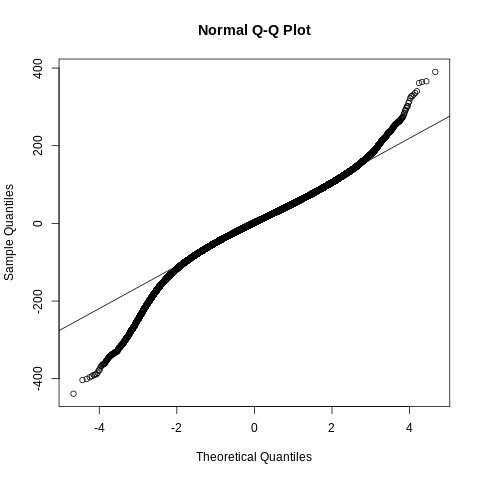

In [ ]:
%%R
qqnorm(residuals(fit.10a))
abline(0,sd(residuals(fit.10a)))

In [ ]:
%%R
confint(fit.10a)

                               2.5 %      97.5 %    Estimate
(Intercept)              320.7269968 361.8850628 341.3060298
fDimCat3                  17.5337706  19.3651479  18.4494593
fDimCat4                  31.2097997  33.1534314  32.1816156
fDimCat5                  40.8440917  43.2530249  42.0485583
fDimCat6                  41.6226735  44.8537712  43.2382223
fLactationNumberCat2      19.5648596  24.6381978  22.1015287
fLactationNumberCat3      26.2535498  35.8113085  31.0324291
fLactationNumberCat4      36.9584535  51.0502535  44.0043535
fLactationNumberCat5      38.0946996  56.7744415  47.4345706
fLactationNumberCat6      51.6376894  75.0405178  63.3391036
fLactationNumberCat7      47.4224416  75.4576606  61.4400511
fLactationNumberCat8      29.1964908  62.4286638  45.8125773
fTempMean2daysbeforeCat0  -1.5003487   1.2146359  -0.1428564
fTempMean2daysbeforeCat2  -5.7468649  -4.3281424  -5.0375037
fTempMean2daysbeforeCat3 -12.5846517 -10.8630359 -11.7238438
fTempMean2daysbeforeCat4

In [ ]:
%%R
rm(fit.10a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2422018  129.4    6361872  339.8   5608914  299.6
Vcells 199760164 1524.1  414213759 3160.3 404762983 3088.1


In [ ]:
%%R
##CMS 
fit.10b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model10b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMean2daysbeforeCMS.R'
save(fit.10b, file= url_model10b)
summary(fit.10b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7107322  7107777 -3553621  7107242   640675 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.822e+04 167.9886       
              Day         3.582e-02   0.1893 -0.81 
 Residual                 3.760e+03  61.3214       
Number of obs: 640715, groups:  AnimalEartag, 1275

Dispersion estimate for gaussian family (sigma^2): 3.76e+03 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              316.5278     7.7369   40.91  < 2e-16 ***
fDimCat3                   9.8162     0.3621   27.11  < 2e-16 ***
fDimCat4                  16.9548     0.3672   46.18  < 2e-16 ***
fDimCat5                  25.1535     0.4254   59.13  < 2e

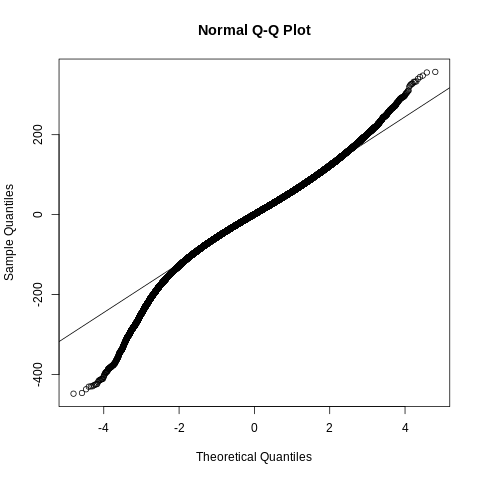

In [ ]:
%%R
qqnorm(residuals(fit.10b))
abline(0,sd(residuals(fit.10b)))

In [ ]:
%%R
confint(fit.10b)

                               2.5 %       97.5 %    Estimate
(Intercept)              301.3637916 331.69189892 316.5278453
fDimCat3                   9.1064355  10.52595421   9.8161949
fDimCat4                  16.2351397  17.67446293  16.9548013
fDimCat5                  24.3197234  25.98736604  25.1535447
fDimCat6                  23.9707285  26.08059983  25.0256642
fLactationNumberCat2     -24.5989331 -21.51790960 -23.0584214
fLactationNumberCat3     -43.2866672 -37.56303121 -40.4248492
fLactationNumberCat4     -57.1645294 -48.77712434 -52.9708269
fLactationNumberCat5     -50.9411588 -39.77385514 -45.3575070
fLactationNumberCat6     -52.9762763 -38.68404374 -45.8301600
fLactationNumberCat7     -59.2318569 -41.47121974 -50.3515383
fLactationNumberCat8     -53.1672800 -31.38716001 -42.2772200
fTempMean2daysbeforeCat0   4.0312396   5.70412575   4.8676827
fTempMean2daysbeforeCat2  -3.8441539  -2.74866808  -3.2964110
fTempMean2daysbeforeCat3  -8.0642190  -6.72236626  -7.3932927
fTempMea

In [ ]:
%%R
rm(fit.10b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2739543  146.4    6361872  339.8   5608914  299.6
Vcells 215992042 1647.9  414213759 3160.3 404762983 3088.1


In [ ]:
%%R
##DRY 
fit.10c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model10c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMean2daysbeforeDRY.R'
save(fit.10c, file= url_model10c)
summary(fit.10c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811015.0  811373.3 -405468.5  810937.0     72041 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.159e+04 107.6357       
              Day         1.718e-02   0.1311 -0.81 
 Residual                 3.913e+03  62.5525       
Number of obs: 72080, groups:  AnimalEartag, 1882

Dispersion estimate for gaussian family (sigma^2): 3.91e+03 

Conditional model:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               374.5046     5.6230   66.60  < 2e-16 ***
fLactationNumberCat2       16.7089     1.8312    9.12  < 2e-16 ***
fLactationNumberCat3       -8.2125     2.6140   -3.14  0.00168 ** 
fLactationNumberCat4      -31.3522     3.2141   -9.75  

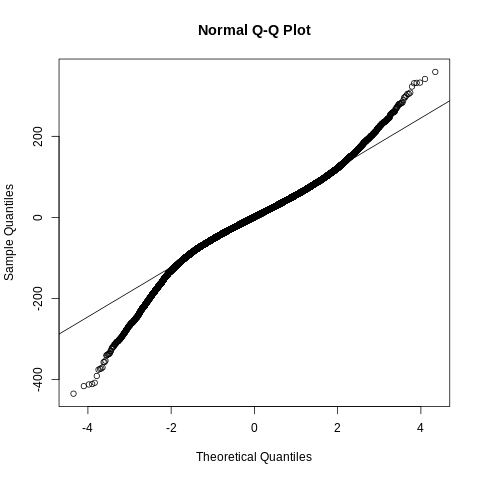

In [ ]:
%%R
qqnorm(residuals(fit.10c))
abline(0,sd(residuals(fit.10c)))

In [ ]:
%%R
confint(fit.10c)

                                2.5 %      97.5 %     Estimate
(Intercept)               363.4836992 385.5255912  374.5046452
fLactationNumberCat2       13.1197720  20.2979916   16.7088818
fLactationNumberCat3      -13.3357381  -3.0892393   -8.2124887
fLactationNumberCat4      -37.6516400 -25.0527400  -31.3521900
fLactationNumberCat5      -66.6646792 -51.7047440  -59.1847116
fLactationNumberCat6      -66.7251931 -48.7179678  -57.7215805
fLactationNumberCat7      -91.8069002 -68.5923112  -80.1996057
fLactationNumberCat8     -130.5714158 -99.2569162 -114.9141660
fTempMean2daysbeforeCat0   -2.7905823   3.3928198    0.3011187
fTempMean2daysbeforeCat2   -3.7723802  -0.1218448   -1.9471125
fTempMean2daysbeforeCat3   -6.8501004  -2.4947954   -4.6724479
fTempMean2daysbeforeCat4  -17.8479537 -12.3976825  -15.1228181
fTempMean2daysbeforeCat5  -39.3771569 -30.7036821  -35.0404195
fTempMean2daysbeforeCat6  -81.0361318 -63.4470405  -72.2415861
fYear2018                 -32.3888657 -25.7096136  -29.

In [ ]:
%%R
rm(fit.10c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2171061  116.0    6361872  339.8   5608914  299.6
Vcells 188374140 1437.2  414213759 3160.3 404762983 3088.1


## Model THI mean primi

In [ ]:
%%R
##AMS primi
fit.11a <- glmmTMB(SensorValue ~ fDimCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS_primi, REML=FALSE)
url_model11a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMeanAMS_primi.R'
save(fit.11a, file= url_model11a)
summary(fit.11a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +  
    (1 + Day | AnimalEartag)
Data: dataset_AMS_primi

      AIC       BIC    logLik  deviance  df.resid 
 765142.0  765417.2 -382541.0  765082.0     71154 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.038e+05 322.2035       
              Day         1.222e-01   0.3496 -0.85 
 Residual                 2.583e+03  50.8257       
Number of obs: 71184, groups:  AnimalEartag, 356

Dispersion estimate for gaussian family (sigma^2): 2.58e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          458.8418    20.9975   21.85  < 2e-16 ***
fDimCat3              15.0156     1.0390   14.45  < 2e-16 ***
fDimCat4              36.4887     1.1764   31.02  < 2e-16 ***
fDimCat5              53.8162     1.5309   35.15  < 2e-16 ***
fDimCat6              47.4095   

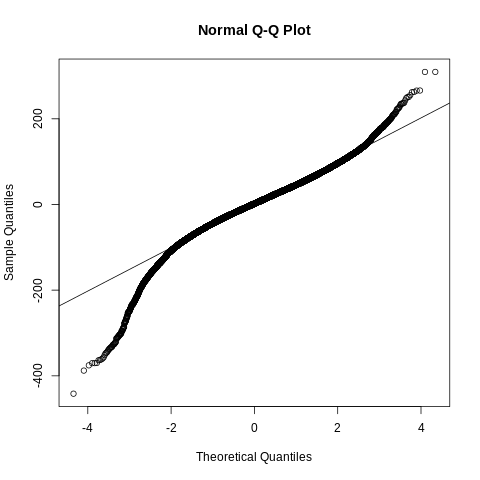

In [ ]:
%%R
qqnorm(residuals(fit.11a))
abline(0,sd(residuals(fit.11a)))

In [ ]:
%%R
confint(fit.11a)

                           2.5 %      97.5 %     Estimate
(Intercept)          419.5091699 502.3192822  460.9142260
fDimCat3              13.0338043  17.1011234   15.0674639
fDimCat4              34.2032700  38.8101004   36.5066852
fDimCat5              50.8447195  56.8405353   53.8426274
fDimCat6              43.3844309  51.5189088   47.4516699
fThiMeanCat0         -12.1870650   2.6543766   -4.7663442
fThiMeanCat2          -3.3876739  -0.5226332   -1.9551535
fThiMeanCat3          -7.2463033  -3.9688693   -5.6075863
fThiMeanCat4         -12.6858037  -8.7489136  -10.7173586
fThiMeanCat5         -31.6385327 -26.2802867  -28.9594097
fThiMeanCat6         -55.4720175 -47.8023825  -51.6372000
fYear2018            -17.1119447   5.0335460   -6.0391994
fYear2019            -29.0140973  14.4477615   -7.2831679
fYear2020            -39.7935940  24.9068311   -7.4433815
fMonth2                0.3777856   4.6369979    2.5073917
fMonth3               -9.4074228  -4.0620723   -6.7347476
fMonth4       

In [ ]:
%%R
rm(fit.11a)
gc()

            used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2194489 117.2    5251288  280.5   5251288  280.5
Vcells 126658706 966.4  287271172 2191.8 287244486 2191.6


In [ ]:
%%R
##CMS_primi 
fit.11b <- glmmTMB(SensorValue ~ fDimCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS_primi, REML=FALSE)
url_model11b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMeanCMS_primi.R'
save(fit.11b, file= url_model11b)
summary(fit.11b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +  
    (1 + Day | AnimalEartag)
Data: dataset_CMS_primi

      AIC       BIC    logLik  deviance  df.resid 
1924891.5 1925213.7 -962413.8 1924827.5    174476 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.743e+04 259.6724       
              Day         8.772e-02   0.2962 -0.83 
 Residual                 3.454e+03  58.7721       
Number of obs: 174508, groups:  AnimalEartag, 761

Dispersion estimate for gaussian family (sigma^2): 3.45e+03 

Conditional model:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         309.2522    15.2547   20.27  < 2e-16 ***
fDimCat3             10.0955     0.7147   14.13  < 2e-16 ***
fDimCat4             26.7216     0.8025   33.30  < 2e-16 ***
fDimCat5             37.3412     1.0618   35.17  < 2e-16 ***
fDimCat6             38.3122     1.4

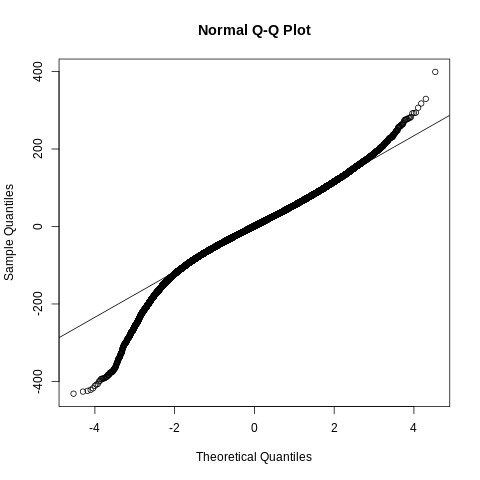

In [ ]:
%%R
qqnorm(residuals(fit.11b))
abline(0,sd(residuals(fit.11b)))

In [ ]:
%%R
confint(fit.11b)

                            2.5 %      97.5 %    Estimate
(Intercept)          2.784771e+02 338.3949495 308.4360330
fDimCat3             8.614211e+00  11.4175150  10.0158631
fDimCat4             2.513824e+01  28.2861315  26.7121867
fDimCat5             3.521020e+01  39.3752592  37.2927304
fDimCat6             3.550760e+01  41.2673880  38.3874918
fThiMeanCat0         9.550349e-01   5.9761031   3.4655690
fThiMeanCat2        -2.572246e+00  -0.4589861  -1.5156161
fThiMeanCat3        -5.055305e+00  -2.5930656  -3.8241853
fThiMeanCat4        -1.855544e+01 -15.8138261 -17.1846336
fThiMeanCat5        -4.630996e+01 -42.5650841 -44.4375233
fThiMeanCat6        -6.899752e+01 -63.3774841 -66.1875040
fYear2018            1.719174e+01  31.8272491  24.5094961
fYear2019            1.661402e+01  44.9737090  30.7938654
fYear2020            1.989204e-04  42.2629772  21.1315881
fMonth2             -5.845613e-01   2.4095289   0.9124838
fMonth3             -4.578630e+00  -0.9117185  -2.7451740
fMonth4       

In [ ]:
%%R
rm(fit.11b)
gc()

            used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2297940 122.8    5251288  280.5   5251288  280.5
Vcells 130955308 999.2  287271172 2191.8 287244486 2191.6


## Model THI mean multi

In [ ]:
%%R
##AMS_multiparous
fit.12a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS_multi, REML=FALSE)
url_model12a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMeanAMS_multi.R'
save(fit.12a, file= url_model12a)
summary(fit.12a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS_multi

     AIC      BIC   logLik deviance df.resid 
 2734472  2734847 -1367200  2734400   252123 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 5.354e+04 231.3935       
              Day         4.563e-02   0.2136 -0.81 
 Residual                 2.921e+03  54.0461       
Number of obs: 252159, groups:  AnimalEartag, 553

Dispersion estimate for gaussian family (sigma^2): 2.92e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          350.7016    12.4215   28.23  < 2e-16 ***
fDimCat3              20.0166     0.5099   39.26  < 2e-16 ***
fDimCat4              33.1973     0.5471   60.68  < 2e-16 ***
fDimCat5              40.8660     0.6837   59.77  < 2e-16 ***
fDimCat6           

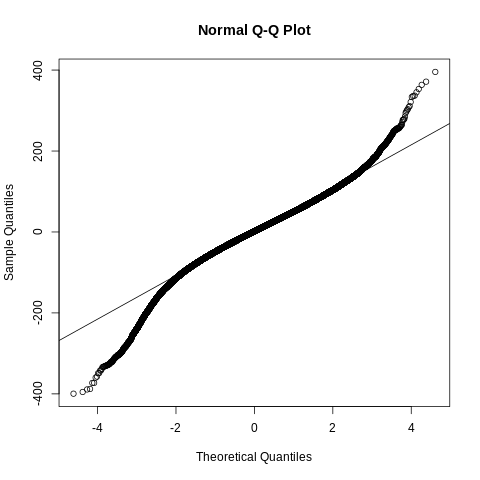

In [ ]:
%%R
qqnorm(residuals(fit.12a))
abline(0,sd(residuals(fit.12a)))

In [ ]:
%%R
confint(fit.12a)

                            2.5 %      97.5 %    Estimate
(Intercept)           327.8059375 376.4502630 352.1281003
fDimCat3               19.0969197  21.0915421  20.0942309
fDimCat4               32.1702680  34.3108595  33.2405638
fDimCat5               39.6428889  42.3184748  40.9806818
fDimCat6               41.1097861  44.7099182  42.9098522
fLactationNumberCat3   16.6186913  22.1244817  19.3715865
fLactationNumberCat4   30.1882655  40.8564086  35.5223371
fLactationNumberCat5   30.8142650  46.6390292  38.7266471
fLactationNumberCat6   41.3824750  62.4472769  51.9148759
fLactationNumberCat7   33.6648808  59.8014420  46.7331614
fLactationNumberCat8    9.3614625  41.0803541  25.2209083
fThiMeanCat0           -0.1428628   6.6287592   3.2429482
fThiMeanCat2           -5.6007086  -3.9787861  -4.7897473
fThiMeanCat3          -12.1512737 -10.3005336 -11.2259036
fThiMeanCat4          -20.6524441 -18.4840575 -19.5682508
fThiMeanCat5          -45.2901311 -42.2886855 -43.7894083
fThiMeanCat6  

In [ ]:
%%R
rm(fit.12a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2374915  126.9    5251288  280.5   5251288  280.5
Vcells 134502750 1026.2  287271172 2191.8 287244486 2191.6


In [ ]:
%%R
##CMS 
fit.12b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS_multi, REML=FALSE)
url_model12b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMeanCMS_multi.R'
save(fit.12b, file= url_model12b)
summary(fit.12b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS_multi

     AIC      BIC   logLik deviance df.resid 
 5154673  5155093 -2577298  5154597   466406 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.363e+04 153.7361       
              Day         3.393e-02   0.1842 -0.77 
 Residual                 3.602e+03  60.0151       
Number of obs: 466444, groups:  AnimalEartag, 1015

Dispersion estimate for gaussian family (sigma^2): 3.6e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          323.6049     8.4343   38.37  < 2e-16 ***
fDimCat3              10.0388     0.4104   24.46  < 2e-16 ***
fDimCat4              14.8050     0.4239   34.93  < 2e-16 ***
fDimCat5              23.0082     0.5067   45.41  < 2e-16 ***
fDimCat6           

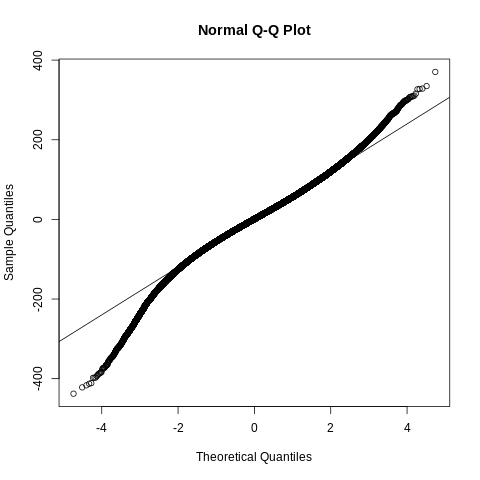

In [ ]:
%%R
qqnorm(residuals(fit.12b))
abline(0,sd(residuals(fit.12b)))

In [ ]:
%%R
confint(fit.12b)

                           2.5 %      97.5 %    Estimate
(Intercept)          305.4246321 338.4682858 321.9464589
fDimCat3               9.3418872  10.9523019  10.1470945
fDimCat4              14.0199718  15.6827876  14.8513797
fDimCat5              22.0269752  24.0142916  23.0206334
fDimCat6              21.8853177  24.4714001  23.1783589
fLactationNumberCat3 -15.0165676 -11.1991773 -13.1078724
fLactationNumberCat4 -28.6894227 -21.3541045 -25.0217636
fLactationNumberCat5 -24.1061418 -13.2223097 -18.6642258
fLactationNumberCat6 -29.5298607 -14.8515134 -22.1906870
fLactationNumberCat7 -39.8929780 -21.2281296 -30.5605538
fLactationNumberCat8 -38.5299549 -15.5225910 -27.0262730
fThiMeanCat0          -0.8626565   2.2678428   0.7025931
fThiMeanCat2          -2.0923743  -0.7836265  -1.4380004
fThiMeanCat3          -6.3495077  -4.8055218  -5.5775148
fThiMeanCat4         -24.2468383 -22.5157268 -23.3812826
fThiMeanCat5         -54.7339788 -52.3699055 -53.5519421
fThiMeanCat6         -79.483796

In [ ]:
%%R
rm(fit.12b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2589331  138.3    5251288  280.5   5251288  280.5
Vcells 144888524 1105.5  287271172 2191.8 287244486 2191.6


In [ ]:
%%R
##DRY 
fit.12c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry_multi, REML=FALSE)
url_model12c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMeanDRY_multi.R'
save(fit.12c, file= url_model12c)
summary(fit.12c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry_multi

      AIC       BIC    logLik  deviance  df.resid 
 677775.0  678108.5 -338850.5  677701.0     60493 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 7.864e+03 88.6818        
              Day         1.341e-02  0.1158  -0.76 
 Residual                 3.733e+03 61.0946        
Number of obs: 60530, groups:  AnimalEartag, 1583

Dispersion estimate for gaussian family (sigma^2): 3.73e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)           392.508      5.423   72.38  < 2e-16 ***
fLactationNumberCat3  -24.760      1.620  -15.29  < 2e-16 ***
fLactationNumberCat4  -49.139      2.532  -19.41  < 2e-16 ***
fLactationNumberCat5  -78.757      3.328  -23.67  < 2e-16 ***
fLactationNumberCat

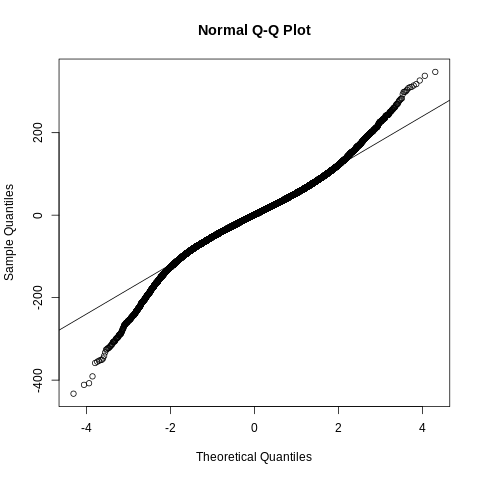

In [ ]:
%%R
qqnorm(residuals(fit.12c))
abline(0,sd(residuals(fit.12c)))

In [ ]:
%%R
confint(fit.12c)

                            2.5 %       97.5 %      Estimate
(Intercept)           381.8397312  403.1146033  392.47716728
fLactationNumberCat3  -27.8924105  -21.5397700  -24.71609026
fLactationNumberCat4  -53.9926224  -44.0611550  -49.02688873
fLactationNumberCat5  -85.3002736  -72.2455870  -78.77293030
fLactationNumberCat6  -86.9186279  -70.5300026  -78.72431525
fLactationNumberCat7 -111.4608380  -89.8411363 -100.65098719
fLactationNumberCat8 -148.4963115 -118.9619551 -133.72913331
fThiMeanCat0           -3.3551015    7.4030674    2.02398298
fThiMeanCat2           -1.9617029    1.9908845    0.01459081
fThiMeanCat3           -4.8246449   -0.3070945   -2.56586965
fThiMeanCat4          -10.3346218   -5.2827808   -7.80870132
fThiMeanCat5          -26.8562987  -19.9227461  -23.38952238
fThiMeanCat6          -50.9541140  -40.9416471  -45.94788055
fYear2018             -33.8763254  -27.0429632  -30.45964433
fYear2019             -46.7870402  -35.3757521  -41.08139611
fYear2020             -4

In [ ]:
%%R
rm(fit.12c)
gc()

            used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2183545 116.7    5251288  280.5   5251288  280.5
Vcells 126186560 962.8  287271172 2191.8 287244486 2191.6


## Model Temperature mean primi

In [ ]:
%%R
##AMS primi
fit.13a <- glmmTMB(SensorValue ~ fDimCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS_primi, REML=FALSE)
url_model13a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMeanAMS_primi.R'
save(fit.13a, file= url_model13a)
summary(fit.13a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +  
    (1 + Day | AnimalEartag)
Data: dataset_AMS_primi

      AIC       BIC    logLik  deviance  df.resid 
 765037.4  765312.6 -382488.7  764977.4     71154 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.050e+05 324.0254       
              Day         1.237e-01   0.3517 -0.85 
 Residual                 2.579e+03  50.7857       
Number of obs: 71184, groups:  AnimalEartag, 356

Dispersion estimate for gaussian family (sigma^2): 2.58e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          456.3320    21.0781   21.65  < 2e-16 ***
fDimCat3              15.0353     1.0382   14.48  < 2e-16 ***
fDimCat4              36.3112     1.1754   30.89  < 2e-16 ***
fDimCat5              53.4263     1.5303   34.91  < 2e-16 ***
fDimCat6              46.8923  

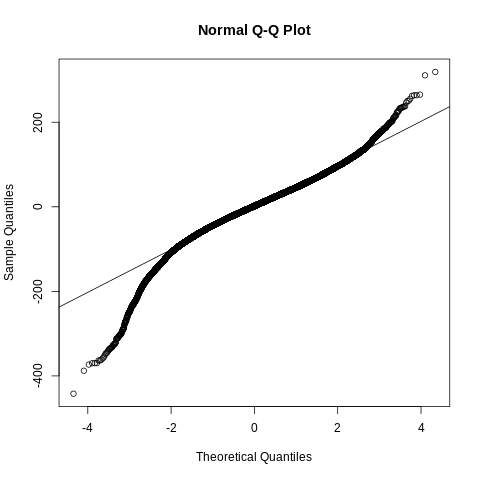

In [ ]:
%%R
qqnorm(residuals(fit.13a))
abline(0,sd(residuals(fit.13a)))

In [ ]:
%%R
confint(fit.13a)

                           2.5 %      97.5 %     Estimate
(Intercept)          416.9774094 499.4427533  458.2100814
fDimCat3              13.0046411  17.0737082   15.0391746
fDimCat4              34.0840210  38.6916852   36.3878531
fDimCat5              50.5390625  56.5364467   53.5377546
fDimCat6              42.9753278  51.1115038   47.0434158
fTempMeanCat0          0.5157591   6.3434402    3.4295997
fTempMeanCat2         -2.4958368   0.3367087   -1.0795641
fTempMeanCat3         -7.0925945  -3.6772230   -5.3849088
fTempMeanCat4        -21.9703839 -17.4414302  -19.7059071
fTempMeanCat5        -46.0133539 -38.9080457  -42.4606998
fTempMeanCat6        -70.5839051 -52.6461117  -61.6150084
fYear2018            -15.3648384   6.7525633   -4.3061376
fYear2019            -25.3831988  18.0291167   -3.6770411
fYear2020            -33.7075168  30.9187075   -1.3944046
fMonth2                0.4218303   4.6827720    2.5523012
fMonth3               -9.0235885  -3.6923190   -6.3579538
fMonth4       

In [ ]:
%%R
rm(fit.13a)
gc()

            used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2194327 117.2    5251288  280.5   5251288  280.5
Vcells 126106637 962.2  287271172 2191.8 287244486 2191.6


In [ ]:
%%R
##CMS_primi 
fit.13b <- glmmTMB(SensorValue ~ fDimCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS_primi, REML=FALSE)
url_model13b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMeanCMS_primi.R'
save(fit.13b, file= url_model13b)
summary(fit.13b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +  
    (1 + Day | AnimalEartag)
Data: dataset_CMS_primi

      AIC       BIC    logLik  deviance  df.resid 
1924884.4 1925206.6 -962410.2 1924820.4    174476 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 6.754e+04 259.8778       
              Day         8.735e-02   0.2955 -0.83 
 Residual                 3.454e+03  58.7710       
Number of obs: 174508, groups:  AnimalEartag, 761

Dispersion estimate for gaussian family (sigma^2): 3.45e+03 

Conditional model:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         306.6476    15.2792   20.07  < 2e-16 ***
fDimCat3             10.0610     0.7147   14.08  < 2e-16 ***
fDimCat4             26.7372     0.8027   33.31  < 2e-16 ***
fDimCat5             37.3098     1.0621   35.13  < 2e-16 ***
fDimCat6             38.2695     1.

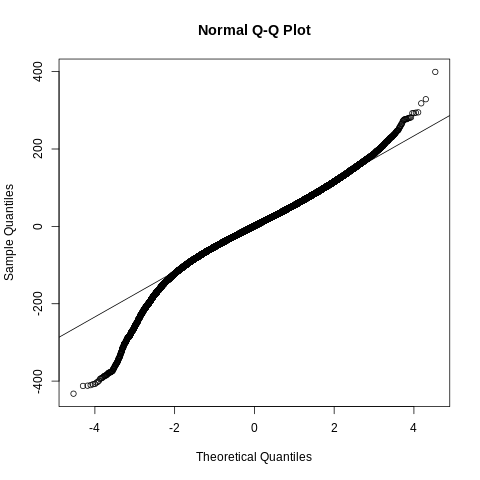

In [ ]:
%%R
qqnorm(residuals(fit.13b))
abline(0,sd(residuals(fit.13b)))

In [ ]:
%%R
confint(fit.13b)

                          2.5 %      97.5 %    Estimate
(Intercept)         278.0630614 337.9155832 307.9893223
fDimCat3              8.7062572  11.5059773  10.1061172
fDimCat4             25.1945183  28.3388592  26.7666888
fDimCat5             35.2762655  39.4366130  37.3564392
fDimCat6             35.4758460  41.2286051  38.3522256
fTempMeanCat0         4.3075221   7.4506856   5.8791039
fTempMeanCat2        -3.9316020  -1.9019847  -2.9167933
fTempMeanCat3        -7.4287790  -4.9925092  -6.2106441
fTempMeanCat4       -35.2200233 -32.1528201 -33.6864217
fTempMeanCat5       -60.6135293 -55.7386810 -58.1761051
fTempMeanCat6       -89.3675399 -79.4792349 -84.4233874
fYear2018            16.7966324  31.4012886  24.0989605
fYear2019            16.3579704  44.6583210  30.5081457
fYear2020             0.5052895  42.6819903  21.5936399
fMonth2              -0.3499435   2.6261942   1.1381254
fMonth3              -3.8861635  -0.2249864  -2.0555749
fMonth4              21.1076949  25.7501254  23.

In [ ]:
%%R
rm(fit.13b)
gc()

            used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2296879 122.7    5251288  280.5   5251288  280.5
Vcells 130395236 994.9  287271172 2191.8 287244486 2191.6


## Model Temperature mean multi

In [ ]:
%%R
##AMS_multiparous
fit.14a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS_multi, REML=FALSE)
url_model14a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMeanAMS_multi.R'
save(fit.14a, file= url_model14a)
summary(fit.14a)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS_multi

     AIC      BIC   logLik deviance df.resid 
 2734265  2734641 -1367096  2734193   252123 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 5.430e+04 233.0165       
              Day         4.672e-02   0.2162 -0.81 
 Residual                 2.918e+03  54.0226       
Number of obs: 252159, groups:  AnimalEartag, 553

Dispersion estimate for gaussian family (sigma^2): 2.92e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          344.8716    12.5333   27.52  < 2e-16 ***
fDimCat3              20.0592     0.5096   39.36  < 2e-16 ***
fDimCat4              33.2022     0.5469   60.71  < 2e-16 ***
fDimCat5              40.9605     0.6836   59.92  < 2e-16 ***
fDimCat6           

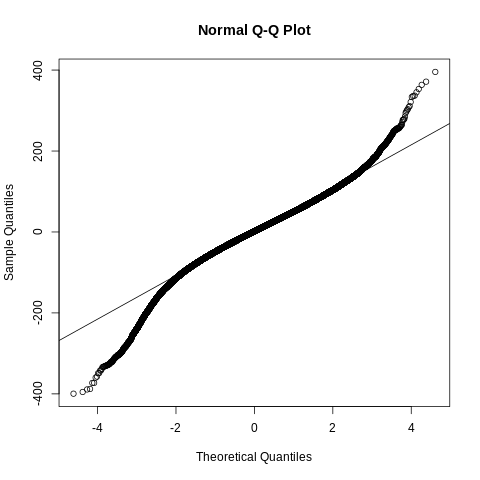

In [ ]:
%%R
qqnorm(residuals(fit.14a))
abline(0,sd(residuals(fit.14a)))

In [ ]:
%%R
confint(fit.14a)

                            2.5 %      97.5 %    Estimate
(Intercept)           324.7235865 373.5073807 349.1154836
fDimCat3               18.9988798  20.9960696  19.9974747
fDimCat4               32.1134015  34.2566082  33.1850048
fDimCat5               39.5794537  42.2584205  40.9189371
fDimCat6               41.0139555  44.6183442  42.8161498
fLactationNumberCat3   16.3628687  21.8757245  19.1192966
fLactationNumberCat4   29.6703707  40.3510850  35.0107279
fLactationNumberCat5   29.8983384  45.7409552  37.8196468
fLactationNumberCat6   40.0662224  61.1542746  50.6102485
fLactationNumberCat7   32.1624203  58.3277532  45.2450867
fLactationNumberCat8    7.6012146  39.3558096  23.4785121
fTempMeanCat0           1.2867126   4.2601609   2.7734367
fTempMeanCat2          -6.5624265  -4.9726914  -5.7675590
fTempMeanCat3         -14.4084166 -12.5058204 -13.4571185
fTempMeanCat4         -34.1539750 -31.6534132 -32.9036941
fTempMeanCat5         -61.6852079 -57.6521040 -59.6686559
fTempMeanCat6 

In [ ]:
%%R
rm(fit.14a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2374790  126.9    5251288  280.5   5251288  280.5
Vcells 134501826 1026.2  287271172 2191.8 287244486 2191.6


In [ ]:
%%R
##CMS 
fit.14b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS_multi, REML=FALSE)
url_model14b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMeanCMS_multi.R'
save(fit.14b, file= url_model14b)
summary(fit.14b)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS_multi

     AIC      BIC   logLik deviance df.resid 
 5155147  5155567 -2577535  5155071   466406 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.361e+04 153.6585       
              Day         3.382e-02   0.1839 -0.77 
 Residual                 3.606e+03  60.0460       
Number of obs: 466444, groups:  AnimalEartag, 1015

Dispersion estimate for gaussian family (sigma^2): 3.61e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          320.3325     8.4394   37.96  < 2e-16 ***
fDimCat3              10.0842     0.4106   24.56  < 2e-16 ***
fDimCat4              14.8777     0.4240   35.09  < 2e-16 ***
fDimCat5              23.0978     0.5068   45.57  < 2e-16 ***
fDimCat6          

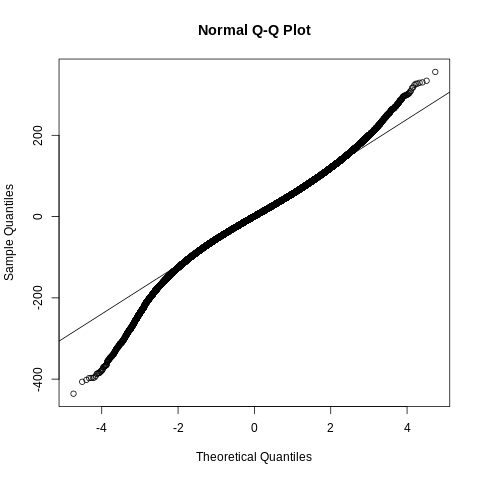

In [ ]:
%%R
qqnorm(residuals(fit.14b))
abline(0,sd(residuals(fit.14b)))

In [ ]:
%%R
confint(fit.14b)

                           2.5 %      97.5 %    Estimate
(Intercept)          304.5395366 337.6195467 321.0795417
fDimCat3               9.2536016  10.8619006  10.0577511
fDimCat4              14.0368114  15.6976331  14.8672223
fDimCat5              22.0916539  24.0769960  23.0843250
fDimCat6              22.0044850  24.5885040  23.2964945
fLactationNumberCat3 -14.6608797 -10.8452907 -12.7530852
fLactationNumberCat4 -28.1106121 -20.7793542 -24.4449831
fLactationNumberCat5 -23.5823223 -12.7054179 -18.1438701
fLactationNumberCat6 -29.0251082 -14.3567525 -21.6909304
fLactationNumberCat7 -39.2916068 -20.6401958 -29.9659013
fLactationNumberCat8 -37.8662491 -14.8767215 -26.3714853
fTempMeanCat0          3.3930296   5.3185589   4.3557943
fTempMeanCat2         -3.5238157  -2.2696470  -2.8967314
fTempMeanCat3         -9.8555483  -8.3289087  -9.0922285
fTempMeanCat4        -42.8428946 -40.9139883 -41.8784415
fTempMeanCat5        -71.8068816 -68.7393845 -70.2731331
fTempMeanCat6        -97.817605

In [ ]:
%%R
rm(fit.14b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2589206  138.3    5251288  280.5   5251288  280.5
Vcells 144887600 1105.5  287271172 2191.8 287244486 2191.6


In [ ]:
%%R
##DRY 
fit.14c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry_multi, REML=FALSE)
url_model14c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMeanDRY_multi.R'
save(fit.14c, file= url_model14c)
summary(fit.14c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry_multi

      AIC       BIC    logLik  deviance  df.resid 
 677786.9  678120.3 -338856.5  677712.9     60493 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 7.857e+03 88.6423        
              Day         1.335e-02  0.1156  -0.76 
 Residual                 3.733e+03 61.1022        
Number of obs: 60530, groups:  AnimalEartag, 1583

Dispersion estimate for gaussian family (sigma^2): 3.73e+03 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           392.0419     5.4290   72.21  < 2e-16 ***
fLactationNumberCat3  -24.6232     1.6196  -15.20  < 2e-16 ***
fLactationNumberCat4  -49.0133     2.5316  -19.36  < 2e-16 ***
fLactationNumberCat5  -78.8235     3.3274  -23.69  < 2e-16 ***
fLactationNum

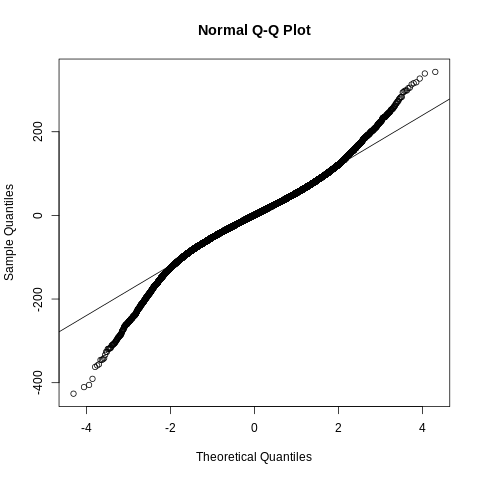

In [ ]:
%%R
qqnorm(residuals(fit.14c))
abline(0,sd(residuals(fit.14c)))

In [ ]:
%%R
confint(fit.14c)

                            2.5 %       97.5 %      Estimate
(Intercept)           381.2149532  402.4738967  391.84442499
fLactationNumberCat3  -27.7941034  -21.4505356  -24.62231951
fLactationNumberCat4  -54.0278500  -44.1119254  -49.06988773
fLactationNumberCat5  -85.4991291  -72.4646251  -78.98187710
fLactationNumberCat6  -86.7146881  -70.3522351  -78.53346157
fLactationNumberCat7 -111.1559099  -89.5720997 -100.36400480
fLactationNumberCat8 -149.2983041 -119.8157176 -134.55701085
fTempMeanCat0          -1.5145921    5.2663891    1.87589853
fTempMeanCat2          -2.9735581    0.9536202   -1.00996893
fTempMeanCat3          -5.4656173   -0.8100878   -3.13785252
fTempMeanCat4         -18.2500848  -12.4538855  -15.35198517
fTempMeanCat5         -40.2612101  -31.2539628  -35.75758642
fTempMeanCat6         -94.3840172  -76.7012794  -85.54264832
fYear2018             -33.4932552  -26.6728403  -30.08304773
fYear2019             -46.2888586  -34.8989652  -40.59391192
fYear2020             -4

In [ ]:
%%R
rm(fit.14c)
gc()

            used  (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2183420 116.7    5251288  280.5   5251288  280.5
Vcells 126185636 962.8  287271172 2191.8 287244486 2191.6


# Run models Eating grouped in 6 groups per 5

## Create sub datasets

In [ ]:
## load dataset
%%R 
url5 <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/df_joined_per5_eating.csv'

dataset_per5 <- read.csv(url5, header = TRUE, sep = ",")[ ,c('SensorValue','DimCat','LactationNumber','ThiMeanCat','TempMeanCat','ThiMaxCat','TempMinCat','ThiMinCat',
                                                       'ThiMean1daybeforeCat', 'TempMean1daybeforeCat', 'ThiMean2daysbeforeCat', 'TempMean2daysbeforeCat','CowLac',  
                                                        'TempMaxCat','Year', 'Month', 'HerdIdentifier','Day','AnimalEartag', 'Temp6Hrs16','Thi6Hrs60')]
## Change categorized data to factor and relevel 
dataset<-dataset_per5
dataset$fDimCat <- factor(dataset$DimCat)
dataset$fHerdIdentifier <- factor(dataset$HerdIdentifier)
dataset$fYear <- factor(dataset$Year)
dataset$fMonth <- factor(dataset$Month)
dataset$fThiMeanCat <- factor(dataset$ThiMeanCat)
dataset$fThiMaxCat <- factor(dataset$ThiMaxCat)
dataset$fThiMinCat <- factor(dataset$ThiMinCat)
dataset$fTempMeanCat <- factor(dataset$TempMeanCat)
dataset$fTempMaxCat <- factor(dataset$TempMaxCat)
dataset$fTempMinCat <- factor(dataset$TempMinCat)
dataset$fThiMean1daybeforeCat <- factor(dataset$ThiMean1daybeforeCat)
dataset$fThiMean2daysbeforeCat <- factor(dataset$ThiMean2daysbeforeCat)
dataset$fTempMean2daysbeforeCat <- factor(dataset$TempMean2daysbeforeCat)
dataset$fTempMean1daybeforeCat <- factor(dataset$TempMean1daybeforeCat)
dataset$fTemp6Hrs16 <- factor(dataset$Temp6Hrs16)
dataset$fThi6Hrs60 <- factor(dataset$Thi6Hrs60)
dataset$fLactationNumberCat <- factor(dataset$LactationNumber)
dataset <- within(dataset, fThiMeanCat <- relevel(fThiMeanCat, ref = "1"))
dataset <- within(dataset, fThiMinCat <- relevel(fThiMinCat, ref = "1"))
dataset <- within(dataset, fThiMaxCat <- relevel(fThiMaxCat, ref = "1"))
dataset <- within(dataset, fTempMeanCat <- relevel(fTempMeanCat, ref = "1"))
dataset <- within(dataset, fTempMinCat <- relevel(fTempMinCat, ref = "1"))
dataset <- within(dataset, fTempMaxCat <- relevel(fTempMaxCat, ref = "1"))
dataset <- within(dataset, fThiMean1daybeforeCat <- relevel(fThiMean1daybeforeCat, ref = "1"))
dataset <- within(dataset, fTempMean1day1beforeCat <- relevel(fTempMean1daybeforeCat, ref = "1"))
dataset <- within(dataset, fThiMean2daysbeforeCat <- relevel(fThiMean2daysbeforeCat, ref = "1"))
dataset <- within(dataset, fTempMean2daysbeforeCat <- relevel(fTempMean2daysbeforeCat, ref = "1"))

In [ ]:
%%R
dataset_milk <- filter(dataset, fDimCat==1|fDimCat==2|fDimCat==3|fDimCat==4|fDimCat==5|fDimCat==6)
dataset_dry <- filter(dataset, fDimCat==0)
dataset_AMS <- filter(dataset_milk, HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314)
dataset_CMS <- filter(dataset_milk, HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888)
dataset_dry_AMS <- filter(dataset_dry, HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314)
dataset_dry_CMS <- filter(dataset_dry, HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888)

In [ ]:
%%R
write.csv(dataset_AMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/dataset_per5_eating_AMS.csv', row.names = FALSE)
write.csv(dataset_CMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/dataset_per5_eating_CMS.csv', row.names = FALSE)
write.csv(dataset_dry, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/dataset_per5_eating_DRY.csv', row.names = FALSE)
write.csv(dataset_milk, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/dataset_per5_eating_milk.csv', row.names = FALSE)


## Descriptives lactating AMS/CMS, dry cow

In [ ]:
%%R
data_count_AMS_cowlac <- dataset_AMS %>%                              # Appeating group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_AMS_cowlac

  count
1  1496


In [ ]:
%%R
data_count_AMS_cow <- dataset_AMS %>%                              # Appeating group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_AMS_cow

  count
1   689


In [ ]:
%%R
data_count_CMS_cowlac <- dataset_CMS %>%                              # Appeating group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_CMS_cowlac

  count
1  2847


In [ ]:
%%R
data_count_dry_CMS <- dataset_CMS %>%                              # Appeating group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_dry_CMS

  count
1  1276


In [ ]:
%%R
data_count_dry_cowlac <- dataset_dry %>%                              # Appeating group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_dry_cowlac

  count
1  3676


In [ ]:
%%R
data_count_dry_cow <- dataset_dry %>%                              # Appeating group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_dry_cow

  count
1  1883


In [ ]:
%%R
table(dataset_AMS$ThiMeanCat)


     0      1      2      3      4      5 
  1213 175878  53875  59729  25365   7283 


In [ ]:
%%R
table(dataset_AMS$ThiMaxCat)


     0      1      2      3      4      5 
    97 123716  45245  52097  60053  42135 


In [ ]:
%%R
table(dataset_AMS$ThiMinCat)


     0      1      2      3      4      5 
 11977 127622  56955  54061  48498  24230 


In [ ]:
%%R
table(dataset_AMS$ThiMean1daybeforeCat)


     0      1      2      3      4      5 
  1207 175709  53958  59689  25479   7301 


In [ ]:
%%R
table(dataset_AMS$ThiMean2daysbeforeCat)


     0      1      2      3      4      5 
  1209 175521  53989  59828  25494   7302 


In [ ]:
%%R
table(dataset_AMS$TempMeanCat)


     0      1      2      3      4      5 
  7108 128966  75009  87991  20935   3334 


In [ ]:
%%R
table(dataset_AMS$TempMaxCat)


    0     1     2     3     4     5 
 2259 83823 71378 72920 63535 29428 


In [ ]:
%%R
table(dataset_AMS$TempMinCat)


    0     1     2     3     4     5 
26042 79589 94939 89219 31724  1830 


In [ ]:
%%R
table(dataset_AMS$TempMean1daybeforeCat)


     0      1      2      3      4      5 
  7100 128679  75253  87899  21078   3334 


In [ ]:
%%R
table(dataset_AMS$TempMean2daysbeforeCat)


     0      1      2      3      4      5 
  7085 128557  75252  88035  21064   3350 


In [ ]:
%%R
table(dataset_CMS$ThiMeanCat)


     0      1      2      3      4      5 
  8628 355960 107570 105849  47773  15172 


In [ ]:
%%R
table(dataset_CMS$ThiMaxCat)


     0      1      2      3      4      5 
  1137 251393  85646  93415 114669  94692 


In [ ]:
%%R
table(dataset_CMS$ThiMinCat)


     0      1      2      3      4      5 
 45592 282231 108909  97281  77693  29246 


In [ ]:
%%R
table(dataset_CMS$ThiMean1daybeforeCat)


     0      1      2      3      4      5 
  8544 355753 107620 105988  47759  15169 


In [ ]:
%%R
table(dataset_CMS$ThiMean2daysbeforeCat)


     0      1      2      3      4      5 
  8537 355533 107706 105924  47835  15180 


In [ ]:
%%R
table(dataset_CMS$TempMeanCat)


     0      1      2      3      4      5 
 24918 264415 143305 153603  46434   8277 


In [ ]:
%%R
table(dataset_CMS$TempMaxCat)


     0      1      2      3      4      5 
  8429 174863 127461 129906 128354  71939 


In [ ]:
%%R
table(dataset_CMS$TempMinCat)


     0      1      2      3      4      5 
 91304 167520 183319 157553  38101   3155 


In [ ]:
%%R
table(dataset_CMS$TempMean1daybeforeCat)


     0      1      2      3      4      5 
 24860 264099 143413 153687  46496   8278 


In [ ]:
%%R
table(dataset_CMS$TempMean2daysbeforeCat)


     0      1      2      3      4      5 
 24799 263941 143386 153726  46578   8285 


In [ ]:
%%R
table(dataset_dry$ThiMeanCat)


    0     1     2     3     4     5 
  781 36529 12570 14234  6182  1805 


In [ ]:
%%R
table(dataset_dry$ThiMaxCat)


    0     1     2     3     4     5 
   89 25373  9398 11467 14427 11347 


In [ ]:
%%R
table(dataset_dry$ThiMinCat)


    0     1     2     3     4     5 
 4179 27900 12371 12266 10884  4501 


In [ ]:
%%R
table(dataset_dry$ThiMean1daybeforeCat)


    0     1     2     3     4     5 
  789 36530 12542 14227  6209  1794 


In [ ]:
%%R
table(dataset_dry$ThiMean2daysbeforeCat)


    0     1     2     3     4     5 
  792 36536 12497 14211  6256  1788 


In [ ]:
%%R
table(dataset_dry$TempMeanCat)


    0     1     2     3     4     5 
 2310 26567 16259 20472  5545   948 


In [ ]:
%%R
table(dataset_dry$TempMaxCat)


    0     1     2     3     4     5 
  800 17449 13807 15906 15819  8320 


In [ ]:
%%R
table(dataset_dry$TempMinCat)


    0     1     2     3     4     5 
 8147 16769 20194 20677  5886   428 


In [ ]:
%%R
table(dataset_dry$TempMean1daybeforeCat)


    0     1     2     3     4     5 
 2307 26531 16315 20436  5562   940 


In [ ]:
%%R
table(dataset_dry$TempMean2daysbeforeCat)


    0     1     2     3     4     5 
 2312 26514 16307 20399  5612   936 


## Model THI mean

In [ ]:
%%R
##AMS
fit.1a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model1a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTHIMeanAMS.R'
save(fit.1a, file= url_model1a)
summary(fit.1a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3515914  3516310 -1757920  3515840   323306 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.123e+04 203.0495       
              Day         4.344e-02   0.2084 -0.75 
 Residual                 3.011e+03  54.8723       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.01e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          347.2716    10.4907   33.10  < 2e-16 ***
fDimCat3              18.4375     0.4667   39.51  < 2e-16 ***
fDimCat4              32.2660     0.4954   65.13  < 2e-16 ***
fDimCat5              42.1940     0.6143   68.69  < 2e-16 ***
fDimCat6              43.

In [ ]:
%%R
confint(fit.1a)

                           2.5 %      97.5 %    Estimate
(Intercept)          326.7102803 367.8330168 347.2716486
fDimCat3              17.5228690  19.3521495  18.4375093
fDimCat4              31.2949809  33.2370543  32.2660176
fDimCat5              40.9900525  43.3979529  42.1940027
fDimCat6              41.8673661  45.0981208  43.4827435
fLactationNumberCat2  20.2554284  25.3275710  22.7914997
fLactationNumberCat3  27.5329763  37.0899348  32.3114556
fLactationNumberCat4  38.7527972  52.8448598  45.7988285
fLactationNumberCat5  40.4373626  59.1183345  49.7778486
fLactationNumberCat6  54.5443962  77.9488128  66.2466045
fLactationNumberCat7  50.7328591  78.7691574  64.7510083
fLactationNumberCat8  32.8580403  66.0885192  49.4732797
fThiMeanCat0          -3.4466237   2.8674061  -0.2896088
fThiMeanCat2          -6.1120529  -4.6744493  -5.3932511
fThiMeanCat3         -12.8655188 -11.1866258 -12.0260723
fThiMeanCat4         -26.6572242 -24.5813102 -25.6192672
fThiMeanCat5         -56.455273

In [ ]:
%%R
rm(fit.1a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2426100  129.6    6361872  339.8   5608914  299.6
Vcells 209291762 1596.8  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##CMS 
fit.1b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model1b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTHIMeanCMS.R'
save(fit.1b, file= url_model1b)
summary(fit.1b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7103604  7104047 -3551763  7103526   640913 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.867e+04 169.3303       
              Day         3.661e-02   0.1913 -0.81 
 Residual                 3.723e+03  61.0157       
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.72e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          324.8637     7.7496   41.92  < 2e-16 ***
fDimCat3               9.7755     0.3603   27.13  < 2e-16 ***
fDimCat4              16.9470     0.3654   46.38  < 2e-16 ***
fDimCat5              25.2194     0.4237   59.53  < 2e-16 ***
fDimCat6              25

In [ ]:
%%R
confint(fit.1b)

                           2.5 %      97.5 %    Estimate
(Intercept)          309.6747679 340.0526042 324.8636861
fDimCat3               9.0694051  10.4816888   9.7755469
fDimCat4              16.2307382  17.6632023  16.9469703
fDimCat5              24.3889920  26.0497103  25.2193512
fDimCat6              24.0957055  26.1981331  25.1469193
fLactationNumberCat2 -24.6225780 -21.5522053 -23.0873916
fLactationNumberCat3 -43.0867606 -37.3807390 -40.2337498
fLactationNumberCat4 -56.5744544 -48.2110630 -52.3927587
fLactationNumberCat5 -49.7167679 -38.5800582 -44.1484130
fLactationNumberCat6 -51.0921449 -36.8389346 -43.9655397
fLactationNumberCat7 -56.7440660 -39.0332167 -47.8886414
fLactationNumberCat8 -50.0397823 -28.3255594 -39.1826709
fThiMeanCat0          -0.3047501   2.4010292   1.0481395
fThiMeanCat2          -3.8820356  -2.7793814  -3.3307085
fThiMeanCat3          -8.5632723  -7.2496793  -7.9064758
fThiMeanCat4         -34.8249616 -33.2336764 -34.0293190
fThiMeanCat5         -72.892141

In [ ]:
%%R
rm(fit.1b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2743854  146.6    6361872  339.8   5608914  299.6
Vcells 224896766 1715.9  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##DRY 
fit.1c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model1c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTHIMeanDRY.R'
save(fit.1c, file= url_model1c)
summary(fit.1c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811326.5  811675.6 -405625.3  811250.5     72063 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.161e+04 107.7443       
              Day         1.720e-02   0.1312 -0.81 
 Residual                 3.917e+03  62.5859       
Number of obs: 72101, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.92e+03 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           374.11997    5.61497   66.63  < 2e-16 ***
fLactationNumberCat2   16.79328    1.83189    9.17  < 2e-16 ***
fLactationNumberCat3   -8.17716    2.61466   -3.13  0.00176 ** 
fLactationNumberCat4  -31.25394    3.21512   -9.72  < 2e-16 ***
fLactationNumbe

In [ ]:
%%R
confint(fit.1c)

                            2.5 %       97.5 %      Estimate
(Intercept)           363.1148341 385.12511142  374.11997274
fLactationNumberCat2   13.2028416  20.38371126   16.79327642
fLactationNumberCat3  -13.3017950  -3.05253237   -8.17716368
fLactationNumberCat4  -37.5554598 -24.95241976  -31.25393979
fLactationNumberCat5  -66.4967498 -51.53271438  -59.01473207
fLactationNumberCat6  -66.9616451 -48.95252307  -57.95708409
fLactationNumberCat7  -91.9798102 -68.76347264  -80.37164144
fLactationNumberCat8 -130.1328483 -98.81380921 -114.47332877
fThiMeanCat0           -1.4873019   8.28145379    3.39707593
fThiMeanCat2           -1.9115909   1.75097128   -0.08030982
fThiMeanCat3           -4.1658273   0.09651531   -2.03465601
fThiMeanCat4          -15.2263737 -10.10303441  -12.66470403
fThiMeanCat5          -39.6523292 -32.14748383  -35.89990650
fYear2018             -32.5601827 -25.88053967  -29.22036117
fYear2019             -46.5337786 -35.15388551  -40.84383206
fYear2020             -4

In [ ]:
%%R
rm(fit.1c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2174807  116.2    6361872  339.8   5608914  299.6
Vcells 198118401 1511.6  414213759 3160.3 414180387 3160.0


## Model THI max

In [ ]:
%%R
##AMS
fit.2a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model2a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTHIMaxAMS.R'
save(fit.2a, file= url_model2a)
summary(fit.2a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3518845  3519240 -1759385  3518771   323306 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.080e+04 201.9914       
              Day         4.389e-02   0.2095 -0.76 
 Residual                 3.039e+03  55.1237       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.04e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          340.9456    10.4730   32.55  < 2e-16 ***
fDimCat3              18.5485     0.4687   39.57  < 2e-16 ***
fDimCat4              32.1712     0.4972   64.70  < 2e-16 ***
fDimCat5              42.0016     0.6159   68.19  < 2e-16 ***
fDimCat6              43.1

In [ ]:
%%R
confint(fit.2a)

                           2.5 %      97.5 %    Estimate
(Intercept)          320.4187739 361.4723422 340.9455580
fDimCat3              17.6298395  19.4671414  18.5484904
fDimCat4              31.1967168  33.1457708  32.1712438
fDimCat5              40.7943532  43.2088089  42.0015810
fDimCat6              41.5520433  44.7892301  43.1706367
fLactationNumberCat2  19.2342769  24.3168628  21.7755699
fLactationNumberCat3  25.5087114  35.0826478  30.2956796
fLactationNumberCat4  35.8289682  49.9438844  42.8864263
fLactationNumberCat5  36.5499275  55.2595740  45.9047507
fLactationNumberCat6  49.8270307  73.2672711  61.5471509
fLactationNumberCat7  45.1218676  73.2027855  59.1623265
fLactationNumberCat8  26.4027045  59.6916765  43.0471905
fThiMaxCat0          -10.8710768  11.1913337   0.1601285
fThiMaxCat2           -3.9281793  -2.4461063  -3.1871428
fThiMaxCat3           -3.1069135  -1.3472137  -2.2270636
fThiMaxCat4           -6.4778558  -4.5840698  -5.5309628
fThiMaxCat5          -23.159050

In [ ]:
%%R
rm(fit.2a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2426212  129.6    6361872  339.8   5608914  299.6
Vcells 209293376 1596.8  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##CMS 
fit.2b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model2b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTHIMaxCMS.R'
save(fit.2b, file= url_model2b)
summary(fit.2b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7111239  7111682 -3555580  7111161   640913 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.829e+04 168.1889       
              Day         3.565e-02   0.1888 -0.81 
 Residual                 3.768e+03  61.3836       
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.77e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          314.7770     7.7427   40.65  < 2e-16 ***
fDimCat3               9.8457     0.3624   27.17  < 2e-16 ***
fDimCat4              16.9297     0.3675   46.07  < 2e-16 ***
fDimCat5              25.0960     0.4257   58.95  < 2e-16 ***
fDimCat6              24.

In [ ]:
%%R
confint(fit.2b)

                           2.5 %       97.5 %    Estimate
(Intercept)          299.6016200 329.95232430 314.7769721
fDimCat3               9.1352933  10.55601387   9.8456536
fDimCat4              16.2095203  17.64997777  16.9297490
fDimCat5              24.2616312  25.93027479  25.0959530
fDimCat6              23.8931230  26.00389056  24.9485068
fLactationNumberCat2 -24.7544502 -21.67275896 -23.2136046
fLactationNumberCat3 -43.6274158 -37.90244739 -40.7649316
fLactationNumberCat4 -57.7964855 -49.40690008 -53.6016928
fLactationNumberCat5 -52.0171599 -40.84713028 -46.4321451
fLactationNumberCat6 -54.4312331 -40.13602826 -47.2836307
fLactationNumberCat7 -61.0957246 -43.33113636 -52.2134305
fLactationNumberCat8 -55.4999989 -33.71373294 -44.6068659
fThiMaxCat0           -1.5569286   5.65081343   2.0469424
fThiMaxCat2           -3.0842461  -1.91461833  -2.4994322
fThiMaxCat3           -1.2919748   0.08516212  -0.6034063
fThiMaxCat4           -0.8462856   0.59512222  -0.1255817
fThiMaxCat5   

In [ ]:
%%R
rm(fit.2b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2743966  146.6    6361872  339.8   5608914  299.6
Vcells 224898380 1715.9  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##DRY 
fit.2c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model2c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTHIMaxDRY.R'
save(fit.2c, file= url_model2c)
summary(fit.2c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMaxCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811590.3  811939.4 -405757.2  811514.3     72063 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.162e+04 107.7973       
              Day         1.727e-02   0.1314 -0.81 
 Residual                 3.932e+03  62.7019       
Number of obs: 72101, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.93e+03 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           374.3853     5.6148   66.68  < 2e-16 ***
fLactationNumberCat2   16.7575     1.8337    9.14  < 2e-16 ***
fLactationNumberCat3   -8.3324     2.6164   -3.18 0.001449 ** 
fLactationNumberCat4  -31.3112     3.2169   -9.73  < 2e-16 ***
fLactationNumberCat5 

In [ ]:
%%R
confint(fit.2c)

                            2.5 %        97.5 %     Estimate
(Intercept)           363.3804584  385.39015308  374.3853057
fLactationNumberCat2   13.1636169   20.35142848   16.7575227
fLactationNumberCat3  -13.4605296   -3.20432154   -8.3324256
fLactationNumberCat4  -37.6162702  -25.00611036  -31.3111903
fLactationNumberCat5  -66.5164133  -51.54406508  -59.0302392
fLactationNumberCat6  -67.2451545  -49.22299588  -58.2340752
fLactationNumberCat7  -92.8494227  -69.61344102  -81.2314319
fLactationNumberCat8 -131.6393972 -100.28647528 -115.9629362
fThiMaxCat0            12.3222300   39.07688911   25.6995596
fThiMaxCat2            -2.6872928    1.19196657   -0.7476631
fThiMaxCat3            -2.8543486    1.75909093   -0.5476288
fThiMaxCat4            -0.7051486    4.18179586    1.7383236
fThiMaxCat5           -13.2090550   -7.90245129  -10.5557532
fYear2018             -32.3440760  -25.65242415  -28.9982501
fYear2019             -46.4229621  -35.02824058  -40.7256014
fYear2020             -4

In [ ]:
%%R
rm(fit.2c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2175257  116.2    6361872  339.8   5608914  299.6
Vcells 198123375 1511.6  414213759 3160.3 414180387 3160.0


## Model THI min

In [ ]:
%%R
##AMS
fit.3a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model3a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTHIminAMS.R'
save(fit.3a, file= url_model3a)
summary(fit.3a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3517707  3518102 -1758816  3517633   323306 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.157e+04 203.8937       
              Day         4.431e-02   0.2105 -0.76 
 Residual                 3.028e+03  55.0249       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.03e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          338.9874    10.5634   32.09  < 2e-16 ***
fDimCat3              18.5444     0.4679   39.63  < 2e-16 ***
fDimCat4              32.2913     0.4967   65.01  < 2e-16 ***
fDimCat5              42.0549     0.6158   68.30  < 2e-16 ***
fDimCat6              43.1

In [ ]:
%%R
confint(fit.3a)

                           2.5 %      97.5 %    Estimate
(Intercept)          318.2834284 359.6913478 338.9873881
fDimCat3              17.6272589  19.4615265  18.5443927
fDimCat4              31.3177732  33.2647784  32.2912758
fDimCat5              40.8480569  43.2618021  42.0549295
fDimCat6              41.5320706  44.7704323  43.1512514
fLactationNumberCat2  20.4556464  25.5422391  22.9989428
fLactationNumberCat3  28.1702458  37.7541605  32.9622032
fLactationNumberCat4  39.2869118  53.4177094  46.3523106
fLactationNumberCat5  40.7387663  59.4699912  50.1043788
fLactationNumberCat6  54.3605305  77.8265711  66.0935508
fLactationNumberCat7  49.6550674  77.7633578  63.7092126
fLactationNumberCat8  30.8999158  64.2144629  47.5571894
fThiMinCat0           -2.2528175  -0.1349521  -1.1938848
fThiMinCat2           -4.9763325  -3.7674781  -4.3719053
fThiMinCat3          -10.7049207  -9.2206896  -9.9628052
fThiMinCat4          -16.3304696 -14.6217897 -15.4761297
fThiMinCat5          -34.798365

In [ ]:
%%R
rm(fit.3a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2426193  129.6    6361872  339.8   5608914  299.6
Vcells 209293164 1596.8  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##CMS 
fit.3b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model3b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTHIMinCMS.R'
save(fit.3b, file= url_model3b)
summary(fit.3b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7116291  7116734 -3558106  7116213   640913 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.799e+04 167.3163       
              Day         3.548e-02   0.1884 -0.81 
 Residual                 3.798e+03  61.6278       
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.8e+03 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          316.86267    7.69677   41.17  < 2e-16 ***
fDimCat3               9.92750    0.36385   27.28  < 2e-16 ***
fDimCat4              16.91038    0.36876   45.86  < 2e-16 ***
fDimCat5              25.16616    0.42689   58.95  < 2e-16 ***
fDimCat6             

In [ ]:
%%R
confint(fit.3b)

                           2.5 %       97.5 %     Estimate
(Intercept)          301.7772709 331.94806198 316.86266645
fDimCat3               9.2143754  10.64062470   9.92750007
fDimCat4              16.1876267  17.63313990  16.91038330
fDimCat5              24.3294649  26.00284890  25.16615690
fDimCat6              23.9944535  26.11004776  25.05225065
fLactationNumberCat2 -24.7047841 -21.61645013 -23.16061711
fLactationNumberCat3 -43.4933389 -37.75770261 -40.62552076
fLactationNumberCat4 -57.4295427 -49.02576504 -53.22765385
fLactationNumberCat5 -51.2402551 -40.05216199 -45.64620852
fLactationNumberCat6 -53.4454341 -39.12667952 -46.28605680
fLactationNumberCat7 -60.2348486 -42.43879094 -51.33681976
fLactationNumberCat8 -54.8908346 -33.06060059 -43.97571758
fThiMinCat0           -0.1313131   1.12917769   0.49893228
fThiMinCat2           -3.4212462  -2.45038957  -2.93581789
fThiMinCat3          -10.0037768  -8.84766784  -9.42572233
fThiMinCat4          -15.5427032 -14.24759919 -14.895151

In [ ]:
%%R
rm(fit.3b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2743947  146.6    6361872  339.8   5608914  299.6
Vcells 224898168 1715.9  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##DRY 
fit.3c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model3c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTHIMinDRY.R'
save(fit.3c, file= url_model3c)
summary(fit.3c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMinCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811577.2  811926.3 -405750.6  811501.2     72063 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.165e+04 107.9388       
              Day         1.732e-02   0.1316 -0.81 
 Residual                 3.930e+03  62.6924       
Number of obs: 72101, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.93e+03 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           374.5048     5.6283   66.54  < 2e-16 ***
fLactationNumberCat2   16.7074     1.8357    9.10  < 2e-16 ***
fLactationNumberCat3   -8.7232     2.6195   -3.33 0.000868 ***
fLactationNumberCat4  -31.3621     3.2215   -9.74  < 2e-16 ***
fLactationNumberCat5 

In [ ]:
%%R
confint(fit.3c)

                            2.5 %      97.5 %     Estimate
(Intercept)           363.4734718 385.5361154  374.5047936
fLactationNumberCat2   13.1094255  20.3054183   16.7074219
fLactationNumberCat3  -13.8573891  -3.5890290   -8.7232091
fLactationNumberCat4  -37.6759885 -25.0481211  -31.3620548
fLactationNumberCat5  -66.1812740 -51.1869438  -58.6841089
fLactationNumberCat6  -66.9151786 -48.8676805  -57.8914296
fLactationNumberCat7  -92.8094460 -69.5454460  -81.1774460
fLactationNumberCat8 -131.2948349 -99.9084989 -115.6016669
fThiMinCat0            -0.7540922   3.8573398    1.5516238
fThiMinCat2            -2.7161199   0.4010235   -1.1575482
fThiMinCat3            -5.0238372  -1.3292643   -3.1765507
fThiMinCat4           -11.1598629  -7.0385105   -9.0991867
fThiMinCat5           -21.9555917 -16.6111214  -19.2833566
fYear2018             -33.4953540 -26.8033336  -30.1493438
fYear2019             -47.0712927 -35.6599061  -41.3655994
fYear2020             -49.3503345 -32.9452714  -41.14780

In [ ]:
%%R
rm(fit.3c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2175238  116.2    6361872  339.8   5608914  299.6
Vcells 198123163 1511.6  414213759 3160.3 414180387 3160.0


## Model THI mean 1 day before

In [ ]:
%%R
##AMS
fit.4a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model4a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTHIMean1daybeforeAMS.R'
save(fit.4a, file= url_model4a)
summary(fit.4a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3515666  3516062 -1757796  3515592   323306 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.115e+04 202.8660       
              Day         4.344e-02   0.2084 -0.75 
 Residual                 3.009e+03  54.8513       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.01e+03 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            347.3295    10.4808   33.14  < 2e-16 ***
fDimCat3                18.4609     0.4665   39.57  < 2e-16 ***
fDimCat4                32.2750     0.4952   65.17  < 2e-16 ***
fDimCat5                42.2026     0.6140   68.74  < 2e-16 ***
fDimC

In [ ]:
%%R
confint(fit.4a)

                             2.5 %      97.5 %    Estimate
(Intercept)            326.7874454 367.8715645 347.3295050
fDimCat3                17.5466053  19.3751695  18.4608874
fDimCat4                31.3043940  33.2456046  32.2749993
fDimCat5                40.9991992  43.4059246  42.2025619
fDimCat6                41.8653424  45.0943830  43.4798627
fLactationNumberCat2    20.2126054  25.2821308  22.7473681
fLactationNumberCat3    27.4831129  37.0350330  32.2590730
fLactationNumberCat4    38.6989276  52.7833292  45.7411284
fLactationNumberCat5    40.3806837  59.0513256  49.7160046
fLactationNumberCat6    54.4723254  77.8636453  66.1679854
fLactationNumberCat7    50.6645806  78.6851374  64.6748590
fLactationNumberCat8    32.7615410  65.9734733  49.3675071
fThiMean1daybeforeCat0  -2.4079153   3.8930673   0.7425760
fThiMean1daybeforeCat2  -7.2291215  -5.7967013  -6.5129114
fThiMean1daybeforeCat3 -14.3299289 -12.6418476 -13.4858882
fThiMean1daybeforeCat4 -27.7600700 -25.6779423 -26.71900

In [ ]:
%%R
rm(fit.4a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2426635  129.6    6361872  339.8   5608914  299.6
Vcells 209298132 1596.9  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##CMS 
fit.4b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model4b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelThiMean1daybeforeCMS.R'
save(fit.4b, file= url_model4b)
summary(fit.4b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7105098  7105541 -3552510  7105020   640794 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.848e+04 168.7690       
              Day         3.637e-02   0.1907 -0.81 
 Residual                 3.739e+03  61.1509       
Number of obs: 640833, groups:  AnimalEartag, 1275

Dispersion estimate for gaussian family (sigma^2): 3.74e+03 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            323.5538     7.7435   41.78  < 2e-16 ***
fDimCat3                 9.8004     0.3611   27.14  < 2e-16 ***
fDimCat4                16.9415     0.3662   46.26  < 2e-16 ***
fDimCat5                25.2178     0.4245   59.41  < 2e-16 ***
fDim

In [ ]:
%%R
confint(fit.4b)

                             2.5 %      97.5 %    Estimate
(Intercept)            308.3768369 338.7308380 323.5538374
fDimCat3                 9.0926328  10.5081236   9.8003782
fDimCat4                16.2237171  17.6592656  16.9414913
fDimCat5                24.3858301  26.0497445  25.2177873
fDimCat6                24.0912779  26.1972643  25.1442711
fLactationNumberCat2   -24.5936274 -21.5182915 -23.0559595
fLactationNumberCat3   -43.0825241 -37.3680241 -40.2252741
fLactationNumberCat4   -56.6392827 -48.2638707 -52.4515767
fLactationNumberCat5   -49.9280914 -38.7755780 -44.3518347
fLactationNumberCat6   -51.4306177 -37.1569095 -44.2937636
fLactationNumberCat7   -57.1927262 -39.4558907 -48.3243084
fLactationNumberCat8   -50.6958525 -28.9482104 -39.8220315
fThiMean1daybeforeCat0   3.5472128   6.2681512   4.9076820
fThiMean1daybeforeCat2  -3.3707380  -2.2673920  -2.8190650
fThiMean1daybeforeCat3  -9.5331647  -8.2098150  -8.8714898
fThiMean1daybeforeCat4 -31.8203272 -30.2203519 -31.02033

In [ ]:
%%R
rm(fit.4b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2743816  146.6    6361872  339.8   5608914  299.6
Vcells 225213005 1718.3  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##DRY 
fit.4c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model4c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTHIMean1daybeforeDRY.R'
save(fit.4c, file= url_model4c)
summary(fit.4c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMean1daybeforeCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811162.6  811511.6 -405543.3  811086.6     72053 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.161e+04 107.7265       
              Day         1.721e-02   0.1312 -0.81 
 Residual                 3.914e+03  62.5624       
Number of obs: 72091, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.91e+03 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             374.4542     5.6150   66.69  < 2e-16 ***
fLactationNumberCat2     16.7422     1.8316    9.14  < 2e-16 ***
fLactationNumberCat3     -8.2808     2.6144   -3.17  0.00154 ** 
fLactationNumberCat4    -31.3131     3.2150   -9.74  < 2e-16 ***


In [ ]:
%%R
confint(fit.4c)

                              2.5 %      97.5 %     Estimate
(Intercept)             363.4490213 385.4593724  374.4541969
fLactationNumberCat2     13.1524180  20.3319641   16.7421910
fLactationNumberCat3    -13.4049389  -3.1567443   -8.2808416
fLactationNumberCat4    -37.6145026 -25.0117532  -31.3131279
fLactationNumberCat5    -66.4544875 -51.4895649  -58.9720262
fLactationNumberCat6    -66.7056041 -48.6930080  -57.6993061
fLactationNumberCat7    -91.8400994 -68.6194156  -80.2297575
fLactationNumberCat8   -130.0013951 -98.6781990 -114.3397971
fThiMean1daybeforeCat0   -0.7725969   8.9390578    4.0832304
fThiMean1daybeforeCat2   -2.6725833   0.9888085   -0.8418874
fThiMean1daybeforeCat3   -7.3423219  -3.0612975   -5.2018097
fThiMean1daybeforeCat4  -17.4672425 -12.3290127  -14.8981276
fThiMean1daybeforeCat5  -42.4814269 -34.9478028  -38.7146149
fYear2018               -32.5356609 -25.8554387  -29.1955498
fYear2019               -46.6962179 -35.3155270  -41.0058725
fYear2020               

In [ ]:
%%R
rm(fit.4c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2175216  116.2    6361872  339.8   5608914  299.6
Vcells 198158594 1511.9  414213759 3160.3 414180387 3160.0


##Model THI mean 2 days before

In [ ]:
%%R
##AMS
fit.5a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model5a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTHIMean2daysbeforeAMS.R'
save(fit.5a, file= url_model5a)
summary(fit.5a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3517309  3517704 -1758617  3517235   323306 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.102e+04 202.523        
              Day         4.368e-02   0.209  -0.75 
 Residual                 3.024e+03  54.992        
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.02e+03 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             344.0127    10.4800   32.83  < 2e-16 ***
fDimCat3                 18.4844     0.4676   39.53  < 2e-16 ***
fDimCat4                 32.2432     0.4963   64.97  < 2e-16 ***
fDimCat5                 42.1090     0.6151   68.45  < 2e-16 ***

In [ ]:
%%R
confint(fit.5a)

                              2.5 %      97.5 %    Estimate
(Intercept)             323.4723107 364.5530878 344.0126992
fDimCat3                 17.5677946  19.4009144  18.4843545
fDimCat4                 31.2704168  33.2159130  32.2431649
fDimCat5                 40.9033483  43.3146586  42.1090034
fDimCat6                 41.6861453  44.9204521  43.3032987
fLactationNumberCat2     19.8941913  24.9723397  22.4332655
fLactationNumberCat3     26.8638218  36.4309453  31.6473836
fLactationNumberCat4     37.7425010  51.8485060  44.7955035
fLactationNumberCat5     39.0571213  57.7557521  48.4064367
fLactationNumberCat6     52.7645767  76.1907413  64.4776590
fLactationNumberCat7     48.5370567  76.5998319  62.5684443
fLactationNumberCat8     30.2257230  63.4894950  46.8576090
fThiMean2daysbeforeCat0   5.3104851  11.6238209   8.4671530
fThiMean2daysbeforeCat2  -6.0960341  -4.6635615  -5.3797978
fThiMean2daysbeforeCat3 -12.8155850 -11.1188319 -11.9672085
fThiMean2daysbeforeCat4 -24.3052465 -22.

In [ ]:
%%R
rm(fit.5a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2426626  129.6    6361872  339.8   5608914  299.6
Vcells 209297964 1596.9  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##CMS 
fit.5b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model5b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelThiMean2daysbeforeCMS.R'
save(fit.5b, file= url_model5b)
summary(fit.5b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7108153  7108596 -3554037  7108075   640676 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.831e+04 168.2478       
              Day         3.589e-02   0.1894 -0.81 
 Residual                 3.765e+03  61.3614       
Number of obs: 640715, groups:  AnimalEartag, 1275

Dispersion estimate for gaussian family (sigma^2): 3.77e+03 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             317.7255     7.7352   41.08  < 2e-16 ***
fDimCat3                  9.8121     0.3624   27.08  < 2e-16 ***
fDimCat4                 16.9121     0.3674   46.03  < 2e-16 ***
fDimCat5                 25.1283     0.4257   59.03  < 2e-16 **

In [ ]:
%%R
confint(fit.5b)

                              2.5 %      97.5 %    Estimate
(Intercept)             302.5648675 332.8861153 317.7254914
fDimCat3                  9.1019225  10.5223403   9.8121314
fDimCat4                 16.1919779  17.6322034  16.9120906
fDimCat5                 24.2939686  25.9626343  25.1283014
fDimCat6                 23.9200209  26.0311599  24.9755904
fLactationNumberCat2    -24.8137729 -21.7311918 -23.2724823
fLactationNumberCat3    -43.5933561 -37.8666611 -40.7300086
fLactationNumberCat4    -57.4548381 -49.0625114 -53.2586748
fLactationNumberCat5    -51.0665100 -39.8922070 -45.4793585
fLactationNumberCat6    -52.8951716 -38.5938857 -45.7445287
fLactationNumberCat7    -59.0130419 -41.2413056 -50.1271738
fLactationNumberCat8    -52.9767882 -31.1835347 -42.0801615
fThiMean2daysbeforeCat0   6.0194897   8.7497288   7.3846092
fThiMean2daysbeforeCat2  -4.3271163  -3.2206943  -3.7739053
fThiMean2daysbeforeCat3  -5.6130326  -4.2792510  -4.9461418
fThiMean2daysbeforeCat4 -24.4498747 -22.

In [ ]:
%%R
rm(fit.5b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2744140  146.6    6361872  339.8   5608914  299.6
Vcells 225212366 1718.3  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##DRY 
fit.5c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model5c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTHIMean2daysbeforeDRY.R'
save(fit.5c, file= url_model5c)
summary(fit.5c)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811139.5  811488.5 -405531.7  811063.5     72042 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.160e+04 107.6936       
              Day         1.721e-02   0.1312 -0.81 
 Residual                 3.920e+03  62.6088       
Number of obs: 72080, groups:  AnimalEartag, 1882

Dispersion estimate for gaussian family (sigma^2): 3.92e+03 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              374.7046     5.6190   66.69  < 2e-16 ***
fLactationNumberCat2      16.6764     1.8317    9.10  < 2e-16 ***
fLactationNumberCat3      -8.4323     2.6143   -3.23  0.00126 ** 
fLactationNumberCat4     -31.4998     3.2145   -9.80  < 2e-16

In [ ]:
%%R
confint(fit.5c)

                               2.5 %      97.5 %     Estimate
(Intercept)              363.6916460 385.7175925  374.7046192
fLactationNumberCat2      13.0863662  20.2663796   16.6763729
fLactationNumberCat3     -13.5562372  -3.3084049   -8.4323211
fLactationNumberCat4     -37.8001878 -25.1994286  -31.4998082
fLactationNumberCat5     -66.4971484 -51.5348548  -59.0160016
fLactationNumberCat6     -66.7569215 -48.7462774  -57.7515995
fLactationNumberCat7     -92.0147804 -68.7947581  -80.4047693
fLactationNumberCat8    -130.3494433 -99.0242089 -114.6868261
fThiMean2daysbeforeCat0    0.7535932  10.4866396    5.6201164
fThiMean2daysbeforeCat2   -4.5975034  -0.9301794   -2.7638414
fThiMean2daysbeforeCat3   -7.2464503  -2.9503214   -5.0983858
fThiMean2daysbeforeCat4  -16.2438625 -11.0968039  -13.6703332
fThiMean2daysbeforeCat5  -39.4518913 -31.8891133  -35.6705023
fYear2018                -32.6761564 -25.9926426  -29.3343995
fYear2019                -46.5637940 -35.1817100  -40.8727520
fYear202

In [ ]:
%%R
rm(fit.5c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2175066  116.2    6361872  339.8   5608914  299.6
Vcells 198156433 1511.9  414213759 3160.3 414180387 3160.0


## Model Temp mean

In [ ]:
%%R
##AMS
fit.6a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model6a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTempMeanAMS.R'
save(fit.6a, file= url_model6a)
summary(fit.6a)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3515630  3516025 -1757778  3515556   323306 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.169e+04 204.1783       
              Day         4.413e-02   0.2101 -0.75 
 Residual                 3.008e+03  54.8474       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.01e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          343.1888    10.5544   32.52  < 2e-16 ***
fDimCat3              18.4727     0.4664   39.60  < 2e-16 ***
fDimCat4              32.2211     0.4951   65.08  < 2e-16 ***
fDimCat5              42.1626     0.6138   68.69  < 2e-16 ***
fDimCat6              43.

In [ ]:
%%R
confint(fit.6a)

                           2.5 %      97.5 %    Estimate
(Intercept)          322.5025624 363.8750808 343.1888216
fDimCat3              17.5585167  19.3868749  18.4726958
fDimCat4              31.2506496  33.1914787  32.2210641
fDimCat5              40.9596258  43.3655819  42.1626039
fDimCat6              41.8058296  45.0335409  43.4196853
fLactationNumberCat2  19.8467918  24.9146830  22.3807374
fLactationNumberCat3  26.8474639  36.3956269  31.6215454
fLactationNumberCat4  37.8180054  51.8961792  44.8570923
fLactationNumberCat5  39.1328307  57.7948336  48.4638321
fLactationNumberCat6  52.8434472  76.2242301  64.5338386
fLactationNumberCat7  48.6192948  76.6276754  62.6234851
fLactationNumberCat8  30.4474328  63.6466567  47.0470447
fTempMeanCat0         -0.1080246   2.6068434   1.2494094
fTempMeanCat2         -7.1077717  -5.7164735  -6.4121226
fTempMeanCat3        -13.1542796 -11.3911898 -12.2727347
fTempMeanCat4        -34.3061914 -31.9965230 -33.1513572
fTempMeanCat5        -71.222920

In [ ]:
%%R
rm(fit.6a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2426489  129.6    6361872  339.8   5608914  299.6
Vcells 209296329 1596.9  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##CMS 
fit.6b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model6b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTempMeanCMS.R'
save(fit.6b, file= url_model6b)
summary(fit.6b)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7103968  7104412 -3551945  7103890   640913 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.867e+04 169.3126       
              Day         3.638e-02   0.1907 -0.81 
 Residual                 3.725e+03  61.0334       
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.73e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          321.3539     7.7602   41.41  < 2e-16 ***
fDimCat3               9.7957     0.3604   27.18  < 2e-16 ***
fDimCat4              17.0039     0.3655   46.52  < 2e-16 ***
fDimCat5              25.2642     0.4238   59.61  < 2e-16 ***
fDimCat6              25

In [ ]:
%%R
confint(fit.6b)

                           2.5 %       97.5 %    Estimate
(Intercept)          306.1441749 336.56365385 321.3539144
fDimCat3               9.0893212  10.50203642   9.7956788
fDimCat4              16.2874848  17.72039662  17.0039407
fDimCat5              24.4336149  26.09487781  25.2642464
fDimCat6              24.1188873  26.22185112  25.1703692
fLactationNumberCat2 -24.4533832 -21.38199295 -22.9176881
fLactationNumberCat3 -42.9208042 -37.21326827 -40.0670362
fLactationNumberCat4 -56.5295790 -48.16454762 -52.3470633
fLactationNumberCat5 -49.9491611 -38.81080170 -44.3799814
fLactationNumberCat6 -51.6454971 -37.39044735 -44.5179722
fLactationNumberCat7 -57.6164599 -39.90337284 -48.7599164
fLactationNumberCat8 -51.1863299 -29.46862538 -40.3274776
fTempMeanCat0          3.3341014   5.00627661   4.1701890
fTempMeanCat2         -2.2455268  -1.19418216  -1.7198545
fTempMeanCat3         -6.5648766  -5.27061815  -5.9177474
fTempMeanCat4        -41.9239729 -40.25036914 -41.0871710
fTempMeanCat5 

In [ ]:
%%R
rm(fit.6b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2744243  146.6    6361872  339.8   5608914  299.6
Vcells 224901333 1715.9  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##DRY 
fit.6c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model6c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTempMeanDRY.R'
save(fit.6c, file= url_model6c)
summary(fit.6c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811334.8  811683.9 -405629.4  811258.8     72063 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.160e+04 107.692        
              Day         1.716e-02   0.131  -0.81 
 Residual                 3.918e+03  62.591        
Number of obs: 72101, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.92e+03 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           373.9461     5.6219   66.52  < 2e-16 ***
fLactationNumberCat2   16.7540     1.8323    9.14  < 2e-16 ***
fLactationNumberCat3   -8.0786     2.6149   -3.09  0.00201 ** 
fLactationNumberCat4  -31.1809     3.2153   -9.70  < 2e-16 ***
fLactationNumberCat

In [ ]:
%%R
confint(fit.6c)

                            2.5 %       97.5 %     Estimate
(Intercept)           362.9273158 384.96490889  373.9461123
fLactationNumberCat2   13.1626648  20.34525339   16.7539591
fLactationNumberCat3  -13.2037538  -2.95335299   -8.0785534
fLactationNumberCat4  -37.4827392 -24.87908061  -31.1809099
fLactationNumberCat5  -66.5430005 -51.58027762  -59.0616391
fLactationNumberCat6  -67.1737747 -49.16818945  -58.1709821
fLactationNumberCat7  -92.2177066 -69.00555571  -80.6116311
fLactationNumberCat8 -130.3962534 -99.08328723 -114.7397703
fTempMeanCat0          -1.4508904   4.75021398    1.6496618
fTempMeanCat2          -2.2142530   1.33877552   -0.4377387
fTempMeanCat3          -3.5086392   0.88459854   -1.3120203
fTempMeanCat4         -18.2617652 -12.69636975  -15.4790675
fTempMeanCat5         -48.0751274 -38.40392578  -43.2395266
fYear2018             -32.2487695 -25.57355339  -28.9111614
fYear2019             -46.2043168 -34.83162818  -40.5179725
fYear2020             -48.4452459 -32.10

In [ ]:
%%R
rm(fit.6c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2175534  116.2    6361872  339.8   5608914  299.6
Vcells 198126341 1511.6  414213759 3160.3 414180387 3160.0


## Model Temp max

In [ ]:
%%R
##AMS
fit.7a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model7a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTempMaxAMS.R'
save(fit.7a, file= url_model7a)
summary(fit.7a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3518376  3518771 -1759151  3518302   323306 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.055e+04 201.3735       
              Day         4.376e-02   0.2092 -0.75 
 Residual                 3.034e+03  55.0837       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.03e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          341.6854    10.4482   32.70  < 2e-16 ***
fDimCat3              18.4241     0.4684   39.34  < 2e-16 ***
fDimCat4              32.1222     0.4968   64.66  < 2e-16 ***
fDimCat5              41.9479     0.6154   68.16  < 2e-16 ***
fDimCat6              43.

In [ ]:
%%R
confint(fit.7a)

                           2.5 %      97.5 %    Estimate
(Intercept)          321.2072898 362.1635742 341.6854320
fDimCat3              17.5061767  19.3421136  18.4241451
fDimCat4              31.1484196  33.0959270  32.1221733
fDimCat5              40.7417823  43.1540690  41.9479256
fDimCat6              41.4929271  44.7271566  43.1100419
fLactationNumberCat2  19.1036320  24.1822770  21.6429545
fLactationNumberCat3  25.2612331  34.8270884  30.0441608
fLactationNumberCat4  35.5235263  49.6258095  42.5746679
fLactationNumberCat5  36.2493854  54.9420449  45.5957151
fLactationNumberCat6  49.4998191  72.9186389  61.2092290
fLactationNumberCat7  44.8584064  72.9137968  58.8861016
fLactationNumberCat8  26.3206791  59.5800157  42.9503474
fTempMaxCat0          -1.4636256   3.1785702   0.8574723
fTempMaxCat2          -2.8615608  -1.5238841  -2.1927225
fTempMaxCat3          -3.5666947  -1.7470330  -2.6568639
fTempMaxCat4          -7.0078096  -5.0027526  -6.0052811
fTempMaxCat5         -27.198096

In [ ]:
%%R
rm(fit.7a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2426355  129.6    6361872  339.8   5608914  299.6
Vcells 209294995 1596.8  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##CMS 
fit.7b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model7b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTempMaxCMS.R'
save(fit.7b, file= url_model7b)
summary(fit.7b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7109031  7109474 -3554476  7108953   640913 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 28520.855 168.8812       
              Day             0.036   0.1897 -0.81 
 Residual                  3754.825  61.2766       
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.75e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          316.8951     7.7563   40.86  < 2e-16 ***
fDimCat3               9.8083     0.3618   27.11  < 2e-16 ***
fDimCat4              17.0097     0.3669   46.36  < 2e-16 ***
fDimCat5              25.1980     0.4252   59.26  < 2e-16 ***
fDimCat6              25

In [ ]:
%%R
confint(fit.7b)

                           2.5 %       97.5 %    Estimate
(Intercept)          301.6930247 332.09718945 316.8951071
fDimCat3               9.0991115  10.51742163   9.8082666
fDimCat4              16.2905914  17.72889481  17.0097431
fDimCat5              24.3645433  26.03139568  25.1979695
fDimCat6              24.0429994  26.15223952  25.0976194
fLactationNumberCat2 -24.5295313 -21.44961171 -22.9895715
fLactationNumberCat3 -43.1208670 -37.39820250 -40.2595347
fLactationNumberCat4 -56.9618256 -48.57514823 -52.7684869
fLactationNumberCat5 -50.7713281 -39.60474054 -45.1880343
fLactationNumberCat6 -52.8214597 -38.53058998 -45.6760248
fLactationNumberCat7 -59.0969285 -41.33867421 -50.2178014
fLactationNumberCat8 -53.0401997 -31.26464705 -42.1524234
fTempMaxCat0           4.8564042   7.57474134   6.2155728
fTempMaxCat2          -1.9154688  -0.83830870  -1.3768887
fTempMaxCat3          -1.7816567  -0.37565143  -1.0786541
fTempMaxCat4          -2.2138250  -0.67217474  -1.4429999
fTempMaxCat5  

In [ ]:
%%R
rm(fit.7b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2744107  146.6    6361872  339.8   5608914  299.6
Vcells 224899965 1715.9  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##DRY 
fit.7c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model7c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTempMaxDRY.R'
save(fit.7c, file= url_model7c)
summary(fit.7c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMaxCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811525.9  811874.9 -405724.9  811449.9     72063 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.162e+04 107.8017       
              Day         1.725e-02   0.1313 -0.81 
 Residual                 3.928e+03  62.6734       
Number of obs: 72101, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.93e+03 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           374.0917     5.6190   66.58  < 2e-16 ***
fLactationNumberCat2   16.7188     1.8339    9.12  < 2e-16 ***
fLactationNumberCat3   -8.1872     2.6168   -3.13  0.00176 ** 
fLactationNumberCat4  -31.2891     3.2173   -9.73  < 2e-16 ***
fLactationNumberCat5

In [ ]:
%%R
confint(fit.7c)

                            2.5 %       97.5 %     Estimate
(Intercept)           363.0785989  385.1048429  374.0917209
fLactationNumberCat2   13.1244145   20.3131326   16.7187735
fLactationNumberCat3  -13.3160702   -3.0582666   -8.1871684
fLactationNumberCat4  -37.5949743  -24.9833096  -31.2891420
fLactationNumberCat5  -66.6380446  -51.6649978  -59.1515212
fLactationNumberCat6  -67.1115235  -49.0903421  -58.1009328
fLactationNumberCat7  -92.3299434  -69.0953375  -80.7126405
fLactationNumberCat8 -131.4125773 -100.0662611 -115.7394192
fTempMaxCat0            1.3595309   10.7508886    6.0552097
fTempMaxCat2           -1.9625302    1.6429888   -0.1597707
fTempMaxCat3           -3.6254395    1.1117543   -1.2568426
fTempMaxCat4           -1.1416319    4.0328151    1.4455916
fTempMaxCat5          -16.9475238  -11.1570134  -14.0522686
fYear2018             -32.1766307  -25.4863317  -28.8314812
fYear2019             -46.3093878  -34.9185981  -40.6139930
fYear2020             -48.3712504  -31.9

In [ ]:
%%R
rm(fit.7c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2175413  116.2    6361872  339.8   5608914  299.6
Vcells 198124975 1511.6  414213759 3160.3 414180387 3160.0


## Model Temp min

In [ ]:
%%R
##AMS
fit.8a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model8a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTempminAMS.R'
save(fit.8a, file= url_model8a)
summary(fit.8a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3516334  3516730 -1758130  3516260   323306 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.221e+04 205.4545       
              Day         4.530e-02   0.2128 -0.76 
 Residual                 3.015e+03  54.9065       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.01e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          335.0224    10.6598   31.43  < 2e-16 ***
fDimCat3              18.3849     0.4669   39.37  < 2e-16 ***
fDimCat4              32.1448     0.4957   64.85  < 2e-16 ***
fDimCat5              41.8935     0.6146   68.17  < 2e-16 ***
fDimCat6              42.

In [ ]:
%%R
confint(fit.8a)

                           2.5 %      97.5 %    Estimate
(Intercept)          314.1296397 355.9151821 335.0224109
fDimCat3              17.4696711  19.3000335  18.3848523
fDimCat4              31.1732417  33.1164171  32.1448294
fDimCat5              40.6890006  43.0980546  41.8935276
fDimCat6              41.3217824  44.5538509  42.9378166
fLactationNumberCat2  20.0142692  25.0903839  22.5523266
fLactationNumberCat3  27.4546234  37.0190586  32.2368410
fLactationNumberCat4  38.2600229  52.3624392  45.3112311
fLactationNumberCat5  39.4588081  58.1525054  48.8056568
fLactationNumberCat6  52.8283638  76.2476400  64.5380019
fLactationNumberCat7  47.9074787  75.9595855  61.9335321
fLactationNumberCat8  28.8728755  62.1206105  45.4967430
fTempMinCat0          -1.6012389  -0.0161255  -0.8086822
fTempMinCat2          -4.5044816  -3.3796963  -3.9420889
fTempMinCat3         -13.1345428 -11.6028310 -12.3686869
fTempMinCat4         -27.9789604 -25.9758438 -26.9774021
fTempMinCat5         -86.402184

In [ ]:
%%R
rm(fit.8a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2426776  129.7    6361872  339.8   5608914  299.6
Vcells 209299714 1596.9  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##CMS 
fit.8b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model8b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTempMinCMS.R'
save(fit.8b, file= url_model8b)
summary(fit.8b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7115221  7115665 -3557572  7115143   640913 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.818e+04 167.8798       
              Day         3.559e-02   0.1887 -0.81 
 Residual                 3.792e+03  61.5758       
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.79e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          315.2822     7.7242   40.82  < 2e-16 ***
fDimCat3               9.9024     0.3635   27.24  < 2e-16 ***
fDimCat4              16.8921     0.3685   45.84  < 2e-16 ***
fDimCat5              25.1164     0.4267   58.86  < 2e-16 ***
fDimCat6              24

In [ ]:
%%R
confint(fit.8b)

                           2.5 %       97.5 %    Estimate
(Intercept)          300.1431283 330.42135937 315.2822438
fDimCat3               9.1898736  10.61495495   9.9024143
fDimCat4              16.1698331  17.61439489  16.8921140
fDimCat5              24.2799956  25.95271206  25.1163538
fDimCat6              23.9033241  26.01847720  24.9609007
fLactationNumberCat2 -24.8338064 -21.74588571 -23.2898461
fLactationNumberCat3 -43.7358448 -38.00050213 -40.8681735
fLactationNumberCat4 -57.8045832 -49.40080285 -53.6026930
fLactationNumberCat5 -51.7212148 -40.53294370 -46.1270793
fLactationNumberCat6 -54.0106605 -39.69191978 -46.8512901
fLactationNumberCat7 -60.7411015 -42.94603891 -51.8435702
fLactationNumberCat8 -55.4700953 -33.64314887 -44.5566221
fTempMinCat0          -0.7833064   0.24122909  -0.2710387
fTempMinCat2          -3.9480192  -3.04141861  -3.4947189
fTempMinCat3         -12.9946703 -11.80591189 -12.4002911
fTempMinCat4         -31.9900137 -30.32544518 -31.1577295
fTempMinCat5  

In [ ]:
%%R
rm(fit.8b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2743983  146.6    6361872  339.8   5608914  299.6
Vcells 224898504 1715.9  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##DRY 
fit.8c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model8c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTempMinDRY.R'
save(fit.8c, file= url_model8c)
summary(fit.8c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMinCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811560.4  811909.5 -405742.2  811484.4     72063 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.164e+04 107.8882       
              Day         1.730e-02   0.1315 -0.81 
 Residual                 3.930e+03  62.6862       
Number of obs: 72101, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.93e+03 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           374.77740    5.63521   66.51  < 2e-16 ***
fLactationNumberCat2   16.61812    1.83472    9.06  < 2e-16 ***
fLactationNumberCat3   -8.69635    2.61802   -3.32 0.000895 ***
fLactationNumberCat4  -31.47734    3.21949   -9.78  < 2e-16 ***
fLactationNumbe

In [ ]:
%%R
confint(fit.8c)

                            2.5 %      97.5 %      Estimate
(Intercept)           363.7325948 385.8221960  374.77739542
fLactationNumberCat2   13.0221268  20.2141136   16.61812019
fLactationNumberCat3  -13.8275797  -3.5651205   -8.69635012
fLactationNumberCat4  -37.7874298 -25.1672414  -31.47733563
fLactationNumberCat5  -66.4006010 -51.4154771  -58.90803906
fLactationNumberCat6  -67.1432591 -49.1049752  -58.12411718
fLactationNumberCat7  -93.0126224 -69.7580007  -81.38531154
fLactationNumberCat8 -131.2038347 -99.8279464 -115.51589053
fTempMinCat0           -1.7831514   1.8777036    0.04727609
fTempMinCat2           -2.0543760   0.9102875   -0.57204427
fTempMinCat3           -6.9757835  -3.1290383   -5.05241087
fTempMinCat4          -15.5469130 -10.4236491  -12.98528102
fTempMinCat5          -50.9026436 -37.9053820  -44.40401279
fYear2018             -33.4278226 -26.7393525  -30.08358755
fYear2019             -46.8065978 -35.4022218  -41.10440978
fYear2020             -49.0654941 -32.66

In [ ]:
%%R
rm(fit.8c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2175272  116.2    6361872  339.8   5608914  299.6
Vcells 198123463 1511.6  414213759 3160.3 414180387 3160.0


## Model Temp mean 1 day before

In [ ]:
%%R
##AMS
fit.9a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model9a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTempMean1daybeforeAMS.R'
save(fit.9a, file= url_model9a)
summary(fit.9a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3515566  3515961 -1757746  3515492   323306 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.153e+04 203.7826       
              Day         4.421e-02   0.2103 -0.75 
 Residual                 3.008e+03  54.8420       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.01e+03 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             342.1658    10.5663   32.38  < 2e-16 ***
fDimCat3                 18.4779     0.4664   39.62  < 2e-16 ***
fDimCat4                 32.1854     0.4950   65.02  < 2e-16 ***
fDimCat5                 42.1182     0.6136   68.65  < 2e-16 ***

In [ ]:
%%R
confint(fit.9a)

                              2.5 %      97.5 %    Estimate
(Intercept)             321.4562718 362.8753316 342.1658017
fDimCat3                 17.5638260  19.3919573  18.4778917
fDimCat4                 31.2151915  33.1555441  32.1853678
fDimCat5                 40.9156737  43.3207461  42.1182099
fDimCat6                 41.7281398  44.9543644  43.3412521
fLactationNumberCat2     19.6706574  24.7364406  22.2035490
fLactationNumberCat3     26.5301951  36.0740210  31.3021081
fLactationNumberCat4     37.3987556  51.4702185  44.4344870
fLactationNumberCat5     38.6448319  57.2976977  47.9712648
fLactationNumberCat6     52.2720224  75.6412900  63.9566562
fLactationNumberCat7     48.0403645  76.0351366  62.0377506
fLactationNumberCat8     29.8771853  63.0609074  46.4690463
fTempMean1daybeforeCat1  -1.4589490   1.2525629  -0.1031930
fTempMean1daybeforeCat2  -7.7034730  -4.6881976  -6.1958353
fTempMean1daybeforeCat3 -14.0967365 -10.8922107 -12.4944736
fTempMean1daybeforeCat4 -35.2319583 -31.

In [ ]:
%%R
rm(fit.9a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2426659  129.6    6361872  339.8   5608914  299.6
Vcells 209298391 1596.9  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##CMS 
fit.9b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model9b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTempMean1daybeforeCMS.R'
save(fit.9b, file= url_model9b)
summary(fit.9b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7104156  7104600 -3552039  7104078   640794 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.854e+04 168.9442       
              Day         3.618e-02   0.1902 -0.81 
 Residual                 3.734e+03  61.1059       
Number of obs: 640833, groups:  AnimalEartag, 1275

Dispersion estimate for gaussian family (sigma^2): 3.73e+03 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             323.5358     7.7712   41.63  < 2e-16 ***
fDimCat3                  9.8088     0.3608   27.18  < 2e-16 ***
fDimCat4                 16.9779     0.3660   46.39  < 2e-16 ***
fDimCat5                 25.2200     0.4243   59.44  < 2e-16 **

In [ ]:
%%R
confint(fit.9b)

                              2.5 %      97.5 %    Estimate
(Intercept)             308.3045085 338.7671302 323.5358194
fDimCat3                  9.1015906  10.5160829   9.8088368
fDimCat4                 16.2606121  17.6952615  16.9779368
fDimCat5                 24.3884147  26.0515319  25.2199733
fDimCat6                 24.0516846  26.1567887  25.1042367
fLactationNumberCat2    -24.5357804 -21.4613788 -22.9985796
fLactationNumberCat3    -43.1107026 -37.3979139 -40.2543083
fLactationNumberCat4    -56.8366831 -48.4641432 -52.6504131
fLactationNumberCat5    -50.4221561 -39.2739288 -44.8480424
fLactationNumberCat6    -52.2635955 -37.9957843 -45.1296899
fLactationNumberCat7    -58.3219865 -40.5930984 -49.4575424
fLactationNumberCat8    -51.9594978 -30.2220729 -41.0907853
fTempMean1daybeforeCat1  -5.2286361  -3.5583824  -4.3935092
fTempMean1daybeforeCat2  -7.5140083  -5.5644264  -6.5392174
fTempMean1daybeforeCat3 -13.0769772 -10.9822073 -12.0295922
fTempMean1daybeforeCat4 -44.0467525 -41.

In [ ]:
%%R
rm(fit.9b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2744291  146.6    6361872  339.8   5608914  299.6
Vcells 225218398 1718.3  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##DRY 
fit.9c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model9c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTempMean1daybeforeDRY.R'
save(fit.9c, file= url_model9c)
summary(fit.9c)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811138.8  811487.9 -405531.4  811062.8     72053 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.160e+04 107.724        
              Day         1.717e-02   0.131  -0.81 
 Residual                 3.913e+03  62.552        
Number of obs: 72091, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.91e+03 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)              376.183      5.746   65.46  < 2e-16 ***
fLactationNumberCat2      16.707      1.832    9.12  < 2e-16 ***
fLactationNumberCat3      -8.105      2.615   -3.10  0.00194 ** 
fLactationNumberCat4     -31.147      3.216   -9.68  < 2e-16 ***


In [ ]:
%%R
confint(fit.9c)

                               2.5 %      97.5 %     Estimate
(Intercept)              364.9204664 387.4461716  376.1833190
fLactationNumberCat2      13.1164741  20.2983499   16.7074120
fLactationNumberCat3     -13.2306551  -2.9784285   -8.1045418
fLactationNumberCat4     -37.4510952 -24.8434834  -31.1472893
fLactationNumberCat5     -66.4648004 -51.4962798  -58.9805401
fLactationNumberCat6     -66.8825990 -48.8686104  -57.8756047
fLactationNumberCat7     -92.0058642 -68.7845185  -80.3951914
fLactationNumberCat8    -130.1662691 -98.8446556 -114.5054623
fTempMean1daybeforeCat1   -4.9305163   1.2574885   -1.8365139
fTempMean1daybeforeCat2   -5.5301823   1.5405324   -1.9948249
fTempMean1daybeforeCat3  -11.5301729  -3.9800165   -7.7550947
fTempMean1daybeforeCat4  -25.5709097 -17.2882660  -21.4295879
fTempMean1daybeforeCat5  -55.2138647 -43.7347298  -49.4742972
fYear2018                -32.1618743 -25.4850177  -28.8234460
fYear2019                -46.3742167 -34.9984213  -40.6863190
fYear202

In [ ]:
%%R
rm(fit.9c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2175259  116.2    6361872  339.8   5608914  299.6
Vcells 198159061 1511.9  414213759 3160.3 414180387 3160.0


## Model Temp mean 2 days before

In [ ]:
%%R
##AMS
fit.10a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model10a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTempMean2daysbeforeAMS.R'
save(fit.10a, file= url_model10a)
summary(fit.10a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3516841  3517237 -1758384  3516767   323306 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.136e+04 203.3611       
              Day         4.445e-02   0.2108 -0.76 
 Residual                 3.020e+03  54.9511       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.02e+03 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              339.0189    10.5499   32.13  < 2e-16 ***
fDimCat3                  18.4625     0.4673   39.51  < 2e-16 ***
fDimCat4                  32.1327     0.4959   64.80  < 2e-16 ***
fDimCat5                  42.0078     0.6145   68.36  < 2e-

In [ ]:
%%R
confint(fit.10a)

                               2.5 %      97.5 %    Estimate
(Intercept)              318.3415307 359.6963640 339.0189474
fDimCat3                  17.5466837  19.3783615  18.4625226
fDimCat4                  31.1608152  33.1045207  32.1326679
fDimCat5                  40.8034506  43.2121550  42.0078028
fDimCat6                  41.5437667  44.7742475  43.1590071
fLactationNumberCat2      19.3874929  24.4601694  21.9238312
fLactationNumberCat3      25.9553652  35.5114640  30.7334146
fLactationNumberCat4      36.5404685  50.6295199  43.5849942
fLactationNumberCat5      37.4948566  56.1706176  46.8327371
fLactationNumberCat6      50.8880064  74.2858481  62.5869273
fLactationNumberCat7      46.3680286  74.3973685  60.3826986
fLactationNumberCat8      27.9326308  61.1585696  44.5456002
fTempMean2daysbeforeCat0  -1.7707976   0.9455964  -0.4126006
fTempMean2daysbeforeCat2  -5.2151220  -3.8117787  -4.5134504
fTempMean2daysbeforeCat3 -12.4451984 -10.6641138 -11.5546561
fTempMean2daysbeforeCat4

In [ ]:
%%R
rm(fit.10a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2426669  129.6    6361872  339.8   5608914  299.6
Vcells 209298431 1596.9  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##CMS 
fit.10b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model10b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTempMean2daysbeforeCMS.R'
save(fit.10b, file= url_model10b)
summary(fit.10b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7107997  7108440 -3553959  7107919   640676 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.831e+04 168.2564       
              Day         3.576e-02   0.1891 -0.81 
 Residual                 3.764e+03  61.3539       
Number of obs: 640715, groups:  AnimalEartag, 1275

Dispersion estimate for gaussian family (sigma^2): 3.76e+03 

Conditional model:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)              313.95502    7.75429   40.49  < 2e-16 ***
fDimCat3                   9.81884    0.36232   27.10  < 2e-16 ***
fDimCat4                  16.94359    0.36739   46.12  < 2e-16 ***
fDimCat5                  25.13530    0.42570   59.04 

In [ ]:
%%R
confint(fit.10b)

                               2.5 %      97.5 %     Estimate
(Intercept)              298.7568788 329.1531540 313.95501639
fDimCat3                   9.1087060  10.5289798   9.81884291
fDimCat4                  16.2235243  17.6636647  16.94359448
fDimCat5                  24.3009503  25.9696563  25.13530333
fDimCat6                  23.8922937  26.0035360  24.94791483
fLactationNumberCat2     -24.7726304 -21.6896307 -23.23113051
fLactationNumberCat3     -43.6143765 -37.8870179 -40.75069719
fLactationNumberCat4     -57.6448234 -49.2519337 -53.44837856
fLactationNumberCat5     -51.5961851 -40.4215934 -46.00888929
fLactationNumberCat6     -53.7541692 -39.4528103 -46.60348973
fLactationNumberCat7     -60.1412725 -42.3697416 -51.25550705
fLactationNumberCat8     -54.2168296 -32.4238298 -43.32032969
fTempMean2daysbeforeCat0   3.9962988   5.6707305   4.83351464
fTempMean2daysbeforeCat2  -0.5700441   0.4976794  -0.03618237
fTempMean2daysbeforeCat3  -5.5928254  -4.2691467  -4.93098607
fTempMea

In [ ]:
%%R
rm(fit.10b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2744183  146.6    6361872  339.8   5608914  299.6
Vcells 225212833 1718.3  414213759 3160.3 414180387 3160.0


In [ ]:
%%R
##DRY 
fit.10c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model10c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per5/ModelTempMean2daysbeforeDRY.R'
save(fit.10c, file= url_model10c)
summary(fit.10c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811120.1  811469.1 -405522.0  811044.1     72042 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.159e+04 107.6640       
              Day         1.718e-02   0.1311 -0.81 
 Residual                 3.919e+03  62.6005       
Number of obs: 72080, groups:  AnimalEartag, 1882

Dispersion estimate for gaussian family (sigma^2): 3.92e+03 

Conditional model:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               374.7972     5.6253   66.63  < 2e-16 ***
fLactationNumberCat2       16.6462     1.8320    9.09  < 2e-16 ***
fLactationNumberCat3       -8.2871     2.6146   -3.17  0.00153 ** 
fLactationNumberCat4      -31.3837     3.2148   -9.76  

In [ ]:
%%R
confint(fit.10c)

                                2.5 %      97.5 %     Estimate
(Intercept)               363.7717840 385.8225283  374.7971562
fLactationNumberCat2       13.0556492  20.2367740   16.6462116
fLactationNumberCat3      -13.4116769  -3.1624519   -8.2870644
fLactationNumberCat4      -37.6847001 -25.0827503  -31.3837252
fLactationNumberCat5      -66.6263171 -51.6638053  -59.1450612
fLactationNumberCat6      -66.9927484 -48.9833724  -57.9880604
fLactationNumberCat7      -92.1369792 -68.9175735  -80.5272763
fLactationNumberCat8     -130.4424671 -99.1189003 -114.7806837
fTempMean2daysbeforeCat0   -2.8131085   3.3766459    0.2817687
fTempMean2daysbeforeCat2   -1.9901340   1.6094413   -0.1903463
fTempMean2daysbeforeCat3   -7.5050507  -3.0426294   -5.2738400
fTempMean2daysbeforeCat4  -20.5448969 -14.9280371  -17.7364670
fTempMean2daysbeforeCat5  -46.9762991 -37.2334975  -42.1048983
fYear2018                 -32.2616720 -25.5816195  -28.9216458
fYear2019                 -46.2756000 -34.8978261  -40.

In [ ]:
%%R
rm(fit.10c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2175690  116.2    6361872  339.8   5608914  299.6
Vcells 198163464 1511.9  414213759 3160.3 414180387 3160.0


# Run models Eating grouped in 8 groups per 3

## Create dataset

In [ ]:
## load dataset
%%R 
url3 <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/df_joined_per3_eating.csv'

dataset_per3 <- read.csv(url3, header = TRUE, sep = ",")[ ,c('SensorValue','DimCat','LactationNumber','ThiMeanCat','TempMeanCat','ThiMaxCat','TempMinCat','ThiMinCat',
                                                       'ThiMean1daybeforeCat', 'CowLac','TempMean1daybeforeCat', 'ThiMean2daysbeforeCat', 'TempMean2daysbeforeCat','CowLac',  
                                                        'TempMaxCat','Year', 'Month', 'HerdIdentifier','Day','AnimalEartag', 'Temp6Hrs16','Thi6Hrs60')]
## Change categorized data to factor and relevel 
dataset<-dataset_per3
dataset$fDimCat <- factor(dataset$DimCat)
dataset$fHerdIdentifier <- factor(dataset$HerdIdentifier)
dataset$fYear <- factor(dataset$Year)
dataset$fMonth <- factor(dataset$Month)
dataset$fThiMeanCat <- factor(dataset$ThiMeanCat)
dataset$fThiMaxCat <- factor(dataset$ThiMaxCat)
dataset$fThiMinCat <- factor(dataset$ThiMinCat)
dataset$fTempMeanCat <- factor(dataset$TempMeanCat)
dataset$fTempMaxCat <- factor(dataset$TempMaxCat)
dataset$fTempMinCat <- factor(dataset$TempMinCat)
dataset$fThiMean1daybeforeCat <- factor(dataset$ThiMean1daybeforeCat)
dataset$fThiMean2daysbeforeCat <- factor(dataset$ThiMean2daysbeforeCat)
dataset$fTempMean2daysbeforeCat <- factor(dataset$TempMean2daysbeforeCat)
dataset$fTempMean1daybeforeCat <- factor(dataset$TempMean1daybeforeCat)
dataset$fTemp6Hrs16 <- factor(dataset$Temp6Hrs16)
dataset$fThi6Hrs60 <- factor(dataset$Thi6Hrs60)
dataset$fLactationNumberCat <- factor(dataset$LactationNumber)
dataset <- within(dataset, fThiMeanCat <- relevel(fThiMeanCat, ref = "1"))
dataset <- within(dataset, fThiMinCat <- relevel(fThiMinCat, ref = "1"))
dataset <- within(dataset, fThiMaxCat <- relevel(fThiMaxCat, ref = "1"))
dataset <- within(dataset, fTempMeanCat <- relevel(fTempMeanCat, ref = "1"))
dataset <- within(dataset, fTempMinCat <- relevel(fTempMinCat, ref = "1"))
dataset <- within(dataset, fTempMaxCat <- relevel(fTempMaxCat, ref = "1"))
dataset <- within(dataset, fThiMean1daybeforeCat <- relevel(fThiMean1daybeforeCat, ref = "1"))
dataset <- within(dataset, fTempMean1day1beforeCat <- relevel(fTempMean1daybeforeCat, ref = "1"))
dataset <- within(dataset, fThiMean2daysbeforeCat <- relevel(fThiMean2daysbeforeCat, ref = "1"))
dataset <- within(dataset, fTempMean2daysbeforeCat <- relevel(fTempMean2daysbeforeCat, ref = "1"))

In [ ]:
%%R
dataset_milk <- filter(dataset, fDimCat==1|fDimCat==2|fDimCat==3|fDimCat==4|fDimCat==5|fDimCat==6)
dataset_dry <- filter(dataset, fDimCat==0)
dataset_AMS <- filter(dataset_milk, HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314)
dataset_CMS <- filter(dataset_milk, HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888)
dataset_dry_AMS <- filter(dataset_dry, HerdIdentifier==544|HerdIdentifier==2514|HerdIdentifier==3314)
dataset_dry_CMS <- filter(dataset_dry, HerdIdentifier==3|HerdIdentifier==2011|HerdIdentifier==2297|HerdIdentifier==2746|HerdIdentifier==5888)

In [ ]:
%%R
write.csv(dataset_AMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/dataset_per3_eating_AMS.csv', row.names = FALSE)
write.csv(dataset_CMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/dataset_per3_eating_CMS.csv', row.names = FALSE)
write.csv(dataset_dry, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/dataset_per3_eating_DRY.csv', row.names = FALSE)
write.csv(dataset_milk, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/dataset_per3_eating_milk.csv', row.names = FALSE)
write.csv(dataset_dry_AMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/dataset_per3_eating_DRY_AMS.csv', row.names = FALSE)
write.csv(dataset_dry_CMS, '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/dataset_per3_eating_DRY_CMS.csv', row.names = FALSE)


## Descriptives lactating AMS/CMS, dry cow

In [ ]:
%%R
data_count_AMS_cowlac <- dataset_AMS %>%                              # Appeating group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_AMS_cowlac

  count
1  1496


In [ ]:
%%R
data_count_AMS_cow <- dataset_AMS %>%                              # Appeating group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_AMS_cow

  count
1   689


In [ ]:
%%R
data_count_CMS_cowlac <- dataset_CMS %>%                              # Appeating group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_CMS_cowlac

  count
1  2847


In [ ]:
%%R
data_count_dry_CMS <- dataset_CMS %>%                              # Appeating group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_dry_CMS

  count
1  1276


In [ ]:
%%R
data_count_dry_cowlac <- dataset_dry %>%                              # Appeating group_by & summarise
  summarise(count = n_distinct(CowLac))
data_count_dry_cowlac

  count
1  3676


In [ ]:
%%R
data_count_dry_cow <- dataset_dry %>%                              # Appeating group_by & summarise
  summarise(count = n_distinct(AnimalEartag))
data_count_dry_cow

  count
1  1883


In [ ]:
%%R
table(dataset_AMS$ThiMeanCat)


     0      1      2      3      4      5      6      7 
  1213 194087  35666  35921  33047  13394   6345   3670 


In [ ]:
%%R
table(dataset_AMS$ThiMaxCat)


     0      1      2      3      4      5      6      7 
    97 143502  25459  29084  35859  36426  25859  27057 


In [ ]:
%%R
table(dataset_AMS$ThiMinCat)


    0     1     2     3     4     5     6     7 
41276 98323 36088 32034 30592 33785 27015 24230 


In [ ]:
%%R
table(dataset_AMS$ThiMean1daybeforeCat)


     0      1      2      3      4      5      6      7 
  1207 193850  35817  36006  32919  13505   6364   3675 


In [ ]:
%%R
table(dataset_AMS$ThiMean2daysbeforeCat)


     0      1      2      3      4      5      6      7 
  1209 193642  35868  36134  32954  13495   6351   3690 


In [ ]:
%%R
table(dataset_AMS$TempMeanCat)


     0      1      2      3      4      5      6      7 
  7108 173095  51514  55007  24954   8331   2701    633 


In [ ]:
%%R
table(dataset_AMS$TempMaxCat)


     0      1      2      3      4      5      6      7 
  2259 129988  38779  41245  47954  33690  16501  12927 


In [ ]:
%%R
table(dataset_AMS$TempMinCat)


    0     1     2     3     4     5     6     7 
26042 59870 57461 57197 54065 48374 18504  1830 


In [ ]:
%%R
table(dataset_AMS$TempMean1daybeforeCat)


     0      1      2      3      4      5      6      7 
  7100 159353  65229  54910  25052   8365   2702    632 


In [ ]:
%%R
table(dataset_AMS$TempMean2daysbeforeCat)


     0      1      2      3      4      5      6      7 
  7085 159124  65318  55051  25073   8342   2718    632 


In [ ]:
%%R
table(dataset_CMS$ThiMeanCat)


     0      1      2      3      4      5      6      7 
  8628 397036  66494  65387  56971  25344  13463   7629 


In [ ]:
%%R
table(dataset_CMS$ThiMaxCat)


     0      1      2      3      4      5      6      7 
  1137 284553  52486  54020  59889  70431  56588  61848 


In [ ]:
%%R
table(dataset_CMS$ThiMinCat)


     0      1      2      3      4      5      6      7 
131419 196404  64725  65917  59414  55651  38176  29246 


In [ ]:
%%R
table(dataset_CMS$ThiMean1daybeforeCat)


     0      1      2      3      4      5      6      7 
  8544 396828  66545  65527  56980  25321  13464   7624 


In [ ]:
%%R
table(dataset_CMS$ThiMean2daysbeforeCat)


     0      1      2      3      4      5      6      7 
  8537 396543  66696  65596  56932  25319  13457   7635 


In [ ]:
%%R
table(dataset_CMS$TempMeanCat)


     0      1      2      3      4      5      6      7 
 24918 345688 100128  93197  50466  18278   6205   2072 


In [ ]:
%%R
table(dataset_CMS$TempMaxCat)


     0      1      2      3      4      5      6      7 
  8429 255572  77000  72733  83246  72033  38970  32969 


In [ ]:
%%R
table(dataset_CMS$TempMinCat)


     0      1      2      3      4      5      6      7 
 91304 129776 111996 109067 101918  73332  20404   3155 


In [ ]:
%%R
table(dataset_CMS$TempMean1daybeforeCat)


     0      1      2      3      4      5      6      7 
 24860 320079 125535  93326  50491  18264   6209   2069 


In [ ]:
%%R
table(dataset_CMS$TempMean2daysbeforeCat)


     0      1      2      3      4      5      6      7 
 24799 319924 125546  93419  50471  18271   6202   2083 


In [ ]:
%%R
table(dataset_dry$ThiMeanCat)


    0     1     2     3     4     5     6     7 
  781 41002  8097  8671  7752  3329  1561   908 


In [ ]:
%%R
table(dataset_dry$ThiMaxCat)


    0     1     2     3     4     5     6     7 
   89 29099  5672  6495  7604  8867  7041  7234 


In [ ]:
%%R
table(dataset_dry$ThiMinCat)


    0     1     2     3     4     5     6     7 
11922 20157  7405  7504  7167  7818  5627  4501 


In [ ]:
%%R
table(dataset_dry$ThiMean1daybeforeCat)


    0     1     2     3     4     5     6     7 
  789 40988  8084  8685  7725  3365  1564   891 


In [ ]:
%%R
table(dataset_dry$ThiMean2daysbeforeCat)


    0     1     2     3     4     5     6     7 
  792 40954  8079  8737  7662  3405  1575   876 


In [ ]:
%%R
table(dataset_dry$TempMeanCat)


    0     1     2     3     4     5     6     7 
 2310 35679 11891 12709  6441  2123   703   245 


In [ ]:
%%R
table(dataset_dry$TempMaxCat)


    0     1     2     3     4     5     6     7 
  800 26077  8415  8992 10811  8686  4635  3685 


In [ ]:
%%R
table(dataset_dry$TempMinCat)


    0     1     2     3     4     5     6     7 
 8147 12869 11625 12469 12779 10490  3294   428 


In [ ]:
%%R
table(dataset_dry$TempMean1daybeforeCat)


    0     1     2     3     4     5     6     7 
 2307 32816 14743 12700  6447  2138   708   232 


In [ ]:
%%R
table(dataset_dry$TempMean2daysbeforeCat)


    0     1     2     3     4     5     6     7 
 2312 32837 14670 12720  6459  2146   711   225 


## Model THI mean

In [ ]:
%%R
##AMS
fit.1a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model1a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTHIMeanAMS.R'
save(fit.1a, file= url_model1a)
summary(fit.1a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3514339  3514755 -1757130  3514261   323304 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.137e+04 203.3962       
              Day         4.323e-02   0.2079 -0.75 
 Residual                 2.996e+03  54.7374       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          350.8524    10.4972   33.42  < 2e-16 ***
fDimCat3              18.4926     0.4656   39.72  < 2e-16 ***
fDimCat4              32.2856     0.4945   65.30  < 2e-16 ***
fDimCat5              42.3304     0.6133   69.02  < 2e-16 ***
fDimCat6              43.726

In [ ]:
%%R
confint(fit.1a)

                           2.5 %      97.5 %    Estimate
(Intercept)          330.2782367 371.4265171 350.8523769
fDimCat3              17.5801575  19.4051272  18.4926424
fDimCat4              31.3164670  33.2547004  32.2855837
fDimCat5              41.1283609  43.5324218  42.3303914
fDimCat6              42.1134089  45.3401562  43.7267825
fLactationNumberCat2  20.6027527  25.6680178  23.1353852
fLactationNumberCat3  28.3510117  37.8964828  33.1237473
fLactationNumberCat4  40.0498625  54.1261324  47.0879975
fLactationNumberCat5  42.2783216  60.9392381  51.6087798
fLactationNumberCat6  56.8574625  80.2369997  68.5472311
fLactationNumberCat7  53.5061543  81.5121167  67.5091355
fLactationNumberCat8  36.2007928  69.3930090  52.7969009
fThiMeanCat0          -3.4772717   2.8212063  -0.3280327
fThiMeanCat2          -4.4178001  -2.8967438  -3.6572720
fThiMeanCat3          -8.9241330  -7.2336812  -8.0789071
fThiMeanCat4         -14.7042029 -12.8527990 -13.7785010
fThiMeanCat5         -27.937031

In [ ]:
%%R
rm(fit.1a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2426729  129.7    6361872  339.8   5608914  299.6
Vcells 223936553 1708.6  414524239 3162.6 414524239 3162.6


In [ ]:
%%R
##CMS 
fit.1b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model1b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTHIMeanCMS.R'
save(fit.1b, file= url_model1b)
summary(fit.1b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMeanCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7103286  7103752 -3551602  7103204   640911 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.879e+04 169.6843       
              Day         3.680e-02   0.1918 -0.81 
 Residual                 3.721e+03  60.9999       
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.72e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          326.2600     7.7643   42.02  < 2e-16 ***
fDimCat3               9.8069     0.3602   27.23  < 2e-16 ***
fDimCat4              17.0253     0.3654   46.60  < 2e-16 ***
fDimCat5              25.2924     0.4236   59.70  < 2e-16 ***
fDimCat6              25

In [ ]:
%%R
confint(fit.1b)

                           2.5 %      97.5 %    Estimate
(Intercept)          311.0422791 341.4777396 326.2600093
fDimCat3               9.1008980  10.5128328   9.8068654
fDimCat4              16.3091807  17.7413924  17.0252865
fDimCat5              24.4621053  26.1227412  25.2924233
fDimCat6              24.2218202  26.3243393  25.2730798
fLactationNumberCat2 -24.3224290 -21.2518479 -22.7871384
fLactationNumberCat3 -42.5580301 -36.8511512 -39.7045907
fLactationNumberCat4 -55.8952907 -47.5302332 -51.7127619
fLactationNumberCat5 -48.8990080 -37.7596910 -43.3293495
fLactationNumberCat6 -50.2607372 -36.0039779 -43.1323576
fLactationNumberCat7 -55.9142960 -38.1992270 -47.0567615
fLactationNumberCat8 -49.1154993 -27.3968925 -38.2561959
fThiMeanCat0          -0.2866435   2.4184468   1.0659017
fThiMeanCat2          -1.6511712  -0.4610421  -1.0561066
fThiMeanCat3          -3.9751290  -2.6330400  -3.3040845
fThiMeanCat4         -15.0539115 -13.6305069 -14.3422092
fThiMeanCat5         -37.453121

In [ ]:
%%R
rm(fit.1b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2744151  146.6    6361872  339.8   5700935  304.5
Vcells 240173290 1832.4  426583195 3254.6 426583195 3254.6


In [ ]:
%%R
##DRY 
fit.1c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model1c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTHIMeanDRY.R'
save(fit.1c, file= url_model1c)
summary(fit.1c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811303.0  811670.4 -405611.5  811223.0     72061 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.161e+04 107.7447       
              Day         1.722e-02   0.1312 -0.81 
 Residual                 3.915e+03  62.5714       
Number of obs: 72101, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.92e+03 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           374.03070    5.61794   66.58  < 2e-16 ***
fLactationNumberCat2   16.80294    1.83218    9.17  < 2e-16 ***
fLactationNumberCat3   -8.11208    2.61565   -3.10  0.00193 ** 
fLactationNumberCat4  -31.16448    3.21677   -9.69  < 2e-16 ***
fLactationNumbe

In [ ]:
%%R
confint(fit.1c)

                            2.5 %      97.5 %      Estimate
(Intercept)           363.0197456 385.0416534  374.03069948
fLactationNumberCat2   13.2119350  20.3939502   16.80294256
fLactationNumberCat3  -13.2386585  -2.9855036   -8.11208104
fLactationNumberCat4  -37.4692395 -24.8597283  -31.16448388
fLactationNumberCat5  -66.4307121 -51.4583431  -58.94452761
fLactationNumberCat6  -67.0124715 -48.9904991  -58.00148529
fLactationNumberCat7  -91.9333372 -68.6978981  -80.31561762
fLactationNumberCat8 -129.8183147 -98.4736699 -114.14599231
fThiMeanCat0           -1.4770601   8.2894973    3.40621861
fThiMeanCat2           -1.8674822   1.9322257    0.03237174
fThiMeanCat3           -3.1631858   1.0294906   -1.06684759
fThiMeanCat4           -7.7138398  -3.2532227   -5.48353125
fThiMeanCat5          -14.5313010  -8.8373334  -11.68431723
fThiMeanCat6          -31.7641628 -24.3088719  -28.03651732
fThiMeanCat7          -47.2166800 -37.6603443  -42.43851215
fYear2018             -32.6090933 -25.92

In [ ]:
%%R
rm(fit.1c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2175449  116.2    6361872  339.8   5700935  304.5
Vcells 212260736 1619.5  426583195 3254.6 426583195 3254.6


## Model THI max

In [ ]:
%%R
##AMS
fit.2a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model2a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTHIMaxAMS.R'
save(fit.2a, file= url_model2a)
summary(fit.2a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3517692  3518109 -1758807  3517614   323304 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.071e+04 201.7780       
              Day         4.348e-02   0.2085 -0.75 
 Residual                 3.028e+03  55.0248       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.03e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          344.9659    10.4404   33.04  < 2e-16 ***
fDimCat3              18.4856     0.4679   39.51  < 2e-16 ***
fDimCat4              32.1905     0.4965   64.84  < 2e-16 ***
fDimCat5              42.0977     0.6151   68.44  < 2e-16 ***
fDimCat6              43.3

In [ ]:
%%R
confint(fit.2a)

                           2.5 %      97.5 %    Estimate
(Intercept)          324.5030521 365.4288138 344.9659329
fDimCat3              17.5685056  19.4026008  18.4855532
fDimCat4              31.2175108  33.1635640  32.1905374
fDimCat5              40.8921578  43.3033278  42.0977428
fDimCat6              41.7145940  44.9479369  43.3312654
fLactationNumberCat2  19.3985435  24.4745410  21.9365422
fLactationNumberCat3  25.9141194  35.4764129  30.6952661
fLactationNumberCat4  36.5871407  50.6856639  43.6364023
fLactationNumberCat5  37.7290288  56.4177224  47.0733756
fLactationNumberCat6  51.4162377  74.8307193  63.1234785
fLactationNumberCat7  47.1616577  75.2119023  61.1867800
fLactationNumberCat8  29.0548110  62.3068572  45.6808341
fThiMaxCat0          -10.9091050  11.1137437   0.1023194
fThiMaxCat2           -4.6476662  -2.9235612  -3.7856137
fThiMaxCat3           -2.7554379  -0.9511127  -1.8532753
fThiMaxCat4           -2.9680942  -1.0902027  -2.0291485
fThiMaxCat5           -6.568128

In [ ]:
%%R
rm(fit.2a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2426855  129.7    6361872  339.8   5700935  304.5
Vcells 223938351 1708.6  426583195 3254.6 426583195 3254.6


In [ ]:
%%R
##CMS 
fit.2b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model2b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTHIMaxCMS.R'
save(fit.2b, file= url_model2b)
summary(fit.2b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7107536  7108002 -3553727  7107454   640911 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.860e+04 169.12         
              Day         3.610e-02   0.19   -0.81 
 Residual                 3.746e+03  61.20         
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.75e+03 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          320.68978    7.74810   41.39  < 2e-16 ***
fDimCat3               9.82171    0.36139   27.18  < 2e-16 ***
fDimCat4              16.96035    0.36651   46.28  < 2e-16 ***
fDimCat5              25.16935    0.42476   59.26  < 2e-16 ***
fDimCat6            

In [ ]:
%%R
confint(fit.2b)

                           2.5 %      97.5 %     Estimate
(Intercept)          305.5037792 335.8757859 320.68978253
fDimCat3               9.1133894  10.5300237   9.82170652
fDimCat4              16.2420094  17.6786841  16.96034677
fDimCat5              24.3368366  26.0018613  25.16934895
fDimCat6              24.0176335  26.1247233  25.07117838
fLactationNumberCat2 -24.7187157 -21.6418892 -23.18030245
fLactationNumberCat3 -43.4327882 -37.7158712 -40.57432972
fLactationNumberCat4 -57.2374162 -48.8589703 -53.04819325
fLactationNumberCat5 -50.8510056 -39.6952218 -45.27311369
fLactationNumberCat6 -52.7195351 -38.4425344 -45.58103478
fLactationNumberCat7 -58.8850586 -41.1443038 -50.01468122
fLactationNumberCat8 -52.6678196 -30.9142683 -41.79104392
fThiMaxCat0           -1.5103630   5.6763580   2.08299751
fThiMaxCat2           -1.8169445  -0.4938601  -1.15540230
fThiMaxCat3           -1.2602494   0.1691143  -0.54556759
fThiMaxCat4            0.3440194   1.8284551   1.08623721
fThiMaxCat5   

In [ ]:
%%R
rm(fit.2b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2744604  146.6    6361872  339.8   5700935  304.5
Vcells 240178731 1832.5  426584993 3254.6 426584993 3254.6


In [ ]:
%%R
##DRY 
fit.2c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model2c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTHIMaxDRY.R'
save(fit.2c, file= url_model2c)
summary(fit.2c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMaxCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811470.8  811838.2 -405695.4  811390.8     72061 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.161e+04 107.7351       
              Day         1.723e-02   0.1313 -0.81 
 Residual                 3.925e+03  62.6478       
Number of obs: 72101, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.92e+03 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           3.744e+02  5.612e+00   66.71  < 2e-16 ***
fLactationNumberCat2  1.673e+01  1.833e+00    9.13  < 2e-16 ***
fLactationNumberCat3 -8.169e+00  2.616e+00   -3.12  0.00179 ** 
fLactationNumberCat4 -3.127e+01  3.216e+00   -9.72  < 2e-16 ***
fLactationNumber

In [ ]:
%%R
confint(fit.2c)

                            2.5 %      97.5 %      Estimate
(Intercept)           363.3921623 385.3914649  3.743918e+02
fLactationNumberCat2   13.1407259  20.3247288  1.673273e+01
fLactationNumberCat3  -13.2956990  -3.0430376 -8.169368e+00
fLactationNumberCat4  -37.5776003 -24.9711907 -3.127440e+01
fLactationNumberCat5  -66.5782497 -51.6105348 -5.909439e+01
fLactationNumberCat6  -67.0933010 -49.0769889 -5.808514e+01
fLactationNumberCat7  -92.3822146 -69.1537147 -8.076796e+01
fLactationNumberCat8 -130.7578049 -99.4176776 -1.150877e+02
fThiMaxCat0            12.3770474  39.1085507  2.574280e+01
fThiMaxCat2            -3.2585492   1.0926855 -1.082932e+00
fThiMaxCat3            -4.8759887  -0.2430917 -2.559540e+00
fThiMaxCat4             0.1162348   5.0324362  2.574336e+00
fThiMaxCat5            -0.3789854   4.5622731  2.091644e+00
fThiMaxCat6            -2.6428870   2.6537134  5.413193e-03
fThiMaxCat7           -17.8998600 -12.4272681 -1.516356e+01
fYear2018             -32.4806786 -25.79

In [ ]:
%%R
rm(fit.2c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2175915  116.3    6361872  339.8   5700935  304.5
Vcells 212266203 1619.5  426584993 3254.6 426584993 3254.6


## Model THI min

In [ ]:
%%R
##AMS
fit.3a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model3a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTHIminAMS.R'
save(fit.3a, file= url_model3a)
summary(fit.3a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3517582  3517999 -1758752  3517504   323304 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.165e+04 204.0765       
              Day         4.428e-02   0.2104 -0.76 
 Residual                 3.027e+03  55.0138       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.03e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          340.3257    10.5620   32.22  < 2e-16 ***
fDimCat3              18.5453     0.4678   39.64  < 2e-16 ***
fDimCat4              32.2987     0.4966   65.04  < 2e-16 ***
fDimCat5              42.0456     0.6157   68.29  < 2e-16 ***
fDimCat6              43.1

In [ ]:
%%R
confint(fit.3a)

                           2.5 %      97.5 %    Estimate
(Intercept)          319.6244464 361.0268737 340.3256600
fDimCat3              17.6283713  19.4622876  18.5453295
fDimCat4              31.3253396  33.2721111  32.2987254
fDimCat5              40.8388132  43.2523826  42.0455979
fDimCat6              41.5154082  44.7536261  43.1345172
fLactationNumberCat2  20.4654046  25.5513962  23.0084004
fLactationNumberCat3  28.2336169  37.8168148  33.0252159
fLactationNumberCat4  39.3711379  53.5013077  46.4362228
fLactationNumberCat5  40.8215688  59.5520517  50.1868103
fLactationNumberCat6  54.4637789  77.9288017  66.1962903
fLactationNumberCat7  49.7094581  77.8161460  63.7628021
fLactationNumberCat8  30.8330249  64.1448165  47.4889207
fThiMinCat0           -1.1407122   0.1942060  -0.4732531
fThiMinCat2           -5.0537150  -3.6647272  -4.3592211
fThiMinCat3           -6.2591194  -4.7049140  -5.4820167
fThiMinCat4          -11.8784356 -10.1512926 -11.0148641
fThiMinCat5          -13.860777

In [ ]:
%%R
rm(fit.3a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2426699  129.6    6361872  339.8   5700935  304.5
Vcells 223936508 1708.5  426584993 3254.6 426584993 3254.6


In [ ]:
%%R
##CMS 
fit.3b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model3b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTHIMinCMS.R'
save(fit.3b, file= url_model3b)
summary(fit.3b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7115538  7116004 -3557728  7115456   640911 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.768e+04 166.3665       
              Day         3.521e-02   0.1877 -0.80 
 Residual                 3.794e+03  61.5921       
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.79e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          316.6961     7.6663   41.31  < 2e-16 ***
fDimCat3               9.9558     0.3636   27.38  < 2e-16 ***
fDimCat4              16.9260     0.3685   45.93  < 2e-16 ***
fDimCat5              25.2003     0.4265   59.09  < 2e-16 ***
fDimCat6              25.

In [ ]:
%%R
confint(fit.3b)

                           2.5 %      97.5 %    Estimate
(Intercept)          301.6703971 331.7217829 316.6960900
fDimCat3               9.2431365  10.6685087   9.9558226
fDimCat4              16.2038389  17.6482588  16.9260488
fDimCat5              24.3644310  26.0361096  25.2002703
fDimCat6              24.0323237  26.1452978  25.0888107
fLactationNumberCat2 -24.5879375 -21.5038433 -23.0458904
fLactationNumberCat3 -43.3410430 -37.6137118 -40.4773774
fLactationNumberCat4 -57.3037117 -48.9120356 -53.1078736
fLactationNumberCat5 -51.2830457 -40.1108761 -45.6969609
fLactationNumberCat6 -53.6316396 -39.3329677 -46.4823037
fLactationNumberCat7 -60.5257139 -42.7537411 -51.6397275
fLactationNumberCat8 -55.3659919 -33.5633567 -44.4646743
fThiMinCat0            2.1646773   3.0657298   2.6152036
fThiMinCat2           -2.3027300  -1.1511655  -1.7269478
fThiMinCat3           -4.4752594  -3.2600444  -3.8676519
fThiMinCat4          -10.0907208  -8.7599811  -9.4253509
fThiMinCat5          -10.189675

In [ ]:
%%R
rm(fit.3b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2744448  146.6    6361872  339.8   5700935  304.5
Vcells 240176888 1832.5  426584993 3254.6 426584993 3254.6


In [ ]:
%%R
##DRY 
fit.3c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model3c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTHIMinDRY.R'
save(fit.3c, file= url_model3c)
summary(fit.3c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMinCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811568.6  811936.0 -405744.3  811488.6     72061 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.164e+04 107.8681       
              Day         1.730e-02   0.1315 -0.81 
 Residual                 3.930e+03  62.6882       
Number of obs: 72101, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.93e+03 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           375.2514     5.6320   66.63  < 2e-16 ***
fLactationNumberCat2   16.5885     1.8342    9.04  < 2e-16 ***
fLactationNumberCat3   -8.8180     2.6176   -3.37 0.000755 ***
fLactationNumberCat4  -31.4524     3.2193   -9.77  < 2e-16 ***
fLactationNumberCat5 

In [ ]:
%%R
confint(fit.3c)

                            2.5 %      97.5 %     Estimate
(Intercept)           364.2129104 386.2898194  375.2513649
fLactationNumberCat2   12.9934749  20.1834791   16.5884770
fLactationNumberCat3  -13.9483581  -3.6875843   -8.8179712
fLactationNumberCat4  -37.7621503 -25.1426306  -31.4523904
fLactationNumberCat5  -66.2836189 -51.2982874  -58.7909532
fLactationNumberCat6  -66.9873087 -48.9481843  -57.9677465
fLactationNumberCat7  -92.8172381 -69.5623772  -81.1898077
fLactationNumberCat8 -131.2312722 -99.8567967 -115.5440345
fThiMinCat0            -2.3653678   0.7896391   -0.7878644
fThiMinCat2            -3.9337913  -0.3135485   -2.1236699
fThiMinCat3            -2.1926578   1.6900403   -0.2513088
fThiMinCat4            -5.6490391  -1.4237567   -3.5363979
fThiMinCat5           -10.3234189  -5.9580151   -8.1407170
fThiMinCat6           -12.3105535  -7.4811820   -9.8958677
fThiMinCat7           -22.3536141 -16.9586059  -19.6561100
fYear2018             -33.5199652 -26.8297008  -30.17483

In [ ]:
%%R
rm(fit.3c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2175744  116.2    6361872  339.8   5700935  304.5
Vcells 212264345 1619.5  426584993 3254.6 426584993 3254.6


## Model THI mean 1 day before

In [ ]:
%%R
##AMS
fit.4a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model4a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTHIMean1daybeforeAMS.R'
save(fit.4a, file= url_model4a)
summary(fit.4a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3514403  3514820 -1757162  3514325   323304 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.128e+04 203.184        
              Day         4.326e-02   0.208  -0.75 
 Residual                 2.997e+03  54.743        
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3e+03 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            350.4314    10.4866   33.42  < 2e-16 ***
fDimCat3                18.5053     0.4656   39.75  < 2e-16 ***
fDimCat4                32.2722     0.4944   65.27  < 2e-16 ***
fDimCat5                42.3003     0.6132   68.98  < 2e-16 ***
fDimCat6

In [ ]:
%%R
confint(fit.4a)

                             2.5 %      97.5 %    Estimate
(Intercept)            329.8780870 370.9847530 350.4314200
fDimCat3                17.5927438  19.4178580  18.5053009
fDimCat4                31.3030660  33.2412682  32.2721671
fDimCat5                41.0984519  43.5022111  42.3003315
fDimCat6                42.0533898  45.2794324  43.6664111
fLactationNumberCat2    20.4821459  25.5464408  23.0142933
fLactationNumberCat3    28.1426539  37.6860164  32.9143351
fLactationNumberCat4    39.7503818  53.8231370  46.7867594
fLactationNumberCat5    41.8802908  60.5362283  51.2082596
fLactationNumberCat6    56.3497160  79.7227797  68.0362478
fLactationNumberCat7    52.9096619  80.9078981  66.9087800
fLactationNumberCat8    35.4547067  68.6381077  52.0464072
fThiMean1daybeforeCat0  -2.4000042   3.8885291   0.7442625
fThiMean1daybeforeCat2  -5.3615802  -3.8429700  -4.6022751
fThiMean1daybeforeCat3 -10.3734636  -8.6683582  -9.5209109
fThiMean1daybeforeCat4 -15.8744236 -14.0152405 -14.94483

In [ ]:
%%R
rm(fit.4a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2426703  129.6    6361872  339.8   5700935  304.5
Vcells 223936552 1708.6  426584993 3254.6 426584993 3254.6


In [ ]:
%%R
##CMS 
fit.4b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model4b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelThiMean1daybeforeCMS.R'
save(fit.4b, file= url_model4b)
summary(fit.4b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7103929  7104395 -3551923  7103847   640792 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.860e+04 169.123        
              Day         3.649e-02   0.191  -0.81 
 Residual                 3.733e+03  61.094        
Number of obs: 640833, groups:  AnimalEartag, 1275

Dispersion estimate for gaussian family (sigma^2): 3.73e+03 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            323.7755     7.7587   41.73  < 2e-16 ***
fDimCat3                 9.8161     0.3608   27.21  < 2e-16 ***
fDimCat4                17.0011     0.3659   46.46  < 2e-16 ***
fDimCat5                25.2483     0.4242   59.52  < 2e-16 ***
fDim

In [ ]:
%%R
confint(fit.4b)

                             2.5 %      97.5 %    Estimate
(Intercept)            308.5687250 338.9823713 323.7755482
fDimCat3                 9.1090481  10.5232519   9.8161500
fDimCat4                16.2838796  17.7182527  17.0010661
fDimCat5                24.4168915  26.0797232  25.2483073
fDimCat6                24.1501770  26.2550605  25.2026188
fLactationNumberCat2   -24.3967866 -21.3229005 -22.8598436
fLactationNumberCat3   -42.7659284 -37.0536084 -39.9097684
fLactationNumberCat4   -56.2719099 -47.8993217 -52.0856158
fLactationNumberCat5   -49.4989666 -38.3499402 -43.9244534
fLactationNumberCat6   -51.0763822 -36.8071178 -43.9417500
fLactationNumberCat7   -56.9293847 -39.1985376 -48.0639612
fLactationNumberCat8   -50.3897809 -28.6506120 -39.5201965
fThiMean1daybeforeCat0   3.5839900   6.3024226   4.9432063
fThiMean1daybeforeCat2  -2.1606604  -0.9689770  -1.5648187
fThiMean1daybeforeCat3  -5.1642952  -3.8099306  -4.4871129
fThiMean1daybeforeCat4 -16.5700422 -15.1403991 -15.85522

In [ ]:
%%R
rm(fit.4b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2744333  146.6    6361872  339.8   5700935  304.5
Vcells 240491667 1834.9  427836201 3264.2 427836201 3264.2


In [ ]:
%%R
##DRY 
fit.4c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model4c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTHIMean1daybeforeDRY.R'
save(fit.4c, file= url_model4c)
summary(fit.4c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fThiMean1daybeforeCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811121.2  811488.6 -405520.6  811041.2     72051 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.160e+04 107.7229       
              Day         1.721e-02   0.1312 -0.81 
 Residual                 3.911e+03  62.5403       
Number of obs: 72091, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.91e+03 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)             374.405      5.618   66.65  < 2e-16 ***
fLactationNumberCat2     16.739      1.832    9.14  < 2e-16 ***
fLactationNumberCat3     -8.159      2.615   -3.12  0.00181 ** 
fLactationNumberCat4    -31.169      3.217   -9.69  < 2e-16 ***
fLact

In [ ]:
%%R
confint(fit.4c)

                              2.5 %       97.5 %     Estimate
(Intercept)             363.3945225 385.41513238  374.4048274
fLactationNumberCat2     13.1492608  20.32968790   16.7394744
fLactationNumberCat3    -13.2849944  -3.03299797   -8.1589962
fLactationNumberCat4    -37.4737694 -24.86487489  -31.1693221
fLactationNumberCat5    -66.4089731 -51.43684732  -58.9229102
fLactationNumberCat6    -66.8679612 -48.84539639  -57.8566788
fLactationNumberCat7    -91.8352779 -68.59985788  -80.2175679
fLactationNumberCat8   -129.5630544 -98.21978837 -113.8914214
fThiMean1daybeforeCat0   -0.7537700   8.95451447    4.1003723
fThiMean1daybeforeCat2   -4.4169340  -0.61475325   -2.5158436
fThiMean1daybeforeCat3   -7.1684909  -2.94890872   -5.0586998
fThiMean1daybeforeCat4  -11.3968297  -6.91573604   -9.1562828
fThiMean1daybeforeCat5  -18.9445211 -13.24685052  -16.0956858
fThiMean1daybeforeCat6  -31.5021395 -24.03584309  -27.7689913
fThiMean1daybeforeCat7  -54.4610299 -44.81657570  -49.6388028
fYear201

In [ ]:
%%R
rm(fit.4c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2175733  116.2    6361872  339.8   5700935  304.5
Vcells 212299931 1619.8  427836201 3264.2 427836201 3264.2


##Model THI mean 2 days before

In [ ]:
%%R
##AMS
fit.5a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model5a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTHIMean2daysbeforeAMS.R'
save(fit.5a, file= url_model5a)
summary(fit.5a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3516025  3516442 -1757974  3515947   323304 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.115e+04 202.8583       
              Day         4.363e-02   0.2089 -0.75 
 Residual                 3.012e+03  54.8813       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.01e+03 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             345.6454    10.4906   32.95  < 2e-16 ***
fDimCat3                 18.5137     0.4667   39.67  < 2e-16 ***
fDimCat4                 32.2245     0.4955   65.04  < 2e-16 ***
fDimCat5                 42.1778     0.6143   68.66  < 2e-16 ***

In [ ]:
%%R
confint(fit.5a)

                              2.5 %      97.5 %    Estimate
(Intercept)             325.0840989 366.2066029 345.6453509
fDimCat3                 17.5988797  19.4284613  18.5136705
fDimCat4                 31.2533565  33.1956032  32.2244799
fDimCat5                 40.9738499  43.3817608  42.1778053
fDimCat6                 41.8220903  45.0526231  43.4373567
fLactationNumberCat2     20.0881691  25.1600647  22.6241169
fLactationNumberCat3     27.3471396  36.9034987  32.1253191
fLactationNumberCat4     38.5241842  52.6150195  45.5696018
fLactationNumberCat5     40.1691648  58.8483268  49.5087458
fLactationNumberCat6     54.1810343  77.5828968  65.8819655
fLactationNumberCat7     50.2041092  78.2374015  64.2207554
fLactationNumberCat8     32.2484397  65.4755656  48.8620026
fThiMean2daysbeforeCat0   5.3282974  11.6289596   8.4786285
fThiMean2daysbeforeCat2  -5.9084631  -4.3956137  -5.1520384
fThiMean2daysbeforeCat3 -10.3748599  -8.6648128  -9.5198363
fThiMean2daysbeforeCat4 -14.2033752 -12.

In [ ]:
%%R
rm(fit.5a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2427137  129.7    6361872  339.8   5700935  304.5
Vcells 223941937 1708.6  427836201 3264.2 427836201 3264.2


In [ ]:
%%R
##CMS 
fit.5b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model5b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelThiMean2daysbeforeCMS.R'
save(fit.5b, file= url_model5b)
summary(fit.5b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7107026  7107492 -3553472  7106944   640674 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.839e+04 168.4986       
              Day         3.601e-02   0.1898 -0.81 
 Residual                 3.758e+03  61.3066       
Number of obs: 640715, groups:  AnimalEartag, 1275

Dispersion estimate for gaussian family (sigma^2): 3.76e+03 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             318.58995    7.74508   41.13  < 2e-16 ***
fDimCat3                  9.83267    0.36204   27.16  < 2e-16 ***
fDimCat4                 16.98416    0.36712   46.26  < 2e-16 ***
fDimCat5                 25.17918    0.42542   59.19  < 2e-

In [ ]:
%%R
confint(fit.5b)

                              2.5 %      97.5 %     Estimate
(Intercept)             303.4098801 333.7700194 318.58994977
fDimCat3                  9.1230895  10.5422595   9.83267449
fDimCat4                 16.2646167  17.7037057  16.98416121
fDimCat5                 24.3453666  26.0129964  25.17918150
fDimCat6                 23.9987153  26.1088205  25.05376793
fLactationNumberCat2    -24.6305075 -21.5493132 -23.08991037
fLactationNumberCat3    -43.2729230 -37.5482883 -40.41060564
fLactationNumberCat4    -57.0445717 -48.6548892 -52.84973045
fLactationNumberCat5    -50.5417390 -39.3706672 -44.95620312
fLactationNumberCat6    -52.3617025 -38.0644695 -45.21308601
fLactationNumberCat7    -58.4947915 -40.7284728 -49.61163212
fLactationNumberCat8    -52.3424330 -30.5569409 -41.44968697
fThiMean2daysbeforeCat0   6.0516590   8.7794681   7.41556355
fThiMean2daysbeforeCat2  -2.6046620  -1.4121994  -2.00843071
fThiMean2daysbeforeCat3  -2.1913441  -0.8253668  -1.50835545
fThiMean2daysbeforeCat4 

In [ ]:
%%R
rm(fit.5b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2744069  146.6    6361872  339.8   5700935  304.5
Vcells 240483983 1834.8  427836201 3264.2 427836201 3264.2


In [ ]:
%%R
##DRY 
fit.5c <- glmmTMB(SensorValue ~ fLactationNumberCat + fThiMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model5c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTHIMean2daysbeforeDRY.R'
save(fit.5c, file= url_model5c)
summary(fit.5c)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fLactationNumberCat + fThiMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811103.7  811471.1 -405511.9  811023.7     72040 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.161e+04 107.7360       
              Day         1.722e-02   0.1312 -0.81 
 Residual                 3.917e+03  62.5892       
Number of obs: 72080, groups:  AnimalEartag, 1882

Dispersion estimate for gaussian family (sigma^2): 3.92e+03 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              374.5672     5.6224   66.62  < 2e-16 ***
fLactationNumberCat2      16.6934     1.8322    9.11  < 2e-16 ***
fLactationNumberCat3      -8.3084     2.6157   -3.18  0.00149 ** 
fLactationNumberCat4     -31.3562     3.2164   -9.75  < 2e-16

In [ ]:
%%R
confint(fit.5c)

                               2.5 %      97.5 %     Estimate
(Intercept)              363.5475564 385.5867656  374.5671610
fLactationNumberCat2      13.1022901  20.2845059   16.6933980
fLactationNumberCat3     -13.4350280  -3.1817743   -8.3084011
fLactationNumberCat4     -37.6602676 -25.0520630  -31.3561653
fLactationNumberCat5     -66.5071238 -51.5370492  -59.0220865
fLactationNumberCat6     -66.9294972 -48.9091015  -57.9192993
fLactationNumberCat7     -92.0234919 -68.7900131  -80.4067525
fLactationNumberCat8    -129.8604130 -98.5169305 -114.1886718
fThiMean2daysbeforeCat0    0.7424359  10.4724922    5.6074640
fThiMean2daysbeforeCat2   -6.4481538  -2.6411135   -4.5446337
fThiMean2daysbeforeCat3   -7.2518821  -3.0147077   -5.1332949
fThiMean2daysbeforeCat4  -10.1312580  -5.6331233   -7.8821906
fThiMean2daysbeforeCat5  -17.2910204 -11.5999047  -14.4454626
fThiMean2daysbeforeCat6  -29.5689235 -22.0945226  -25.8317231
fThiMean2daysbeforeCat7  -49.9556498 -40.2169692  -45.0863095
fYear201

In [ ]:
%%R
rm(fit.5c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2175581  116.2    6361872  339.8   5700935  304.5
Vcells 212297479 1619.8  427836201 3264.2 427836201 3264.2


## Model Temp mean

In [ ]:
%%R
##AMS
fit.6a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model6a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTempMeanAMS.R'
save(fit.6a, file= url_model6a)
summary(fit.6a)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3515466  3515883 -1757694  3515388   323304 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.101e+04 202.498        
              Day         4.328e-02   0.208  -0.75 
 Residual                 3.007e+03  54.834        
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.01e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          347.3045    10.4729   33.16  < 2e-16 ***
fDimCat3              18.4907     0.4663   39.65  < 2e-16 ***
fDimCat4              32.2858     0.4951   65.21  < 2e-16 ***
fDimCat5              42.2717     0.6139   68.86  < 2e-16 ***
fDimCat6              43.

In [ ]:
%%R
confint(fit.6a)

                           2.5 %      97.5 %    Estimate
(Intercept)          326.7780236 367.8310224 347.3045230
fDimCat3              17.5767382  19.4047358  18.4907370
fDimCat4              31.3154592  33.2562031  32.2858312
fDimCat5              41.0684669  43.4748843  42.2716756
fDimCat6              41.9984412  45.2273256  43.6128834
fLactationNumberCat2  20.3287685  25.3983276  22.8635481
fLactationNumberCat3  27.6621690  37.2140284  32.4380987
fLactationNumberCat4  38.9038425  52.9879241  45.9458833
fLactationNumberCat5  40.5927170  59.2629942  49.9278556
fLactationNumberCat6  54.6224829  78.0135392  66.3180111
fLactationNumberCat7  50.7930651  78.8135232  64.8032942
fLactationNumberCat8  32.9725786  66.1848814  49.5787300
fTempMeanCat0          0.1789362   2.8924251   1.5356807
fTempMeanCat2         -5.1300324  -3.6870789  -4.4085557
fTempMeanCat3        -11.1261197  -9.4598151 -10.2929674
fTempMeanCat4        -21.0758616 -19.0438124 -20.0598370
fTempMeanCat5        -40.006858

In [ ]:
%%R
rm(fit.6a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2427006  129.7    6361872  339.8   5700935  304.5
Vcells 223940095 1708.6  427836201 3264.2 427836201 3264.2


In [ ]:
%%R
##CMS 
fit.6b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model6b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTempMeanCMS.R'
save(fit.6b, file= url_model6b)
summary(fit.6b)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fDimCat + fLactationNumberCat + fTempMeanCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7102503  7102969 -3551210  7102421   640911 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.863e+04 169.2152       
              Day         3.655e-02   0.1912 -0.81 
 Residual                 3.716e+03  60.9629       
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.72e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          324.0956     7.7593   41.77  < 2e-16 ***
fDimCat3               9.7750     0.3600   27.15  < 2e-16 ***
fDimCat4              17.0007     0.3651   46.56  < 2e-16 ***
fDimCat5              25.2664     0.4234   59.68  < 2e-16 ***
fDimCat6              25

In [ ]:
%%R
confint(fit.6b)

                           2.5 %      97.5 %    Estimate
(Intercept)          308.8876083 339.3036167 324.0956125
fDimCat3               9.0694546  10.4805543   9.7750045
fDimCat4              16.2850711  17.7163959  17.0007335
fDimCat5              24.4366407  26.0961752  25.2664079
fDimCat6              24.1818670  26.2828687  25.2323679
fLactationNumberCat2 -24.2191660 -21.1505849 -22.6848754
fLactationNumberCat3 -42.5358935 -36.8331236 -39.6845085
fLactationNumberCat4 -56.0015533 -47.6431471 -51.8223502
fLactationNumberCat5 -49.3514747 -38.2215357 -43.7865052
fLactationNumberCat6 -51.0197780 -36.7752719 -43.8975250
fLactationNumberCat7 -56.9414856 -39.2415048 -48.0914952
fLactationNumberCat8 -50.4413227 -28.7404849 -39.5909038
fTempMeanCat0          3.4153766   5.0850676   4.2502221
fTempMeanCat2         -3.0239395  -1.8955909  -2.4597652
fTempMeanCat3         -6.3246891  -4.9933942  -5.6590416
fTempMeanCat4        -25.3368655 -23.7976852 -24.5672754
fTempMeanCat5        -56.801424

In [ ]:
%%R
rm(fit.6b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2744760  146.6    6361872  339.8   5700935  304.5
Vcells 240180480 1832.5  427836201 3264.2 427836201 3264.2


In [ ]:
%%R
##DRY 
fit.6c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model6c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTempMeanDRY.R'
save(fit.6c, file= url_model6c)
summary(fit.6c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMeanCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811182.6  811550.0 -405551.3  811102.6     72061 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.161e+04 107.7672       
              Day         1.720e-02   0.1312 -0.81 
 Residual                 3.909e+03  62.5182       
Number of obs: 72101, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.91e+03 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           373.5945     5.6224   66.45  < 2e-16 ***
fLactationNumberCat2   16.9598     1.8324    9.26  < 2e-16 ***
fLactationNumberCat3   -7.8502     2.6157   -3.00  0.00269 ** 
fLactationNumberCat4  -31.0597     3.2163   -9.66  < 2e-16 ***
fLactationNumberCat

In [ ]:
%%R
confint(fit.6c)

                            2.5 %      97.5 %     Estimate
(Intercept)           362.5747409 384.6142901  373.5945155
fLactationNumberCat2   13.3684474  20.5511773   16.9598123
fLactationNumberCat3  -12.9769478  -2.7234390   -7.8501934
fLactationNumberCat4  -37.3635316 -24.7558505  -31.0596910
fLactationNumberCat5  -66.5397971 -51.5718647  -59.0558309
fLactationNumberCat6  -67.1115675 -49.0992288  -58.1053981
fLactationNumberCat7  -91.9385969 -68.7194040  -80.3290004
fLactationNumberCat8 -130.3353796 -99.0161983 -114.6757889
fTempMeanCat0          -1.4258106   4.7669881    1.6705887
fTempMeanCat2          -1.1667794   2.5247467    0.6789836
fTempMeanCat3          -2.2542719   2.0083273   -0.1229723
fTempMeanCat4          -9.4818382  -4.5454367   -7.0136374
fTempMeanCat5         -27.6929972 -20.8633831  -24.2781902
fTempMeanCat6         -37.3598308 -26.6648347  -32.0123327
fTempMeanCat7         -83.0319783 -66.2036709  -74.6178246
fYear2018             -32.2407659 -25.5570558  -28.89891

In [ ]:
%%R
rm(fit.6c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2176051  116.3    6361872  339.8   5700935  304.5
Vcells 212267932 1619.5  427836201 3264.2 427836201 3264.2


## Model Temp max

In [ ]:
%%R
##AMS
fit.7a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model7a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTempMaxAMS.R'
save(fit.7a, file= url_model7a)
summary(fit.7a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3517221  3517638 -1758572  3517143   323304 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.064e+04 201.5947       
              Day         4.341e-02   0.2083 -0.75 
 Residual                 3.023e+03  54.9845       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.02e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          344.6330    10.4415   33.01  < 2e-16 ***
fDimCat3              18.3879     0.4676   39.33  < 2e-16 ***
fDimCat4              32.1477     0.4961   64.80  < 2e-16 ***
fDimCat5              42.0778     0.6147   68.45  < 2e-16 ***
fDimCat6              43.

In [ ]:
%%R
confint(fit.7a)

                           2.5 %      97.5 %    Estimate
(Intercept)          324.1679308 365.0979857 344.6329583
fDimCat3              17.4714598  19.3042516  18.3878557
fDimCat4              31.1753435  33.1201105  32.1477270
fDimCat5              40.8729179  43.2826915  42.0778047
fDimCat6              41.7012109  44.9329293  43.3170701
fLactationNumberCat2  19.4744866  24.5483079  22.0113973
fLactationNumberCat3  25.9796171  35.5376910  30.7586540
fLactationNumberCat4  36.7278774  50.8199820  43.7739297
fLactationNumberCat5  37.9193485  56.5995357  47.2594421
fLactationNumberCat6  51.7139471  75.1177685  63.4158578
fLactationNumberCat7  47.7076809  75.7450526  61.7263667
fLactationNumberCat8  29.8451848  63.0815069  46.4633458
fTempMaxCat0          -0.8874618   3.7313090   1.4219236
fTempMaxCat2          -3.5786727  -2.0514157  -2.8150442
fTempMaxCat3          -2.2022750  -0.4433225  -1.3227987
fTempMaxCat4          -4.6327955  -2.7597796  -3.6962875
fTempMaxCat5          -7.495532

In [ ]:
%%R
rm(fit.7a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2426849  129.7    6361872  339.8   5700935  304.5
Vcells 223938246 1708.6  427836201 3264.2 427836201 3264.2


In [ ]:
%%R
##CMS 
fit.7b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model7b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTempMaxCMS.R'
save(fit.7b, file= url_model7b)
summary(fit.7b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMaxCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7104355  7104822 -3552137  7104273   640911 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.890e+04 169.9883       
              Day         3.658e-02   0.1913 -0.81 
 Residual                 3.727e+03  61.0511       
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.73e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          320.8296     7.7814   41.23  < 2e-16 ***
fDimCat3               9.8144     0.3605   27.22  < 2e-16 ***
fDimCat4              17.0391     0.3657   46.59  < 2e-16 ***
fDimCat5              25.2435     0.4241   59.53  < 2e-16 ***
fDimCat6              25

In [ ]:
%%R
confint(fit.7b)

                           2.5 %       97.5 %    Estimate
(Intercept)          305.5783811 336.08088609 320.8296336
fDimCat3               9.1078171  10.52098275   9.8143999
fDimCat4              16.3223143  17.75584443  17.0390793
fDimCat5              24.4123944  26.07468720  25.2435408
fDimCat6              24.1154345  26.22011790  25.1677762
fLactationNumberCat2 -24.5147311 -21.44087748 -22.9778043
fLactationNumberCat3 -43.0236566 -37.31081022 -40.1672334
fLactationNumberCat4 -56.5917777 -48.21836690 -52.4050723
fLactationNumberCat5 -49.9037623 -38.75385741 -44.3288098
fLactationNumberCat6 -51.5080255 -37.23840270 -44.3732141
fLactationNumberCat7 -57.3876613 -39.65736315 -48.5225122
fLactationNumberCat8 -50.6833328 -28.94663526 -39.8149840
fTempMaxCat0           5.1541078   7.85028085   6.5021943
fTempMaxCat2          -2.9925713  -1.78316833  -2.3878698
fTempMaxCat3          -1.4928874  -0.09333045  -0.7931089
fTempMaxCat4           1.9238758   3.39048596   2.6571809
fTempMaxCat5  

In [ ]:
%%R
rm(fit.7b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2744598  146.6    6361872  339.8   5700935  304.5
Vcells 240178626 1832.5  427836201 3264.2 427836201 3264.2


In [ ]:
%%R
##DRY 
fit.7c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMaxCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model7c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTempMaxDRY.R'
save(fit.7c, file= url_model7c)
summary(fit.7c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMaxCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811359.8  811727.2 -405639.9  811279.8     72061 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.160e+04 107.7210       
              Day         1.722e-02   0.1312 -0.81 
 Residual                 3.919e+03  62.5980       
Number of obs: 72101, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.92e+03 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           373.9672     5.6131   66.62  < 2e-16 ***
fLactationNumberCat2   16.8121     1.8325    9.17  < 2e-16 ***
fLactationNumberCat3   -7.9881     2.6154   -3.05 0.002256 ** 
fLactationNumberCat4  -31.1510     3.2158   -9.69  < 2e-16 ***
fLactationNumberCat5

In [ ]:
%%R
confint(fit.7c)

                            2.5 %      97.5 %     Estimate
(Intercept)           362.9656916 384.9687264  373.9672090
fLactationNumberCat2   13.2204630  20.4037538   16.8121084
fLactationNumberCat3  -13.1140768  -2.8620241   -7.9880505
fLactationNumberCat4  -37.4538841 -24.8480766  -31.1509803
fLactationNumberCat5  -66.5851014 -51.6183899  -59.1017457
fLactationNumberCat6  -67.0500636 -49.0354471  -58.0427553
fLactationNumberCat7  -91.8059046 -68.5778863  -80.1918955
fLactationNumberCat8 -130.3758123 -99.0394545 -114.7076334
fTempMaxCat0            1.3987126  10.7599726    6.0793426
fTempMaxCat2           -2.7202578   1.2798277   -0.7202150
fTempMaxCat3           -2.9936768   1.6430312   -0.6753228
fTempMaxCat4            1.1056162   6.0213158    3.5634660
fTempMaxCat5           -1.0911084   4.0310741    1.4699829
fTempMaxCat6           -8.3601481  -2.4663742   -5.4132611
fTempMaxCat7          -26.6070001 -20.1905856  -23.3987928
fYear2018             -32.3347228 -25.6490974  -28.99191

In [ ]:
%%R
rm(fit.7c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2175894  116.3    6361872  339.8   5700935  304.5
Vcells 212266083 1619.5  427836201 3264.2 427836201 3264.2


## Model Temp min

In [ ]:
%%R
##AMS
fit.8a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model8a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTempminAMS.R'
save(fit.8a, file= url_model8a)
summary(fit.8a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3516015  3516432 -1757968  3515937   323304 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.184e+04 204.5570       
              Day         4.447e-02   0.2109 -0.76 
 Residual                 3.012e+03  54.8796       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.01e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          339.8988    10.5839   32.11  < 2e-16 ***
fDimCat3              18.4934     0.4667   39.62  < 2e-16 ***
fDimCat4              32.3045     0.4955   65.19  < 2e-16 ***
fDimCat5              42.1175     0.6144   68.55  < 2e-16 ***
fDimCat6              43.

In [ ]:
%%R
confint(fit.8a)

                           2.5 %       97.5 %    Estimate
(Intercept)          319.1546457 360.64296507 339.8988054
fDimCat3              17.5785742  19.40813793  18.4933561
fDimCat4              31.3332561  33.27572476  32.3044904
fDimCat5              40.9132517  43.32167061  42.1174612
fDimCat6              41.6243494  44.85585386  43.2401016
fLactationNumberCat2  20.3875264  25.46276056  22.9251435
fLactationNumberCat3  28.2585496  37.82171754  33.0401335
fLactationNumberCat4  39.5251492  53.62594029  46.5755448
fLactationNumberCat5  41.1549099  59.84684859  50.5008792
fLactationNumberCat6  54.8919959  78.30905762  66.6005268
fLactationNumberCat7  50.3259392  78.37552824  64.3507337
fLactationNumberCat8  31.7413542  64.98574185  48.3635480
fTempMinCat0          -1.6025658   0.03597119  -0.7832973
fTempMinCat2          -2.2886851  -1.00566253  -1.6471738
fTempMinCat3          -6.3009926  -4.89050120  -5.5957469
fTempMinCat4         -12.9381439 -11.24856810 -12.0933560
fTempMinCat5  

In [ ]:
%%R
rm(fit.8a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2427284  129.7    6361872  339.8   5700935  304.5
Vcells 223943661 1708.6  427836201 3264.2 427836201 3264.2


In [ ]:
%%R
##CMS 
fit.8b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model8b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTempMinCMS.R'
save(fit.8b, file= url_model8b)
summary(fit.8b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMinCat + fYear +  
    fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7114433  7114899 -3557175  7114351   640911 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.804e+04 167.4605       
              Day         3.556e-02   0.1886 -0.81 
 Residual                 3.787e+03  61.5377       
Number of obs: 640952, groups:  AnimalEartag, 1276

Dispersion estimate for gaussian family (sigma^2): 3.79e+03 

Conditional model:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          316.6657     7.7084   41.08  < 2e-16 ***
fDimCat3               9.9274     0.3633   27.32  < 2e-16 ***
fDimCat4              16.9302     0.3683   45.97  < 2e-16 ***
fDimCat5              25.1830     0.4264   59.05  < 2e-16 ***
fDimCat6              25

In [ ]:
%%R
confint(fit.8b)

                           2.5 %       97.5 %    Estimate
(Intercept)          301.5574298 331.77399210 316.6657110
fDimCat3               9.2152759  10.63947505   9.9273755
fDimCat4              16.2083730  17.65199493  16.9301839
fDimCat5              24.3472271  26.01883389  25.1830305
fDimCat6              23.9785821  26.09230832  25.0354452
fLactationNumberCat2 -24.7064591 -21.62066627 -23.1635627
fLactationNumberCat3 -43.5200320 -37.78861425 -40.6543231
fLactationNumberCat4 -57.4627081 -49.06454030 -53.2636242
fLactationNumberCat5 -51.2069399 -40.02587932 -45.6164096
fLactationNumberCat6 -53.3758509 -39.06601390 -46.2209324
fLactationNumberCat7 -59.9839229 -42.19954167 -51.0917323
fLactationNumberCat8 -54.4685120 -32.65437301 -43.5614425
fTempMinCat0          -0.7655994   0.30464111  -0.2304791
fTempMinCat2          -2.3440285  -1.33404897  -1.8390387
fTempMinCat3          -4.6554136  -3.53012551  -4.0927695
fTempMinCat4         -11.7789575 -10.46497613 -11.1219668
fTempMinCat5  

In [ ]:
%%R
rm(fit.8b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2743408  146.6    6361872  339.8   5700935  304.5
Vcells 240165341 1832.4  427836201 3264.2 427836201 3264.2


In [ ]:
%%R
##DRY 
fit.8c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMinCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model8c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTempMinDRY.R'
save(fit.8c, file= url_model8c)
summary(fit.8c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMinCat + fYear + fMonth +  
    fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811499.2  811866.6 -405709.6  811419.2     72061 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.164e+04 107.8691       
              Day         1.730e-02   0.1315 -0.81 
 Residual                 3.926e+03  62.6566       
Number of obs: 72101, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.93e+03 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           374.5843     5.6409   66.41  < 2e-16 ***
fLactationNumberCat2   16.6819     1.8344    9.09  < 2e-16 ***
fLactationNumberCat3   -8.6401     2.6180   -3.30 0.000966 ***
fLactationNumberCat4  -31.3745     3.2197   -9.74  < 2e-16 ***
fLactationNumberCat5

In [ ]:
%%R
confint(fit.8c)

                           2.5 %      97.5 %     Estimate
(Intercept)           363.528347 385.6402106  374.5842787
fLactationNumberCat2   13.086566  20.2771968   16.6818814
fLactationNumberCat3  -13.771186  -3.5089655   -8.6400758
fLactationNumberCat4  -37.684869 -25.0640333  -31.3744514
fLactationNumberCat5  -66.337870 -51.3515908  -58.8447305
fLactationNumberCat6  -66.983419 -48.9436954  -57.9635573
fLactationNumberCat7  -92.787147 -69.5316370  -81.1593918
fLactationNumberCat8 -130.982018 -99.6073052 -115.2946615
fTempMinCat0           -1.670350   2.1148623    0.2222564
fTempMinCat2           -1.166833   2.1490184    0.4910926
fTempMinCat3           -3.209318   0.4743966   -1.3674605
fTempMinCat4           -5.607815  -1.3504894   -3.4791523
fTempMinCat5          -12.016723  -7.3413958   -9.6790593
fTempMinCat6          -20.894225 -14.6750641  -17.7846447
fTempMinCat7          -52.702548 -39.6034046  -46.1529764
fYear2018             -33.477824 -26.7873593  -30.1325918
fYear2019     

In [ ]:
%%R
rm(fit.8c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2174705  116.2    6361872  339.8   5700935  304.5
Vcells 212252817 1619.4  427836201 3264.2 427836201 3264.2


## Model Temp mean 1 day before

In [ ]:
%%R
##AMS
fit.9a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model9a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTempMean1daybeforeAMS.R'
save(fit.9a, file= url_model9a)
summary(fit.9a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3515132  3515548 -1757527  3515054   323304 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.097e+04 202.4120       
              Day         4.331e-02   0.2081 -0.75 
 Residual                 3.004e+03  54.8056       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3e+03 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             347.5066    10.4894   33.13  < 2e-16 ***
fDimCat3                 18.4872     0.4661   39.66  < 2e-16 ***
fDimCat4                 32.2700     0.4948   65.22  < 2e-16 ***
fDimCat5                 42.2414     0.6135   68.85  < 2e-16 ***
fD

In [ ]:
%%R
confint(fit.9a)

                              2.5 %      97.5 %    Estimate
(Intercept)             326.9477716 368.0653529 347.5065622
fDimCat3                 17.5737116  19.4007710  18.4872413
fDimCat4                 31.3001981  33.2398339  32.2700160
fDimCat5                 41.0389411  43.4438481  42.2413946
fDimCat6                 41.9458001  45.1725273  43.5591637
fLactationNumberCat2     20.1872640  25.2535631  22.7204136
fLactationNumberCat3     27.4363776  36.9819080  32.2091428
fLactationNumberCat4     38.6299690  52.7045085  45.6672387
fLactationNumberCat5     40.2983145  58.9557563  49.6270354
fLactationNumberCat6     54.3036858  77.6785382  65.9911120
fLactationNumberCat7     50.4968342  78.4979097  64.4973720
fLactationNumberCat8     32.6649516  65.8544123  49.2596820
fTempMean1daybeforeCat1  -1.7619115   0.9469385  -0.4074865
fTempMean1daybeforeCat2  -7.1355557  -4.0779757  -5.6067657
fTempMean1daybeforeCat3 -14.1675093 -10.9493590 -12.5584341
fTempMean1daybeforeCat4 -23.6826740 -20.

In [ ]:
%%R
rm(fit.9a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2426106  129.6    6361872  339.8   5700935  304.5
Vcells 223930441 1708.5  427836201 3264.2 427836201 3264.2


In [ ]:
%%R
##CMS 
fit.9b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model9b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTempMean1daybeforeCMS.R'
save(fit.9b, file= url_model9b)
summary(fit.9b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7103508  7103975 -3551713  7103426   640792 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.834e+04 168.3562       
              Day         3.612e-02   0.1901 -0.80 
 Residual                 3.730e+03  61.0750       
Number of obs: 640833, groups:  AnimalEartag, 1275

Dispersion estimate for gaussian family (sigma^2): 3.73e+03 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             325.5538     7.7534   41.99  < 2e-16 ***
fDimCat3                  9.7793     0.3607   27.11  < 2e-16 ***
fDimCat4                 16.9751     0.3658   46.41  < 2e-16 ***
fDimCat5                 25.2133     0.4240   59.47  < 2e-16 **

In [ ]:
%%R
confint(fit.9b)

                               2.5 %       97.5 %    Estimate
(Intercept)              310.3573990 340.75016538 325.5537822
fDimCat3                   9.0723984  10.48616345   9.7792809
fDimCat4                  16.2582327  17.69204967  16.9751412
fDimCat5                  24.3823113  26.04426109  25.2132862
fDimCat6                  24.0970272  26.20051922  25.1487732
fLactationNumberCat2     -24.3226967 -21.25075513 -22.7867259
fLactationNumberCat3     -42.7989577 -37.09081932 -39.9448885
fLactationNumberCat4     -56.4730229 -48.10730249 -52.2901627
fLactationNumberCat5     -50.1082695 -38.96899404 -44.5386318
fLactationNumberCat6     -52.0372969 -37.78068961 -44.9089932
fLactationNumberCat7     -58.1646649 -40.44910855 -49.3068867
fLactationNumberCat8     -51.9131066 -30.19130615 -41.0522064
fTempMean1daybeforeCat1   -5.3103402  -3.64160610  -4.4759731
fTempMean1daybeforeCat2   -7.5175964  -5.52726880  -6.5224326
fTempMean1daybeforeCat3  -12.6794717 -10.52216853 -11.6008201
fTempMea

In [ ]:
%%R
rm(fit.9b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2743424  146.6    6361872  339.8   5700935  304.5
Vcells 240481809 1834.8  427836201 3264.2 427836201 3264.2


In [ ]:
%%R
##DRY 
fit.9c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMean1daybeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model9c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTempMean1daybeforeDRY.R'
save(fit.9c, file= url_model9c)
summary(fit.9c)

 Family: gaussian  ( identity )
Formula:          SensorValue ~ fLactationNumberCat + fTempMean1daybeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811097.7  811465.2 -405508.9  811017.7     72051 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.160e+04 107.7102       
              Day         1.719e-02   0.1311 -0.81 
 Residual                 3.910e+03  62.5312       
Number of obs: 72091, groups:  AnimalEartag, 1883

Dispersion estimate for gaussian family (sigma^2): 3.91e+03 

Conditional model:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)              375.92318    5.74545   65.43  < 2e-16 ***
fLactationNumberCat2      16.84068    1.83194    9.19  < 2e-16 ***
fLactationNumberCat3      -8.01239    2.61527   -3.06 0.002186 ** 
fLactationNumberCat4     -31.14961    3.21598   -9.69  < 

In [ ]:
%%R
confint(fit.9c)

                               2.5 %      97.5 %      Estimate
(Intercept)              364.6623101 387.1840566  375.92318335
fLactationNumberCat2      13.2501414  20.4312109   16.84067615
fLactationNumberCat3     -13.1382332  -2.8865533   -8.01239327
fLactationNumberCat4     -37.4528101 -24.8464192  -31.14961467
fLactationNumberCat5     -66.4878169 -51.5193626  -59.00358972
fLactationNumberCat6     -66.8779651 -48.8629974  -57.87048124
fLactationNumberCat7     -91.9568991 -68.7346954  -80.34579723
fLactationNumberCat8    -130.3460947 -99.0229132 -114.68450396
fTempMean1daybeforeCat1   -4.9335764   1.2507792   -1.84139861
fTempMean1daybeforeCat2   -6.2977249   0.8788578   -2.70943353
fTempMean1daybeforeCat3  -10.6632022  -3.0473710   -6.85528659
fTempMean1daybeforeCat4  -18.1778948 -10.1762346  -14.17706470
fTempMean1daybeforeCat5  -29.7539025 -20.4780375  -25.11597000
fTempMean1daybeforeCat6  -45.5508217 -33.1624578  -39.35663978
fTempMean1daybeforeCat7  -86.1074245 -67.7207562  -76.9

In [ ]:
%%R
rm(fit.9c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2174823  116.2    6361872  339.8   5700935  304.5
Vcells 212290088 1619.7  427836201 3264.2 427836201 3264.2


## Model Temp mean 2 days before

In [ ]:
%%R
##AMS
fit.10a <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_AMS, REML=FALSE)
url_model10a <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTempMean2daysbeforeAMS.R'
save(fit.10a, file= url_model10a)
summary(fit.10a)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_AMS

     AIC      BIC   logLik deviance df.resid 
 3516646  3517063 -1758284  3516568   323304 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 4.085e+04 202.1141       
              Day         4.356e-02   0.2087 -0.75 
 Residual                 3.018e+03  54.9350       
Number of obs: 323343, groups:  AnimalEartag, 689

Dispersion estimate for gaussian family (sigma^2): 3.02e+03 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              343.9638    10.4715   32.85  < 2e-16 ***
fDimCat3                  18.4811     0.4672   39.56  < 2e-16 ***
fDimCat4                  32.2196     0.4958   64.98  < 2e-16 ***
fDimCat5                  42.1230     0.6146   68.54  < 2e-

In [ ]:
%%R
confint(fit.10a)

                               2.5 %      97.5 %    Estimate
(Intercept)              323.4400710 364.4876120 343.9638415
fDimCat3                  17.5654330  19.3966818  18.4810574
fDimCat4                  31.2478105  33.1913739  32.2195922
fDimCat5                  40.9185085  43.3275855  42.1230470
fDimCat6                  41.7323815  44.9639007  43.3481411
fLactationNumberCat2      19.8336495  24.9076965  22.3706730
fLactationNumberCat3      26.7431000  36.3023176  31.5227088
fLactationNumberCat4      37.6141093  51.7081657  44.6611375
fLactationNumberCat5      38.9438758  57.6266899  48.2852828
fLactationNumberCat6      52.6481209  76.0547081  64.3514145
fLactationNumberCat7      48.4804510  76.5200222  62.5002366
fLactationNumberCat8      30.3471974  63.5840213  46.9656094
fTempMean2daysbeforeCat0  -1.5093487   1.2054383  -0.1519552
fTempMean2daysbeforeCat2  -5.6667788  -4.2482435  -4.9575112
fTempMean2daysbeforeCat3 -12.2415012 -10.4852173 -11.3633593
fTempMean2daysbeforeCat4

In [ ]:
%%R
rm(fit.10a)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2426244  129.6    6361872  339.8   5700935  304.5
Vcells 223932143 1708.5  427836201 3264.2 427836201 3264.2


In [ ]:
%%R
##CMS 
fit.10b <- glmmTMB(SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat+ fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_CMS, REML=FALSE)
url_model10b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTempMean2daysbeforeCMS.R'
save(fit.10b, file= url_model10b)
summary(fit.10b)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fDimCat + fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_CMS

     AIC      BIC   logLik deviance df.resid 
 7106783  7107249 -3553350  7106701   640674 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 2.823e+04 168.021        
              Day         3.573e-02   0.189  -0.80 
 Residual                 3.757e+03  61.295        
Number of obs: 640715, groups:  AnimalEartag, 1275

Dispersion estimate for gaussian family (sigma^2): 3.76e+03 

Conditional model:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              315.4021     7.7450   40.72  < 2e-16 ***
fDimCat3                   9.7910     0.3620   27.05  < 2e-16 ***
fDimCat4                  16.9236     0.3670   46.11  < 2e-16 ***
fDimCat5                  25.1026     0.4253   59.03  < 2e

In [ ]:
%%R
confint(fit.10b)

                               2.5 %      97.5 %    Estimate
(Intercept)              300.2221233 330.5821223 315.4021228
fDimCat3                   9.0815316  10.5004609   9.7909962
fDimCat4                  16.2042396  17.6429935  16.9236166
fDimCat5                  24.2690391  25.9360954  25.1025672
fDimCat6                  23.9012245  26.0103955  24.9558100
fLactationNumberCat2     -24.6218622 -21.5418155 -23.0818388
fLactationNumberCat3     -43.4200310 -37.6980919 -40.5590614
fLactationNumberCat4     -57.4059320 -49.0209599 -53.2134460
fLactationNumberCat5     -51.3235643 -40.1594659 -45.7415151
fLactationNumberCat6     -53.5485088 -39.2605477 -46.4045283
fLactationNumberCat7     -60.0316703 -42.2767096 -51.1541899
fLactationNumberCat8     -54.2235901 -32.4509042 -43.3372471
fTempMean2daysbeforeCat0   4.0213680   5.6935542   4.8574611
fTempMean2daysbeforeCat2  -3.6395769  -2.5447239  -3.0921504
fTempMean2daysbeforeCat3  -6.4161706  -5.0276546  -5.7219126
fTempMean2daysbeforeCat4

In [ ]:
%%R
rm(fit.10b)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2743758  146.6    6361872  339.8   5700935  304.5
Vcells 240481453 1834.8  427836201 3264.2 427836201 3264.2


In [ ]:
%%R
##DRY 
fit.10c <- glmmTMB(SensorValue ~ fLactationNumberCat + fTempMean2daysbeforeCat + fYear + fMonth + fHerdIdentifier +
                         (1+Day|AnimalEartag), 
                         data = dataset_dry, REML=FALSE)
url_model10c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/per3/ModelTempMean2daysbeforeDRY.R'
save(fit.10c, file= url_model10c)
summary(fit.10c)

 Family: gaussian  ( identity )
Formula:          
SensorValue ~ fLactationNumberCat + fTempMean2daysbeforeCat +  
    fYear + fMonth + fHerdIdentifier + (1 + Day | AnimalEartag)
Data: dataset_dry

      AIC       BIC    logLik  deviance  df.resid 
 811056.3  811423.7 -405488.1  810976.3     72040 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. Corr  
 AnimalEartag (Intercept) 1.160e+04 107.7136       
              Day         1.720e-02   0.1311 -0.81 
 Residual                 3.915e+03  62.5690       
Number of obs: 72080, groups:  AnimalEartag, 1882

Dispersion estimate for gaussian family (sigma^2): 3.91e+03 

Conditional model:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               374.5934     5.6261   66.58  < 2e-16 ***
fLactationNumberCat2       16.7664     1.8321    9.15  < 2e-16 ***
fLactationNumberCat3       -8.2000     2.6153   -3.14 0.001716 ** 
fLactationNumberCat4      -31.3544     3.2156   -9.75  

In [ ]:
%%R
confint(fit.10c)

                                2.5 %       97.5 %     Estimate
(Intercept)               363.5663866 385.62031808  374.5933523
fLactationNumberCat2       13.1755433  20.35733008   16.7664367
fLactationNumberCat3      -13.3258948  -3.07413943   -8.2000171
fLactationNumberCat4      -37.6568872 -25.05183688  -31.3543620
fLactationNumberCat5      -66.6072824 -51.64048432  -59.1238833
fLactationNumberCat6      -66.8576793 -48.84255843  -57.8501189
fLactationNumberCat7      -91.9160947 -68.69128676  -80.3036907
fLactationNumberCat8     -130.5084317 -99.18051907 -114.8444754
fTempMean2daysbeforeCat0   -2.8023393   3.38271511    0.2901879
fTempMean2daysbeforeCat2   -3.6906193  -0.03922493   -1.8649221
fTempMean2daysbeforeCat3   -6.4730235  -2.01301648   -4.2430200
fTempMean2daysbeforeCat4  -11.9535631  -6.84661176   -9.4000874
fTempMean2daysbeforeCat5  -27.4532256 -20.52805634  -23.9906410
fTempMean2daysbeforeCat6  -37.1004557 -26.37070548  -31.7355806
fTempMean2daysbeforeCat7  -80.5190517 -6

In [ ]:
%%R
rm(fit.10c)
gc()

            used   (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells   2174808  116.2    6361872  339.8   5700935  304.5
Vcells 212289323 1619.7  427836201 3264.2 427836201 3264.2


#Eating time figures

### THI mean figures results

In [ ]:
%%R
url_model1a <- "/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMeanAMS.R"
model<- load(file= url_model1a)
url_model1b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMeanCMS.R'
model<- load(file= url_model1b)
url_model1c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTHIMeanDRY.R'
model<- load(file= url_model1c)

In [ ]:
%%R
##LSMs for dry cows
LSMsD<-emmeans::lsmeans(fit.1c, ~ fThiMeanCat, glhargs=list())
dfD<-LSMsD%>%
  as.data.frame()

## LSMSs for AMS
LSMsA<-emmeans::lsmeans(fit.1a, ~ fThiMeanCat, glhargs=list())
dfA<-LSMsA%>%
  as.data.frame()

## LSMs for CMS
LSMsC<-emmeans::lsmeans(fit.1b, ~ fThiMeanCat, glhargs=list())
dfC<-LSMsC%>%
  as.data.frame()

In [ ]:
%%R
THImean<- c("< 30","30-56","56-60","60-64","64-68","68-72",">= 72")
df1 <- data.frame(THImean)
finaldfD<-cbind(df1,dfD)
finaldfD<- subset(finaldfD, select = -c(fThiMeanCat))
finaldfC<-cbind(df1,dfC)
finaldfC<- subset(finaldfC, select = -c(fThiMeanCat))
finaldfA<-cbind(df1,dfA)
finaldfA<- subset(finaldfA, select = -c(fThiMeanCat))


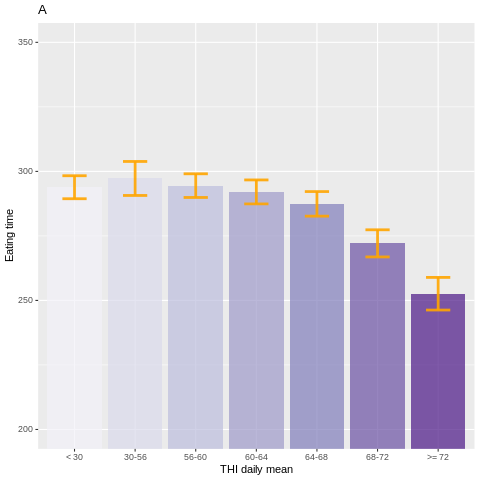

In [ ]:
%%R
finaldf<-finaldfD

finaldf$THImean <-factor(finaldf$THImean, levels=c("< 30","30-56","56-60","60-64","64-68","68-72",">= 72"))
p <-ggplot(finaldf)+ geom_bar( aes(x=THImean , y=lsmean, fill=THImean ), stat="identity",,alpha=0.7)+
geom_errorbar( aes(x=THImean, ymin=lower.CL, ymax=upper.CL), width=0.4, colour="orange", alpha=0.9, size=1.3)
p + coord_cartesian(ylim=c(200,350))+ scale_fill_brewer(palette= "Purples")+ theme(legend.position= "none")+ 
labs(x = "THI daily mean")+ labs(y = "Eating time")+labs(title = "A")+ theme(plot.title = element_text(hjust = 0))

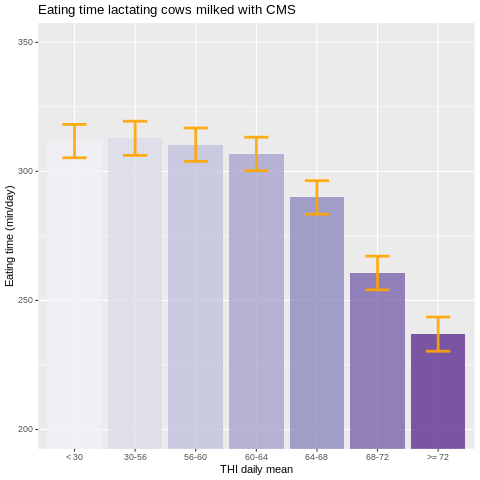

In [ ]:
%%R
finaldf<-finaldfC

finaldf$THImean <-factor(finaldf$THImean, levels=c("< 30","30-56","56-60","60-64","64-68","68-72",">= 72"))
p <-ggplot(finaldf)+ geom_bar( aes(x=THImean , y=lsmean, fill=THImean ), stat="identity",,alpha=0.7)+
geom_errorbar( aes(x=THImean, ymin=lower.CL, ymax=upper.CL), width=0.4, colour="orange", alpha=0.9, size=1.3)
p + coord_cartesian(ylim=c(200,350))+ scale_fill_brewer(palette= "Purples")+ theme(legend.position= "none")+ 
labs(x = "THI daily mean")+ labs(y = "Eating time (min/day)")+labs(title = "Eating time lactating cows milked with CMS")


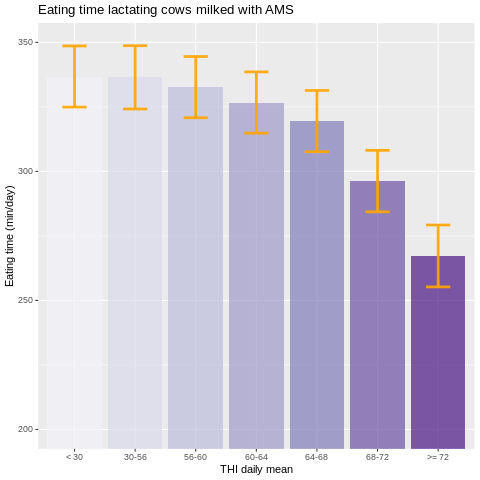

In [ ]:
%%R
finaldf<-finaldfA
finaldf$THImean <-factor(finaldf$THImean, levels=c("< 30","30-56","56-60","60-64","64-68","68-72",">= 72"))
p <-ggplot(finaldf)+ geom_bar( aes(x=THImean , y=lsmean, fill=THImean ), stat="identity",,alpha=0.7)+
geom_errorbar( aes(x=THImean, ymin=lower.CL, ymax=upper.CL), width=0.4, colour="orange", alpha=0.9, size=1.3)
p + coord_cartesian(ylim=c(200,350))+ scale_fill_brewer(palette= "Purples")+ theme(legend.position= "none")+ 
labs(x = "THI daily mean")+ labs(y = "Eating time (min/day)")+labs(title = "Eating time lactating cows milked with AMS")


In [ ]:
%%R
LSMsAL<-emmeans::lsmeans(fit.1a, ~ fThiMeanCat, glhargs=list())
print(LSMsAL)

 fThiMeanCat lsmean   SE     df lower.CL upper.CL
 1              337 6.05 323305      325      349
 0              336 6.25 323305      324      349
 2              333 6.05 323305      321      345
 3              327 6.05 323305      315      339
 4              319 6.05 323305      308      331
 5              296 6.07 323305      284      308
 6              267 6.11 323305      255      279

Results are averaged over the levels of: fDimCat, fLactationNumberCat, fYear, fMonth, fHerdIdentifier 
Confidence level used: 0.95 


In [ ]:
%%R
LSMsCL<-emmeans::lsmeans(fit.1b, ~ fThiMeanCat, glhargs=list())
print(LSMsCL)

 fThiMeanCat lsmean   SE     df lower.CL upper.CL
 1              312 3.30 640912      305      318
 0              313 3.37 640912      306      319
 2              310 3.31 640912      304      317
 3              307 3.31 640912      300      313
 4              290 3.31 640912      283      296
 5              261 3.33 640912      254      267
 6              237 3.38 640912      230      244

Results are averaged over the levels of: fDimCat, fLactationNumberCat, fYear, fMonth, fHerdIdentifier 
Confidence level used: 0.95 


In [ ]:
%%R
LSMsDL<-emmeans::lsmeans(fit.1c, ~ fThiMeanCat, glhargs=list())
print(LSMsDL)

 fThiMeanCat lsmean   SE    df lower.CL upper.CL
 1              294 2.27 72062      289      298
 0              297 3.36 72062      291      304
 2              294 2.34 72062      290      299
 3              292 2.37 72062      287      297
 4              287 2.43 72062      283      292
 5              272 2.68 72062      267      277
 6              253 3.22 72062      246      259

Results are averaged over the levels of: fLactationNumberCat, fYear, fMonth, fHerdIdentifier 
Confidence level used: 0.95 


## Temperature mean figures results

In [ ]:
%%R
url_model6a <- "/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMeanAMS.R"
model<- load(file= url_model6a)
url_model6b <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMeanCMS.R'
model<- load(file= url_model6b)
url_model6c <- '/content/drive/Shareddrives/Bovi-Analytics/Projects/JosjeScheurwater/ProjectHeatStressSensor/data/out/eating/models/ModelTempMeanDRY.R'
model<- load(file= url_model6c)

In [ ]:
%%R
##LSMs for dry cows
LSMsD<-emmeans::lsmeans(fit.6c, ~ fTempMeanCat, glhargs=list())
dfD<-LSMsD%>%
  as.data.frame()

## LSMSs for AMS
LSMsA<-emmeans::lsmeans(fit.6a, ~ fTempMeanCat, glhargs=list())
dfA<-LSMsA%>%
  as.data.frame()

## LSMs for CMS
LSMsC<-emmeans::lsmeans(fit.6b, ~ fTempMeanCat, glhargs=list())
dfC<-LSMsC%>%
  as.data.frame()

In [ ]:
%%R
TempMean<- c("< 0","0-12","12-16","16-20","20-24","24-28",">= 28")
df1 <- data.frame(TempMean)
finaldfD<-cbind(df1,dfD)
finaldfD<- subset(finaldfD, select = -c(fTempMeanCat))
finaldfC<-cbind(df1,dfC)
finaldfC<- subset(finaldfC, select = -c(fTempMeanCat))
finaldfA<-cbind(df1,dfA)
finaldfA<- subset(finaldfA, select = -c(fTempMeanCat))


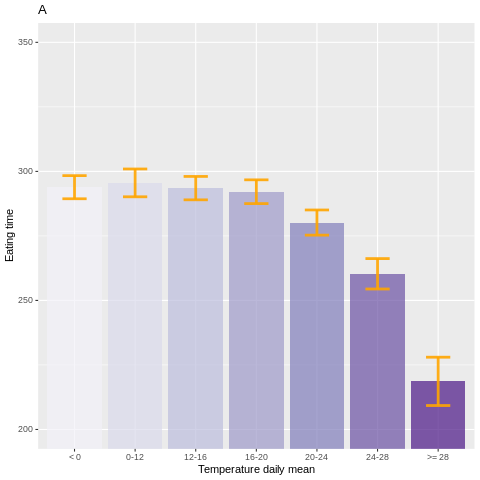

In [ ]:
%%R
finaldf<-finaldfD

finaldf$TempMean <-factor(finaldf$TempMean, levels=c("< 0","0-12","12-16","16-20","20-24","24-28",">= 28"))
p <-ggplot(finaldf)+ geom_bar( aes(x=TempMean , y=lsmean, fill=TempMean ), stat="identity",,alpha=0.7)+
geom_errorbar( aes(x=TempMean, ymin=lower.CL, ymax=upper.CL), width=0.4, colour="orange", alpha=0.9, size=1.3)
p + coord_cartesian(ylim=c(200,350))+ scale_fill_brewer(palette= "Purples")+ theme(legend.position= "none")+ 
labs(x = "Temperature daily mean")+ labs(y = "Eating time")+labs(title = "A")+ theme(plot.title = element_text(hjust = 0))

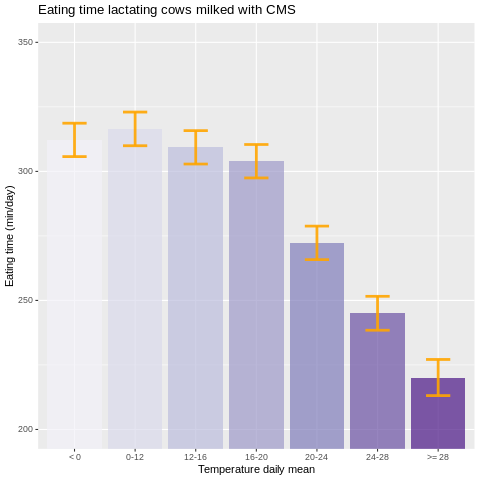

In [ ]:
%%R
finaldf<-finaldfC

finaldf$TempMean <-factor(finaldf$TempMean, levels=c("< 0","0-12","12-16","16-20","20-24","24-28",">= 28"))
p <-ggplot(finaldf)+ geom_bar( aes(x=TempMean , y=lsmean, fill=TempMean ), stat="identity",,alpha=0.7)+
geom_errorbar( aes(x=TempMean, ymin=lower.CL, ymax=upper.CL), width=0.4, colour="orange", alpha=0.9, size=1.3)
p + coord_cartesian(ylim=c(200,350))+ scale_fill_brewer(palette= "Purples")+ theme(legend.position= "none")+ 
labs(x = "Temperature daily mean")+ labs(y = "Eating time (min/day)")+labs(title = "Eating time lactating cows milked with CMS")


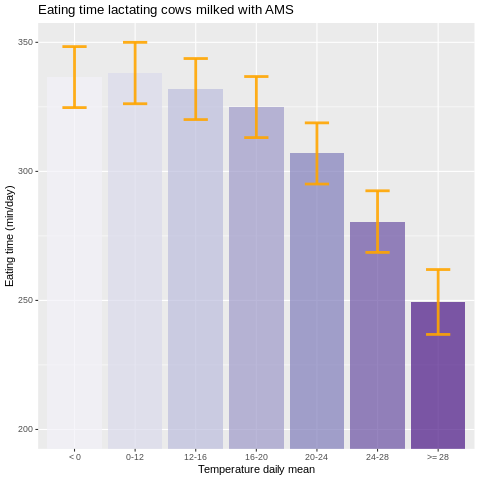

In [ ]:
%%R
finaldf<-finaldfA
finaldf$TempMean <-factor(finaldf$TempMean, levels=c("< 0","0-12","12-16","16-20","20-24","24-28",">= 28"))
p <-ggplot(finaldf)+ geom_bar( aes(x=TempMean , y=lsmean, fill=TempMean ), stat="identity",,alpha=0.7)+
geom_errorbar( aes(x=TempMean, ymin=lower.CL, ymax=upper.CL), width=0.4, colour="orange", alpha=0.9, size=1.3)
p + coord_cartesian(ylim=c(200,350))+ scale_fill_brewer(palette= "Purples")+ theme(legend.position= "none")+ 
labs(x = "Temperature daily mean")+ labs(y = "Eating time (min/day)")+labs(title = "Eating time lactating cows milked with AMS")


In [ ]:
%%R
LSMsAL<-emmeans::lsmeans(fit.6a, ~ fTempMeanCat, glhargs=list())
print(LSMsAL)

 fTempMeanCat lsmean   SE     df lower.CL upper.CL
 1               337 6.03 323305      325      348
 0               338 6.07 323305      326      350
 2               332 6.03 323305      320      344
 3               325 6.03 323305      313      337
 4               307 6.04 323305      295      319
 5               281 6.08 323305      269      292
 6               249 6.41 323305      237      262

Results are averaged over the levels of: fDimCat, fLactationNumberCat, fYear, fMonth, fHerdIdentifier 
Confidence level used: 0.95 


In [ ]:
%%R
LSMsCL<-emmeans::lsmeans(fit.6b, ~ fTempMeanCat, glhargs=list())
print(LSMsCL)

 fTempMeanCat lsmean   SE     df lower.CL upper.CL
 1               312 3.30 640912      306      319
 0               316 3.33 640912      310      323
 2               309 3.30 640912      303      316
 3               304 3.31 640912      297      310
 4               272 3.31 640912      266      279
 5               245 3.36 640912      238      252
 6               220 3.57 640912      213      227

Results are averaged over the levels of: fDimCat, fLactationNumberCat, fYear, fMonth, fHerdIdentifier 
Confidence level used: 0.95 


In [ ]:
%%R
LSMsDL<-emmeans::lsmeans(fit.6c, ~ fTempMeanCat, glhargs=list())
print(LSMsDL)

 fTempMeanCat lsmean   SE    df lower.CL upper.CL
 1               294 2.29 72062      289      298
 0               296 2.75 72062      290      301
 2               294 2.31 72062      289      298
 3               292 2.35 72062      288      297
 4               280 2.49 72062      275      285
 5               260 3.00 72062      254      266
 6               219 4.77 72062      209      228

Results are averaged over the levels of: fLactationNumberCat, fYear, fMonth, fHerdIdentifier 
Confidence level used: 0.95 
